<a href="https://colab.research.google.com/github/FukuokaIruka/Ex3/blob/main/jikken3_5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実験３：Recurrent Neural Networks (RNNs)


RNN（リカレントニューラルネットワーク）は、「順番のあるデータ」 を扱うために設計されたニューラルネットワークです。
テキスト、音声、時系列データなど、**「過去の情報が現在に影響する」**ようなタスクで活躍します。


## 普通のニューラルネットワークとの違うところ
通常のニューラルネットワーク（FC/DenseやCNN）は、入力が独立している前提で設計されています。
たとえば、「私は りんご を 食べた」という文を処理するとき：

* 一単語ずつ処理しても、文脈がわからない
* 「食べた」が意味を持つには、「りんご」が前にあることを知る必要がある

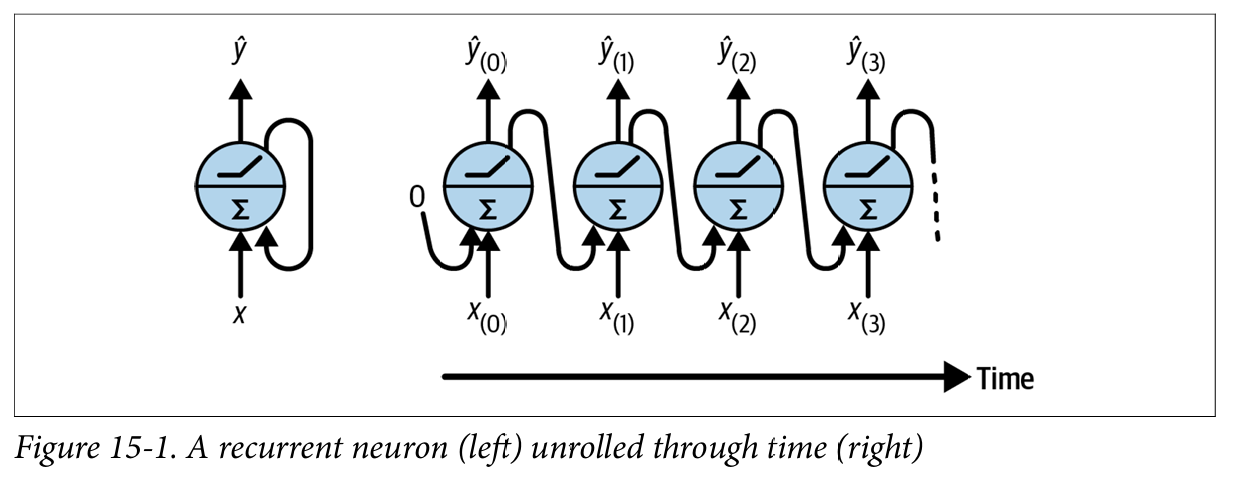

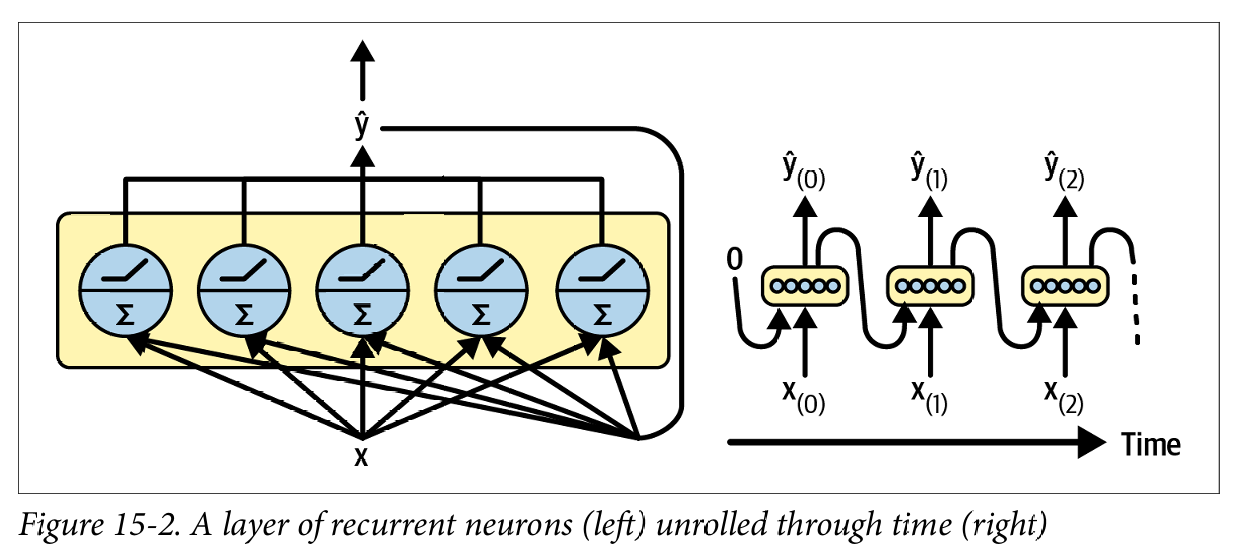

## RNNの考え方：つながっている状態
RNNは、入力を1つずつ順番に受け取りながら、内部に「状態（state）」を保持します。
この状態は、これまで見てきた情報の要約のようなものです。

時刻 t の出力 = 入力（t）+ 状態（t-1）

つまり、RNNは「今の単語」と「前までの流れ」の両方を使って、次の処理を行うことができます。

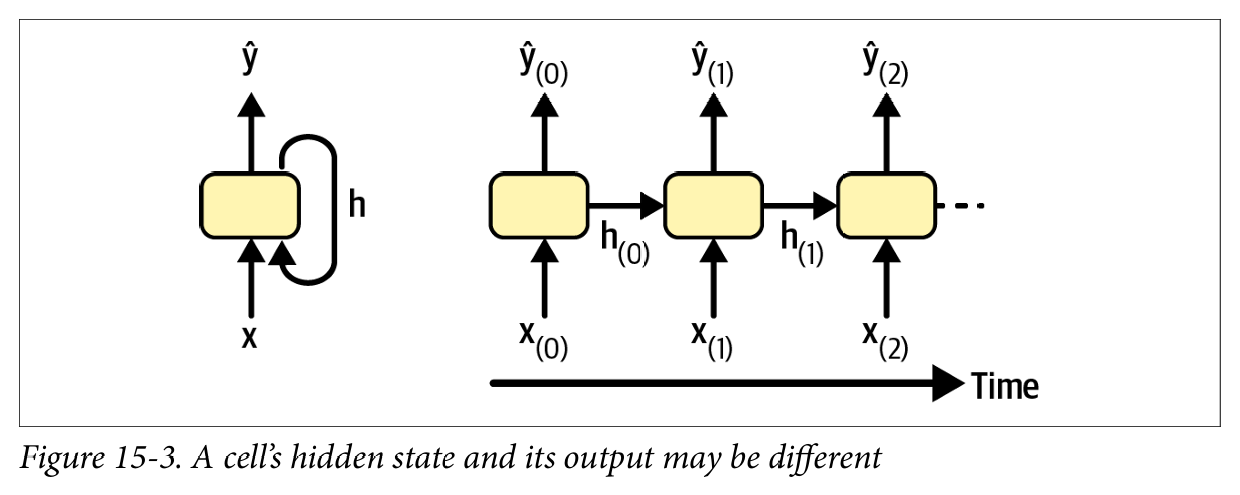

## RNNが使われる場面
* 文章生成（次の単語を予測）
* 音声認識
* 翻訳（入力文 → 出力文）
* 感情分析（文全体を読んでポジティブか判断）
* 時系列予測（株価、天気など）

## RNNの出力タイプ：4つの基本パターン
RNNは、**入力と出力の「長さ」や「対応関係」**によって、さまざまなタスクに応用されます。
代表的な4つの出力パターンを見てみましょう。

### 1. Sequence-to-Sequence（入力系列 → 出力系列）
説明：入力の各時刻に対して、出力を1つずつ返す

使いどころ：次の時刻を予測するなど、時系列予測に使われる

例：株価の系列 → 翌日の株価を逐次予測する

### 2. Sequence-to-Vector（入力系列 → 固定長のベクトル）
説明：系列全体を1つのベクトルに要約して出力

使いどころ：テキスト分類や感情分析に使われる

例：「この映画は最高だった！」→ ポジティブ / ネガティブ のラベル

### 3. Vector-to-Sequence（固定ベクトル → 出力系列）
説明：1つのベクトルから、複数の時系列出力を生成

使いどころ：画像キャプション生成など、生成モデルでよく使われる

例：画像の特徴ベクトル → 「猫が ソファの上に いる」

### 4. Encoder–Decoder（入力系列 → 出力系列）
説明：入力系列を1つのベクトルに圧縮（エンコーダ）、それをもとに出力系列を生成（デコーダ）

使いどころ：機械翻訳や要約など、入力と出力の系列が異なるときに使われる

例：「私は学校に行きます。」 → "I go to school."

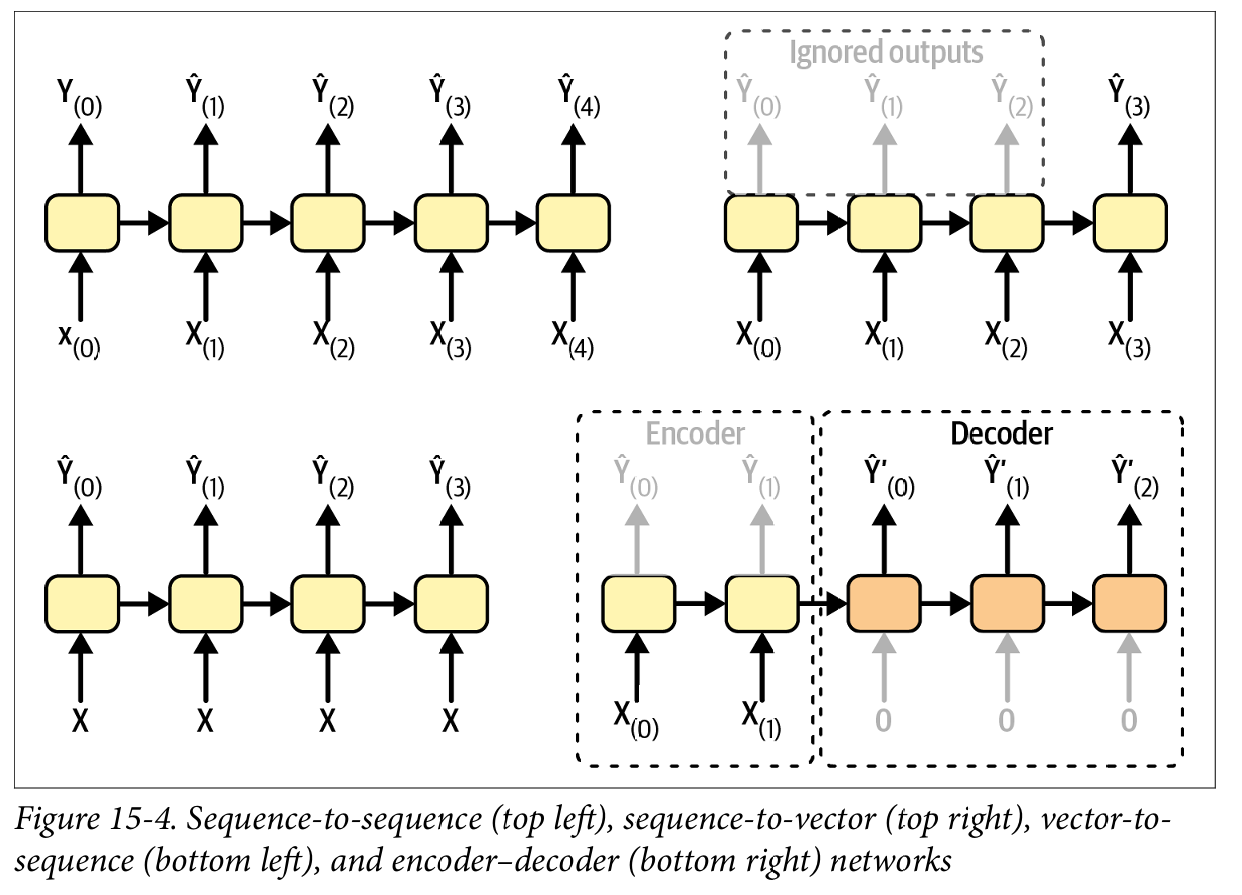

## データセット

In [ ]:
import sys

assert sys.version_info >= (3, 7)

In [ ]:
import os

print(os.environ.get('LD_LIBRARY_PATH'))

None


In [ ]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

2025-05-29 02:36:43.397937: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-29 02:36:43.583410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748453803.650359    5029 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748453803.671007    5029 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748453803.827715    5029 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

In [ ]:
from pathlib import Path
filepath = tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)
if "_extracted" in filepath:
    ridership_path = Path(filepath) / "ridership"
else:
    ridership_path = Path(filepath).with_name("ridership")

In [ ]:
import pandas as pd

path = Path("datasets/ridership_extracted/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [ ]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


## データの特徴：季節性（周期性）
今回扱うシカゴのバス・鉄道の乗客数データには、明らかな**季節性（seasonality）**があります。
特に、曜日ごとのパターンがはっきりしていて、週ごとに似た傾向を繰り返しています。

たとえば：
* 平日は通勤・通学によって利用者が多く
* 週末は利用者が減る傾向がある

このような周期性は、**「時間の流れ」だけでなく「カレンダー的な繰り返し」**も考慮すべきことを意味しています。


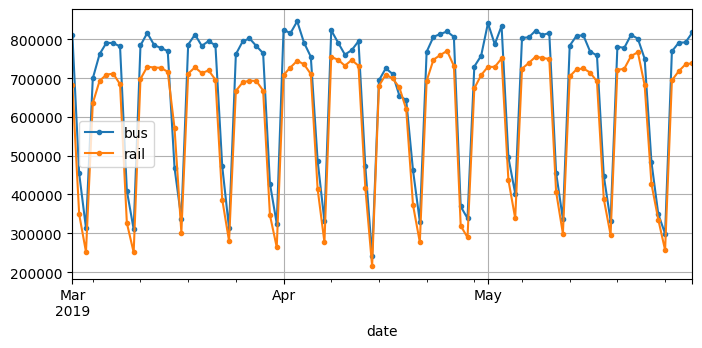

In [ ]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

## 最も単純な予測手法：1週間前をコピーする
このような周期性があるデータに対して、最も単純な予測方法は：

* 「1週間前の値をそのままコピーする」

という方法です。
例えば：

```2024年4月14日（日）の乗客数 ≈ 2024年4月7日（日）の乗客数```

この方法はとてもシンプルですが、意外と強力なベースライン（基準）になります。
これと比べて、RNNなどのモデルがどの程度うまく予測できているかを判断する基準として使うことができます。

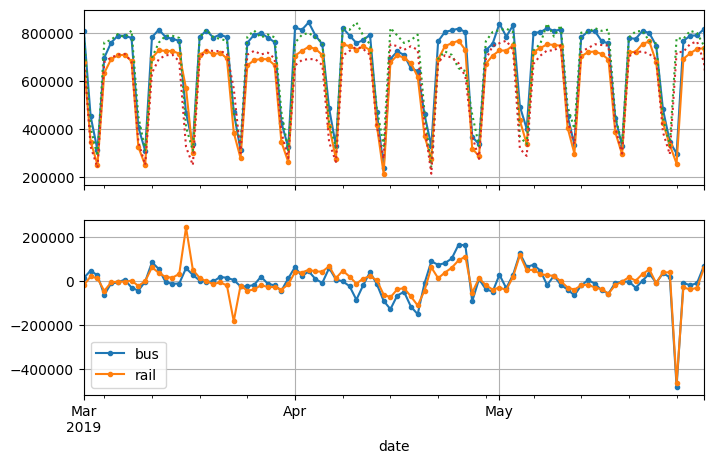

In [ ]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
plt.show()

In [ ]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

## 予測精度の評価：MAEとMAPE

モデルの良し悪しを判断するためには、**「どれくらい予測が外れたか」**を数値で測る必要があります。
ここでは、代表的な2つの指標を紹介します。

### MAE（平均絶対誤差：Mean Absolute Error）

各データ点ごとに「**予測値と実測値の差の絶対値**」を計算し、それを平均したものです。

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

* $y_i$：実際の値（例：実際の乗客数）
* $\hat{y}_i$：予測値（例：モデルの出力）

**直感的に分かりやすく、単位も「人」「円」「件数」などと同じなので解釈しやすい**のが特徴です。

### MAPE（平均絶対パーセント誤差：Mean Absolute Percentage Error）

MAEを「**実測値に対する割合**」で表したものです：

$$
\text{MAPE} = \frac{100}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
$$

* 結果は **%（パーセント）** で表されるため、**直感的に誤差の大きさを比較しやすい**です。

In [ ]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [ ]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

## 年単位のトレンドとその意味

バスや鉄道の乗客数データを長期間にわたって見ると、**年単位のトレンド（長期的な傾向）**があることがわかります。

たとえば：

* ある年を境に全体的な利用者数が減っている
* パンデミックや政策変更による急な変動
* 都市開発による増加傾向

### 長期トレンドは短期予測にはあまり効かない？

たしかに、次の1週間の予測だけを考えるなら、こうした**年単位のトレンドは直接的な手がかりにならない**かもしれません。

> 例：2023年5月の利用者数が前年より少なかった → でも、来週の金曜日の予測にはそれほど影響しない

### それでも、トレンドは「学習」に役立つ

長期的なトレンドは、モデルにとって以下のような学習の手がかりになります：

* **全体のスケール感の変化**（1日あたりの平均利用者数が年々変わる）
* **「同じ曜日でも年によって利用者が違う」**といった文脈の理解
* **異常値や外れ値（イベントや事故）を判断する基準**

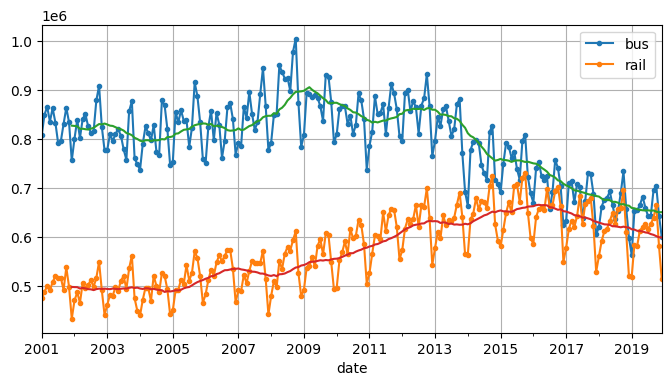

In [ ]:
period = slice("2001", "2019")
try:
    df_monthly = df.select_dtypes(include="number").resample('ME').mean()  # compute the mean for each month
    rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()
except ValueError as ex:
    try:
        df_monthly = df.select_dtypes(include="number").resample('M').mean()  # compute the mean for each month
        rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()
    except ValueError as ex:
        df_monthly = df.resample('M').mean()  # compute the mean for each month
        rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

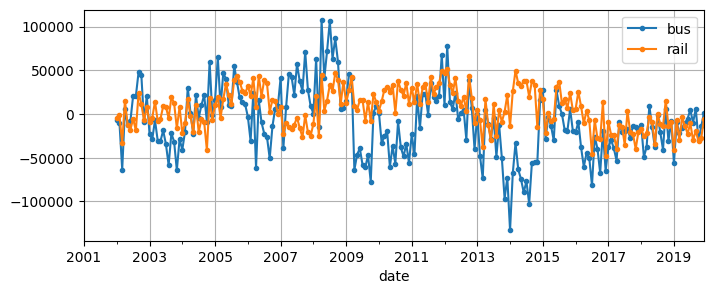

In [ ]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

## RNN用の時系列データの作り方（Keras）

RNNモデルでは、**連続する時系列データ**を「ウィンドウ（window）」として切り出し、それを**訓練データの1つのサンプル**として扱います。

### 🔧 tf.keras.utils.timeseries\_dataset\_from\_array

Keras では、この作業を簡単にしてくれる便利な関数があります：

```python
tf.keras.utils.timeseries_dataset_from_array(
    data=...,       # 時系列データ（NumPy配列など）
    targets=...,    # 予測対象（通常は1ステップ先のデータ）
    sequence_length=...,  # 入力の長さ（何ステップを1サンプルにするか）
    ...
)
```


たとえば、連続したデータ：

```
[1, 2, 3, 4, 5, 6, 7]
```

に対して、`sequence_length = 3` にすると：

* 入力：\[1, 2, 3] → 出力：4
* 入力：\[2, 3, 4] → 出力：5
* 入力：\[3, 4, 5] → 出力：6
  …

といった形で **「スライドウィンドウ形式の訓練データ」**を作ってくれます。

In [ ]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

I0000 00:00:1748453808.038271    5029 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13553 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-05-29 02:36:48.665032: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

### window()とflat\_map()を使ったカスタム処理（低レベルAPI）

さらに細かく自分で制御したいときは、`tf.data.Dataset` を使って次のような処理も可能です：

#### window()

```python
ds = tf.data.Dataset.from_tensor_slices(data)
ds = ds.window(size=window_size, shift=1, drop_remainder=True)
```

* データを指定したウィンドウサイズで **スライス** する

#### flat\_map()

```python
ds = ds.flat_map(lambda window: window.batch(window_size))
```

* `window()` でできたサブセットを「ちゃんとしたテンソル（Tensor）」として扱えるようにする

→ これで、手動で `timeseries_dataset_from_array` と同じような処理が作れます。

In [ ]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


2025-05-29 02:36:48.677036: W tensorflow/core/framework/dataset.cc:993] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2025-05-29 02:36:48.680097: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-29 02:36:48.685102: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-29 02:36:48.693181: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [ ]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [ ]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

## 実装

In [ ]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [ ]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

### 線型

In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

/home/ting/miniconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 15s 488ms/step - loss: 0.1148 - mae: 0.4139

I0000 00:00:1748453809.188938    5115 service.cc:152] XLA service 0x7f5004004fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748453809.188964    5115 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2025-05-29 02:36:49.207918: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748453809.243363    5115 cuda_dnn.cc:529] Loaded cuDNN version 91001
I0000 00:00:1748453809.383208    5115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0551 - mae: 0.2624 - val_loss: 0.0090 - val_mae: 0.1099
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 - mae: 0.1162 - val_loss: 0.0059 - val_mae: 0.0790
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 - mae: 0.0943 - val_loss: 0.0058 - val_mae: 0.0806
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - mae: 0.0874 - val_loss: 0.0049 - val_mae: 0.0703
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - mae: 0.0845 - val_loss: 0.0064 - val_mae: 0.0894
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 - mae: 0.0784 - val_loss: 0.0043 - val_mae: 0.0648
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - mae: 0.0777 - val_loss: 0.0045 - val_mae: 0.0651
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050 - mae: 0.0706 - val_loss: 0.0039 - val_mae: 0.0592
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - mae: 0.

In [ ]:
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - mae: 0.0396


38085.38615703583

### ニューロンひとつ

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

/home/ting/miniconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [ ]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0613 - mae: 0.3111 - val_loss: 0.0119 - val_mae: 0.1162
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0123 - mae: 0.1240 - val_loss: 0.0119 - val_mae: 0.1156
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0115 - mae: 0.1231 - val_loss: 0.0115 - val_mae: 0.1169
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0107 - mae: 0.1213 - val_loss: 0.0115 - val_mae: 0.1162
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0111 - mae: 0.1216 - val_loss: 0.0114 - val_mae: 0.1162
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0112 - mae: 0.1227 - val_loss: 0.0114 - val_mae: 0.1159
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0115 - mae: 0.1248 - val_loss: 0.0113 - val_mae: 0.1159
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0116 - mae: 0.1258 - val_loss: 0.0113 - val_mae: 0.1156
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.01

102775.08944272995

### レイヤーひとつ

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [ ]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0094 - mae: 0.1070 - val_loss: 0.0035 - val_mae: 0.0595
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - mae: 0.0682 - val_loss: 0.0027 - val_mae: 0.0468
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mae: 0.0511 - val_loss: 0.0020 - val_mae: 0.0356
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mae: 0.0515 - val_loss: 0.0020 - val_mae: 0.0348
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mae: 0.0478 - val_loss: 0.0027 - val_mae: 0.0487
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mae: 0.0566 - val_loss: 0.0021 - val_mae: 0.0385
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mae: 0.0492 - val_loss: 0.0034 - val_mae: 0.0634
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mae: 0.0565 - val_loss: 0.0024 - val_mae: 0.0458
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.00

30278.827995061874

### 深層 RNN

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [ ]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.1309 - mae: 0.3480 - val_loss: 0.0137 - val_mae: 0.1491
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0150 - mae: 0.1497 - val_loss: 0.0115 - val_mae: 0.1168
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0132 - mae: 0.1397 - val_loss: 0.0135 - val_mae: 0.1203
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0124 - mae: 0.1273 - val_loss: 0.0070 - val_mae: 0.0976
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0095 - mae: 0.1060 - val_loss: 0.0059 - val_mae: 0.0893
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0065 - mae: 0.0853 - val_loss: 0.0030 - val_mae: 0.0608
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0048 - mae: 0.0678 - val_loss: 0.0022 - val_mae: 0.0459
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0045 - mae: 0.0648 - val_loss: 0.0021 - val_mae: 0.0454
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - lo

28341.69939160347

## RNNの課題：長期依存の問題（Long-Term Dependency）

RNNは時系列を順番に処理しますが：

* 時間が経つにつれて、**過去の情報が忘れられてしまう**
* 勾配が小さくなりすぎる（**勾配消失問題：vanishing gradient**）

結果として、**「遠い過去の情報」**が現在の予測に活かされなくなってしまいます。



### LSTM（Long Short-Term Memory）

LSTMは、RNNのこの問題を解決するために作られた構造です。
内部には3つの「ゲート（門）」があります：

1. **入力ゲート**（どの情報を加えるか）
2. **忘却ゲート**（何を忘れるか）
3. **出力ゲート**（何を次に伝えるか）

この構造によって、LSTMは「必要な情報だけを長く記憶し、不必要な情報は忘れる」ことができます。

> 例：ある路線の混雑傾向が1か月前に変わった → その記憶を長く保持して予測に活かす

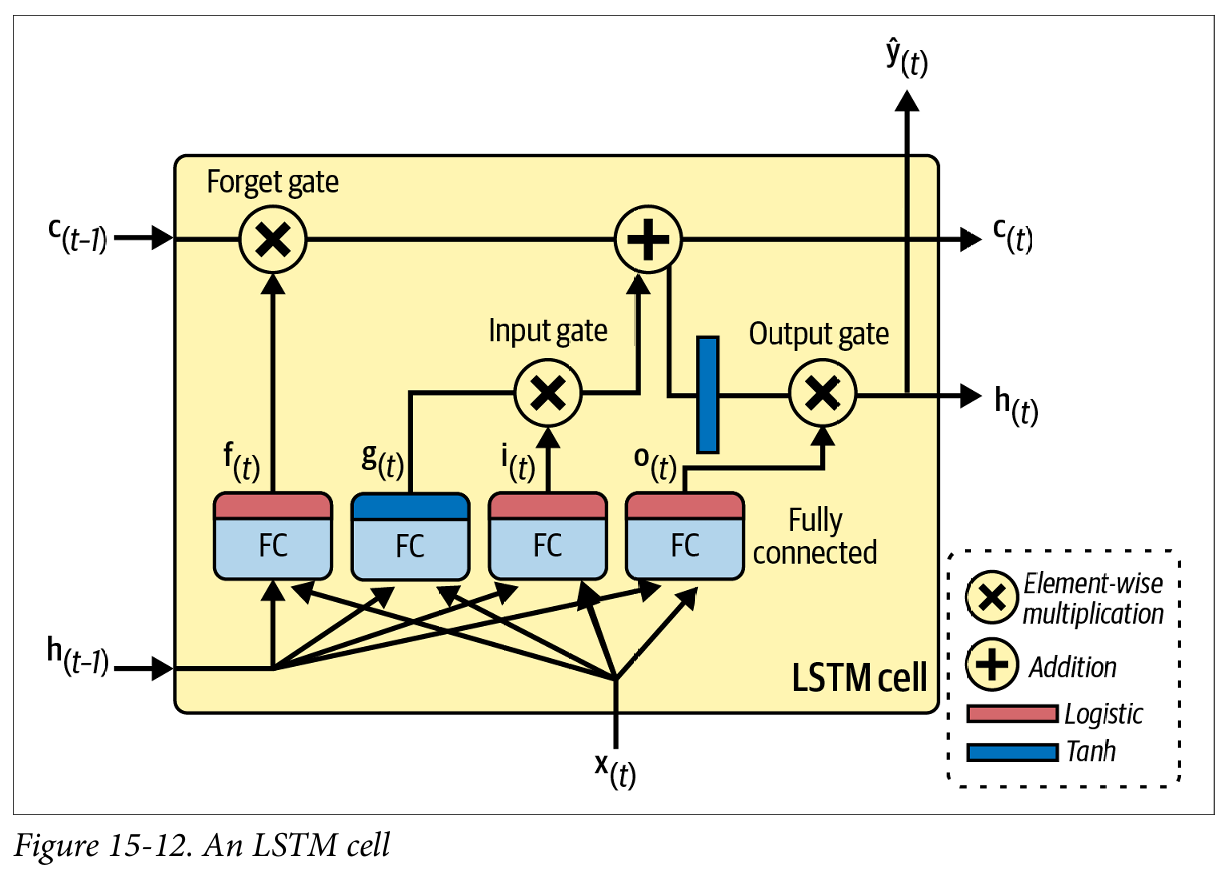

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [ ]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


In [ ]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar, dtype=float)  # one-hot encode the day type

In [ ]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [ ]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(
        lambda S: (S[:, 0], S[:, 1:, target_col]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [ ]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [ ]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0142 - mae: 0.1435 - val_loss: 0.0152 - val_mae: 0.1363
Epoch 2/500


2025-05-29 02:56:42.305181: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:42.305210: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:42.305222: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:42.305224: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:42.305233: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:42.432150: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:42.432188: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0137 - mae: 0.1405 - val_loss: 0.0149 - val_mae: 0.1323
Epoch 3/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0131 - mae: 0.1397

2025-05-29 02:56:42.813468: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:42.813502: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:42.813511: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:42.854815: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:42.854846: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:56:42.854853: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0132 - mae: 0.1361 - val_loss: 0.0142 - val_mae: 0.1308
Epoch 4/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0124 - mae: 0.1360 

2025-05-29 02:56:43.237433: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:43.237469: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:43.237490: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:43.237501: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:43.237505: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:43.278547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:43.278575: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0127 - mae: 0.1333 - val_loss: 0.0137 - val_mae: 0.1284
Epoch 5/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0119 - mae: 0.1326 

2025-05-29 02:56:43.660369: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:43.660402: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:43.660434: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:43.660441: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:43.660447: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:43.701875: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:43.701899: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0122 - mae: 0.1306 - val_loss: 0.0133 - val_mae: 0.1261
Epoch 6/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0119 - mae: 0.1316 

2025-05-29 02:56:44.073536: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:44.073618: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:44.073643: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:44.073658: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:44.073663: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:44.117023: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:44.117051: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0119 - mae: 0.1283 - val_loss: 0.0130 - val_mae: 0.1229
Epoch 7/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0113 - mae: 0.1261 

2025-05-29 02:56:44.494929: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:44.494963: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:44.494970: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:44.494974: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:44.494977: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:44.535808: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:44.535833: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0115 - mae: 0.1244 - val_loss: 0.0125 - val_mae: 0.1209
Epoch 8/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0106 - mae: 0.1242

2025-05-29 02:56:44.910075: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:44.910113: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:44.910125: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:44.910128: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:44.910154: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:44.951317: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:44.951341: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0111 - mae: 0.1220 - val_loss: 0.0121 - val_mae: 0.1192
Epoch 9/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0106 - mae: 0.1219 

2025-05-29 02:56:45.329157: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:45.329191: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:45.329202: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:45.329206: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:45.329209: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:45.372708: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-29 02:56:45.372739: I tensorflow/core/f

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0109 - mae: 0.1205 - val_loss: 0.0119 - val_mae: 0.1169
Epoch 10/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0102 - mae: 0.1179

2025-05-29 02:56:45.745238: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:45.745283: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:45.745292: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:45.745302: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:45.745306: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:45.786371: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:45.786394: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0105 - mae: 0.1174 - val_loss: 0.0116 - val_mae: 0.1152
Epoch 11/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0101 - mae: 0.1162 

2025-05-29 02:56:46.166667: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:46.166705: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:46.166713: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:46.211386: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:46.211415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:56:46.211422: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0103 - mae: 0.1151 - val_loss: 0.0113 - val_mae: 0.1141
Epoch 12/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097 - mae: 0.1143 

2025-05-29 02:56:46.595848: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:46.595895: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:46.595905: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:46.639584: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:46.639613: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:56:46.639620: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0100 - mae: 0.1141 - val_loss: 0.0110 - val_mae: 0.1129
Epoch 13/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0091 - mae: 0.1115

2025-05-29 02:56:47.010592: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:47.010633: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:47.010662: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:47.010686: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:47.010711: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:47.052459: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:47.052481: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ -1s -22554us/step - loss: 0.0099 - mae: 0.1126 - val_loss: 0.0108 - val_mae: 0.1116
Epoch 14/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0096 - mae: 0.1118 

2025-05-29 02:56:46.386871: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:46.386911: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:46.386919: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:46.426536: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:46.426560: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:56:46.426566: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0097 - mae: 0.1112 - val_loss: 0.0107 - val_mae: 0.1106
Epoch 15/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0093 - mae: 0.1092 

2025-05-29 02:56:46.785902: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:46.785947: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:46.785959: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:46.785970: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:46.785973: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:46.826891: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:46.826914: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0096 - mae: 0.1097 - val_loss: 0.0105 - val_mae: 0.1095
Epoch 16/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0090 - mae: 0.1077 

2025-05-29 02:56:47.190229: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:47.190274: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:47.190283: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:47.190294: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:47.190298: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:47.229052: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:47.229168: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0094 - mae: 0.1085 - val_loss: 0.0103 - val_mae: 0.1087
Epoch 17/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0092 - mae: 0.1086 

2025-05-29 02:56:47.594680: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:47.594725: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:47.594755: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:47.594763: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:47.594799: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:47.636585: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:47.636612: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0094 - mae: 0.1084 - val_loss: 0.0103 - val_mae: 0.1082
Epoch 18/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0090 - mae: 0.1066 

2025-05-29 02:56:48.002467: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:48.002501: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:48.002507: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:48.043403: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:48.043427: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:56:48.043433: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0092 - mae: 0.1070 - val_loss: 0.0101 - val_mae: 0.1073
Epoch 19/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0083 - mae: 0.1035

2025-05-29 02:56:48.432959: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:48.432994: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:48.433001: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:48.433005: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:48.433009: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:48.476282: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:48.476310: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0091 - mae: 0.1061 - val_loss: 0.0100 - val_mae: 0.1067
Epoch 20/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0089 - mae: 0.1060 

2025-05-29 02:56:48.855419: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:48.896218: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:48.896251: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:56:48.896259: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0091 - mae: 0.1059 - val_loss: 0.0099 - val_mae: 0.1060
Epoch 21/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0088 - mae: 0.1047 

2025-05-29 02:56:49.262319: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:49.262353: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:49.262360: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:49.262364: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:49.262367: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:49.302147: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:49.302176: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0089 - mae: 0.1048 - val_loss: 0.0097 - val_mae: 0.1055
Epoch 22/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - mae: 0.1031 

2025-05-29 02:56:49.658266: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:49.658300: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:49.658307: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:49.658311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:49.658314: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:49.701616: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:49.701647: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0089 - mae: 0.1043 - val_loss: 0.0097 - val_mae: 0.1051
Epoch 23/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - mae: 0.1030 

2025-05-29 02:56:50.111495: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:50.111525: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:56:50.111531: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0088 - mae: 0.1038 - val_loss: 0.0097 - val_mae: 0.1044
Epoch 24/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083 - mae: 0.1017 

2025-05-29 02:56:50.482029: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:50.482075: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:50.482079: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:50.482090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:50.482093: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:50.520452: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:50.520479: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0086 - mae: 0.1027 - val_loss: 0.0094 - val_mae: 0.1039
Epoch 25/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - mae: 0.1030 

2025-05-29 02:56:50.893962: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:50.893998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:50.894072: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:50.894083: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:50.894086: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:50.935630: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-29 02:56:50.935655: I tensorflow/core/f

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0087 - mae: 0.1031 - val_loss: 0.0095 - val_mae: 0.1036
Epoch 26/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083 - mae: 0.1016 

2025-05-29 02:56:51.312457: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:51.312491: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:51.312498: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:51.312502: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:51.312506: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:51.354727: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:51.354755: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0085 - mae: 0.1020 - val_loss: 0.0094 - val_mae: 0.1029
Epoch 27/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083 - mae: 0.1014 

2025-05-29 02:56:51.728020: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:51.728080: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:51.728121: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:51.728137: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:51.728142: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:51.770000: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:51.770025: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0086 - mae: 0.1020 - val_loss: 0.0094 - val_mae: 0.1026
Epoch 28/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0082 - mae: 0.1007 

2025-05-29 02:56:52.130636: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:52.130671: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:52.130678: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:52.170800: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:52.170824: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:56:52.170831: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0085 - mae: 0.1014 - val_loss: 0.0093 - val_mae: 0.1019
Epoch 29/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0075 - mae: 0.0972

2025-05-29 02:56:52.533882: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:52.533921: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:52.533929: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:52.581422: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:52.581457: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:56:52.581465: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0083 - mae: 0.1004 - val_loss: 0.0091 - val_mae: 0.1014
Epoch 30/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080 - mae: 0.0993 

2025-05-29 02:56:52.939336: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:52.939366: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:52.939390: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:52.939409: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:52.939428: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:52.979765: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:52.979788: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0083 - mae: 0.1002 - val_loss: 0.0092 - val_mae: 0.1011
Epoch 31/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083 - mae: 0.1008 

2025-05-29 02:56:53.341666: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:53.341726: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:53.341734: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:53.341750: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:53.341754: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:53.384991: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:53.385018: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0084 - mae: 0.1002 - val_loss: 0.0091 - val_mae: 0.1006
Epoch 32/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081 - mae: 0.0996 

2025-05-29 02:56:53.750825: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:53.750863: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:53.750919: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:53.750932: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:53.750937: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:53.792744: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:53.792775: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0082 - mae: 0.0994 - val_loss: 0.0090 - val_mae: 0.1002
Epoch 33/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - mae: 0.0982 

2025-05-29 02:56:54.160946: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:54.160980: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:54.160992: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:54.160996: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:54.160999: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:54.200891: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:54.200913: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0082 - mae: 0.0992 - val_loss: 0.0090 - val_mae: 0.0999
Epoch 34/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0070 - mae: 0.0937

2025-05-29 02:56:54.574411: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:54.574444: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:54.574454: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:54.574463: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:54.574466: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:54.617803: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:54.617828: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0082 - mae: 0.0988 - val_loss: 0.0090 - val_mae: 0.0997
Epoch 35/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0956 

2025-05-29 02:56:54.986416: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:54.986459: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:54.986467: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:55.027341: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:55.027363: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:56:55.027369: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0080 - mae: 0.0975 - val_loss: 0.0090 - val_mae: 0.0993
Epoch 36/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - mae: 0.0971 

2025-05-29 02:56:55.389322: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:55.389356: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:55.389364: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:55.428833: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:55.428857: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:56:55.428863: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0080 - mae: 0.0975 - val_loss: 0.0087 - val_mae: 0.0983
Epoch 37/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0973 

2025-05-29 02:56:55.796834: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:55.796867: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:55.796874: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:55.796877: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:55.796880: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:55.837000: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:55.837028: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0080 - mae: 0.0973 - val_loss: 0.0088 - val_mae: 0.0983
Epoch 38/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0947 

2025-05-29 02:56:56.204298: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:56.204322: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:56.204328: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:56.204332: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:56.204335: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:56.244880: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:56.244912: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0079 - mae: 0.0964 - val_loss: 0.0088 - val_mae: 0.0979
Epoch 39/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0945 

2025-05-29 02:56:56.622471: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:56.622505: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:56.622531: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:56.622538: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:56.622543: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:56.663565: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:56.663593: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0078 - mae: 0.0959 - val_loss: 0.0087 - val_mae: 0.0974
Epoch 40/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0075 - mae: 0.0943

2025-05-29 02:56:57.035481: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:57.035521: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:57.035529: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:57.075540: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:57.075567: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:56:57.075574: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0078 - mae: 0.0954 - val_loss: 0.0086 - val_mae: 0.0968
Epoch 41/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0073 - mae: 0.0933 

2025-05-29 02:56:57.449187: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:57.449242: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:57.449271: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:57.449285: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:57.449289: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:57.490836: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:57.490861: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0077 - mae: 0.0948 - val_loss: 0.0085 - val_mae: 0.0964
Epoch 42/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0071 - mae: 0.0923

2025-05-29 02:56:57.866280: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:57.866319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:57.866327: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:57.909497: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:57.909521: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0077 - mae: 0.0950 - val_loss: 0.0085 - val_mae: 0.0961
Epoch 43/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0073 - mae: 0.0928 

2025-05-29 02:56:58.286304: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:58.286341: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:58.286349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:58.327824: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:58.327849: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:56:58.327855: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0076 - mae: 0.0941 - val_loss: 0.0084 - val_mae: 0.0955
Epoch 44/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0074 - mae: 0.0933

2025-05-29 02:56:58.704662: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:58.704697: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:58.745743: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:58.745773: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:56:58.745780: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0076 - mae: 0.0939 - val_loss: 0.0083 - val_mae: 0.0952
Epoch 45/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0073 - mae: 0.0927  

2025-05-29 02:56:59.245545: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:59.245577: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:56:59.245583: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0075 - mae: 0.0934 - val_loss: 0.0083 - val_mae: 0.0947
Epoch 46/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - mae: 0.0933 

2025-05-29 02:56:59.642769: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:56:59.642806: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:56:59.642815: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:56:59.642819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:56:59.642823: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:56:59.683494: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:56:59.683518: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0075 - mae: 0.0933 - val_loss: 0.0083 - val_mae: 0.0947
Epoch 47/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - mae: 0.0915 

2025-05-29 02:57:00.063069: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:00.063133: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:00.063162: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:00.063167: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:00.063204: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:00.103672: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:00.103696: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0074 - mae: 0.0925 - val_loss: 0.0084 - val_mae: 0.0947
Epoch 48/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0068 - mae: 0.0890

2025-05-29 02:57:00.476282: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:00.476319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:00.476326: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:00.517065: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:00.517094: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:00.517101: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0072 - mae: 0.0911 - val_loss: 0.0081 - val_mae: 0.0934
Epoch 49/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - mae: 0.0903 

2025-05-29 02:57:00.899395: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:00.899431: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:00.899438: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:00.942898: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:00.942923: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0073 - mae: 0.0912 - val_loss: 0.0081 - val_mae: 0.0929
Epoch 50/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0896 

2025-05-29 02:57:01.353557: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:01.353593: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:01.353600: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0072 - mae: 0.0907 - val_loss: 0.0081 - val_mae: 0.0930
Epoch 51/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0063 - mae: 0.0861

2025-05-29 02:57:01.743774: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:01.743819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:01.743829: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:01.785759: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:01.785793: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:01.785800: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0071 - mae: 0.0899 - val_loss: 0.0081 - val_mae: 0.0926
Epoch 52/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mae: 0.0883 

2025-05-29 02:57:02.166247: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:02.166286: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:02.166294: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:02.206576: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:02.206600: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:02.206606: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0071 - mae: 0.0898 - val_loss: 0.0079 - val_mae: 0.0916
Epoch 53/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0068 - mae: 0.0882

2025-05-29 02:57:02.583174: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:02.583230: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:02.583256: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:02.583261: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:02.583265: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:02.624227: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:02.624252: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0070 - mae: 0.0890 - val_loss: 0.0078 - val_mae: 0.0909
Epoch 54/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0066 - mae: 0.0867

2025-05-29 02:57:03.001690: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:03.001732: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:03.001740: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:03.044351: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:03.044376: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:03.044382: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0070 - mae: 0.0886 - val_loss: 0.0078 - val_mae: 0.0907
Epoch 55/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - mae: 0.0867 

2025-05-29 02:57:03.423894: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:03.423932: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:03.423941: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:03.464877: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:03.464991: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:03.464999: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069 - mae: 0.0883 - val_loss: 0.0077 - val_mae: 0.0902
Epoch 56/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - mae: 0.0865 

2025-05-29 02:57:03.832729: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:03.832789: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:03.832801: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:03.832807: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:03.832812: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:03.872300: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:03.872325: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069 - mae: 0.0876 - val_loss: 0.0077 - val_mae: 0.0899
Epoch 57/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - mae: 0.0866 

2025-05-29 02:57:04.241042: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:04.241105: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:04.241130: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:04.241142: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:04.241145: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:04.281350: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-29 02:57:04.281373: I tensorflow/core/f

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0068 - mae: 0.0873 - val_loss: 0.0075 - val_mae: 0.0893
Epoch 58/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065 - mae: 0.0857 

2025-05-29 02:57:04.643643: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:04.643679: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:04.643688: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:04.683077: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:04.683105: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:04.683112: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0068 - mae: 0.0870 - val_loss: 0.0076 - val_mae: 0.0892
Epoch 59/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0060 - mae: 0.0822

2025-05-29 02:57:05.051211: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:05.051248: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:05.051257: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:05.099859: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:05.099886: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:05.099892: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0067 - mae: 0.0862 - val_loss: 0.0075 - val_mae: 0.0885
Epoch 60/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065 - mae: 0.0849

2025-05-29 02:57:05.466221: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:05.466282: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:05.466310: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:05.466325: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:05.466329: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:05.505407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:05.505433: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0067 - mae: 0.0861 - val_loss: 0.0075 - val_mae: 0.0884
Epoch 61/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063 - mae: 0.0837 

2025-05-29 02:57:05.875923: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:05.875956: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:05.875963: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:05.875967: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:05.875970: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:05.918368: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:05.918398: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0066 - mae: 0.0850 - val_loss: 0.0074 - val_mae: 0.0876
Epoch 62/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063 - mae: 0.0831 

2025-05-29 02:57:06.281637: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:06.281673: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:06.281682: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:06.319430: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:06.319454: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:06.319460: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0066 - mae: 0.0846 - val_loss: 0.0073 - val_mae: 0.0874
Epoch 63/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0062 - mae: 0.0825 

2025-05-29 02:57:06.671723: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:06.671758: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:06.671765: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:06.714743: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:06.714768: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:06.714774: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065 - mae: 0.0839 - val_loss: 0.0073 - val_mae: 0.0869
Epoch 64/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0055 - mae: 0.0786

2025-05-29 02:57:07.082241: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:07.082287: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:07.082295: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:07.122913: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:07.122937: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:07.122943: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0064 - mae: 0.0837 - val_loss: 0.0072 - val_mae: 0.0866
Epoch 65/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 - mae: 0.0813 

2025-05-29 02:57:07.495568: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:07.495621: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:07.495633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:07.495640: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:07.495646: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:07.537792: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:07.537835: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0063 - mae: 0.0828 - val_loss: 0.0072 - val_mae: 0.0860
Epoch 66/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061 - mae: 0.0812 

2025-05-29 02:57:07.896015: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:07.896049: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:07.896059: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:07.896068: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:07.896070: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:07.935292: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:07.935318: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0063 - mae: 0.0825 - val_loss: 0.0071 - val_mae: 0.0854
Epoch 67/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - mae: 0.0808 

2025-05-29 02:57:08.301243: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:08.301290: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:08.301302: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:08.301313: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:08.301317: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:08.341175: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:08.341200: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0063 - mae: 0.0821 - val_loss: 0.0070 - val_mae: 0.0847
Epoch 68/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059 - mae: 0.0797 

2025-05-29 02:57:08.705575: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:08.705619: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:08.705633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:08.705639: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:08.705646: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:08.746743: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:08.746766: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062 - mae: 0.0816 - val_loss: 0.0071 - val_mae: 0.0851
Epoch 69/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0057 - mae: 0.0784

2025-05-29 02:57:09.109342: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:09.109387: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:09.109395: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:09.109401: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:09.148040: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:09.148066: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:09.148073: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - mae: 0.0809 - val_loss: 0.0069 - val_mae: 0.0838
Epoch 70/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - mae: 0.0786 

2025-05-29 02:57:09.523103: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:09.523137: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:09.523162: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:09.523169: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:09.523174: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:09.566795: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:09.566822: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060 - mae: 0.0802 - val_loss: 0.0068 - val_mae: 0.0830
Epoch 71/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mae: 0.0777 

2025-05-29 02:57:09.938156: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:09.938194: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:09.938202: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:09.977086: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:09.977108: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:09.977115: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - mae: 0.0802 - val_loss: 0.0070 - val_mae: 0.0842
Epoch 72/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mae: 0.0765 

2025-05-29 02:57:10.350529: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:10.350568: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:10.350577: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:10.350582: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:10.350586: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:10.392339: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:10.392368: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060 - mae: 0.0791 - val_loss: 0.0067 - val_mae: 0.0822
Epoch 73/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0057 - mae: 0.0779 

2025-05-29 02:57:10.756422: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:10.756469: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:10.756479: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:10.796318: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:10.796345: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:10.796352: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060 - mae: 0.0792 - val_loss: 0.0067 - val_mae: 0.0819
Epoch 74/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 - mae: 0.0784 

2025-05-29 02:57:11.160484: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:11.160514: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:11.160525: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:11.160529: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:11.160531: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:11.202111: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:11.202144: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0059 - mae: 0.0788 - val_loss: 0.0066 - val_mae: 0.0811
Epoch 75/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0048 - mae: 0.0720

2025-05-29 02:57:11.577316: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:11.577360: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:11.577366: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:11.626338: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:11.626370: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:11.626396: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0059 - mae: 0.0783 - val_loss: 0.0066 - val_mae: 0.0812
Epoch 76/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mae: 0.0765 

2025-05-29 02:57:12.000673: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:12.000708: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:12.000714: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:12.040632: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:12.040660: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:12.040669: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0059 - mae: 0.0781 - val_loss: 0.0066 - val_mae: 0.0814
Epoch 77/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054 - mae: 0.0752 

2025-05-29 02:57:12.454416: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:12.454449: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:12.454457: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0057 - mae: 0.0770 - val_loss: 0.0065 - val_mae: 0.0803
Epoch 78/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056 - mae: 0.0762 

2025-05-29 02:57:12.819356: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:12.819391: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:12.819416: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:12.819421: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:12.819433: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:12.861121: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:12.861145: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058 - mae: 0.0771 - val_loss: 0.0064 - val_mae: 0.0793
Epoch 79/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - mae: 0.0759 

2025-05-29 02:57:13.231251: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:13.231308: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:13.270707: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:13.270741: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:13.270749: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0057 - mae: 0.0768 - val_loss: 0.0064 - val_mae: 0.0795
Epoch 80/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0046 - mae: 0.0700

2025-05-29 02:57:13.648428: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:13.648463: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:13.648472: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:13.648482: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:13.648485: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:13.688904: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:13.688928: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056 - mae: 0.0755 - val_loss: 0.0063 - val_mae: 0.0790
Epoch 81/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - mae: 0.0736 

2025-05-29 02:57:14.071685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:14.071723: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:14.071731: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:14.116618: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:14.116642: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:14.116648: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056 - mae: 0.0756 - val_loss: 0.0063 - val_mae: 0.0792
Epoch 82/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - mae: 0.0723 

2025-05-29 02:57:14.494983: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:14.495021: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:14.495029: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:14.535263: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:14.535289: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:14.535296: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055 - mae: 0.0749 - val_loss: 0.0062 - val_mae: 0.0780
Epoch 83/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - mae: 0.0735 

2025-05-29 02:57:14.911906: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:14.911941: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:14.911972: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:14.911994: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:14.912002: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:14.951144: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:14.951169: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055 - mae: 0.0747 - val_loss: 0.0062 - val_mae: 0.0778
Epoch 84/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - mae: 0.0729 

2025-05-29 02:57:15.326560: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:15.326590: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:15.326616: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:15.326623: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:15.326626: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:15.365942: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:15.365967: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055 - mae: 0.0742 - val_loss: 0.0061 - val_mae: 0.0772
Epoch 85/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mae: 0.0717 

2025-05-29 02:57:15.740193: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:15.740228: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:15.740235: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:15.740239: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:15.740243: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:15.779876: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:15.779901: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - mae: 0.0740 - val_loss: 0.0061 - val_mae: 0.0772
Epoch 86/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - mae: 0.0725 

2025-05-29 02:57:16.148984: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:16.149025: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:16.149033: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:16.188782: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:16.188845: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:16.188855: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - mae: 0.0737 - val_loss: 0.0060 - val_mae: 0.0763
Epoch 87/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - mae: 0.0732 

2025-05-29 02:57:16.554093: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:16.554138: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:16.554147: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:16.596230: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:16.596261: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:16.596269: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - mae: 0.0738 - val_loss: 0.0060 - val_mae: 0.0763
Epoch 88/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mae: 0.0717 

2025-05-29 02:57:16.965092: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:16.965121: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:16.965132: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:16.965136: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:16.965160: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:17.004506: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:17.004533: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0053 - mae: 0.0730 - val_loss: 0.0060 - val_mae: 0.0758
Epoch 89/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0046 - mae: 0.0685

2025-05-29 02:57:17.376943: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:17.376985: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:17.376994: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:17.417715: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:17.417742: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:17.417749: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - mae: 0.0730 - val_loss: 0.0059 - val_mae: 0.0755
Epoch 90/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mae: 0.0702 

2025-05-29 02:57:17.784511: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:17.784558: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:17.784566: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:17.784578: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:17.784581: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:17.823930: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:17.823962: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - mae: 0.0728 - val_loss: 0.0060 - val_mae: 0.0762
Epoch 91/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0042 - mae: 0.0654

2025-05-29 02:57:18.197476: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:18.197519: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:18.197528: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:18.245733: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:18.245768: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:18.245776: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ -1s -22630us/step - loss: 0.0052 - mae: 0.0717 - val_loss: 0.0059 - val_mae: 0.0750
Epoch 92/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - mae: 0.0700 

2025-05-29 02:57:17.576843: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:17.576889: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:17.576895: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:17.576907: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:17.576910: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:17.618795: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:17.618818: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052 - mae: 0.0717 - val_loss: 0.0058 - val_mae: 0.0744
Epoch 93/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0046 - mae: 0.0678

2025-05-29 02:57:17.999511: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:17.999551: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:17.999669: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:18.039324: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:18.039361: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:18.039370: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052 - mae: 0.0718 - val_loss: 0.0058 - val_mae: 0.0739
Epoch 94/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - mae: 0.0715 

2025-05-29 02:57:18.435019: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:18.435057: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:18.435065: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:18.473996: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:18.474024: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:18.474032: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052 - mae: 0.0716 - val_loss: 0.0057 - val_mae: 0.0738
Epoch 95/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - mae: 0.0694 

2025-05-29 02:57:18.850373: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:18.850419: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:18.850429: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:18.889824: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:18.889848: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:18.889854: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0051 - mae: 0.0709 - val_loss: 0.0057 - val_mae: 0.0737
Epoch 96/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0043 - mae: 0.0651

2025-05-29 02:57:19.258986: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:19.259151: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:19.259164: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:19.300343: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:19.300366: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:19.300372: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0051 - mae: 0.0705 - val_loss: 0.0057 - val_mae: 0.0738
Epoch 97/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - mae: 0.0683 

2025-05-29 02:57:19.686271: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:19.686304: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:19.686311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:19.686315: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:19.686318: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:19.725873: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:19.725901: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050 - mae: 0.0701 - val_loss: 0.0056 - val_mae: 0.0724
Epoch 98/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - mae: 0.0695 

2025-05-29 02:57:20.098020: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:20.098057: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:20.098065: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:20.139023: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:20.139056: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:20.139064: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0051 - mae: 0.0704 - val_loss: 0.0056 - val_mae: 0.0730
Epoch 99/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mae: 0.0687 

2025-05-29 02:57:20.506927: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:20.506963: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:20.506988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:20.507007: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:20.507016: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:20.547710: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:20.547737: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050 - mae: 0.0700 - val_loss: 0.0056 - val_mae: 0.0721
Epoch 100/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mae: 0.0682 

2025-05-29 02:57:20.920131: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:20.920176: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:20.920184: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:20.960608: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:20.960634: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:20.960641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050 - mae: 0.0696 - val_loss: 0.0056 - val_mae: 0.0725
Epoch 101/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mae: 0.0671 

2025-05-29 02:57:21.326361: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:21.326396: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:21.365913: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:21.365936: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:21.365941: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - mae: 0.0692 - val_loss: 0.0055 - val_mae: 0.0714
Epoch 102/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - mae: 0.0670

2025-05-29 02:57:21.736236: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:21.736271: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:21.736279: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:21.736282: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:21.736287: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:21.776053: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:21.776078: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - mae: 0.0690 - val_loss: 0.0055 - val_mae: 0.0713
Epoch 103/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mae: 0.0680 

2025-05-29 02:57:22.144664: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:22.144698: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:22.144723: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:22.144786: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:22.144794: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:22.186803: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:22.186827: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - mae: 0.0689 - val_loss: 0.0055 - val_mae: 0.0712
Epoch 104/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - mae: 0.0672 

2025-05-29 02:57:22.549469: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:22.549515: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:22.549528: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:22.549541: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:22.549546: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:22.593225: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:22.593251: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - mae: 0.0687 - val_loss: 0.0054 - val_mae: 0.0705
Epoch 105/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mae: 0.0675 

2025-05-29 02:57:22.965851: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:22.965920: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:22.965956: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:22.965971: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:22.965975: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:23.007344: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:23.007369: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - mae: 0.0687 - val_loss: 0.0054 - val_mae: 0.0711
Epoch 106/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mae: 0.0670 

2025-05-29 02:57:23.380685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:23.380737: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:23.380746: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:23.422319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:23.422347: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:23.422354: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - mae: 0.0685 - val_loss: 0.0054 - val_mae: 0.0705
Epoch 107/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mae: 0.0669 

2025-05-29 02:57:23.803692: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:23.803726: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:23.803736: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:23.803745: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:23.803748: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:23.845311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:23.845340: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - mae: 0.0684 - val_loss: 0.0053 - val_mae: 0.0702
Epoch 108/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0041 - mae: 0.0637

2025-05-29 02:57:24.221067: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:24.221106: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:24.221114: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:24.221119: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:24.221123: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:24.265905: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:24.265929: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - mae: 0.0678 - val_loss: 0.0053 - val_mae: 0.0700
Epoch 109/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mae: 0.0655 

2025-05-29 02:57:24.641552: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:24.641594: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:24.641604: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:24.641610: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:24.641616: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:24.683513: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:24.683538: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - mae: 0.0675 - val_loss: 0.0053 - val_mae: 0.0696
Epoch 110/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mae: 0.0663 

2025-05-29 02:57:25.096261: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:25.096336: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:25.096343: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mae: 0.0675 - val_loss: 0.0053 - val_mae: 0.0697
Epoch 111/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mae: 0.0664 

2025-05-29 02:57:25.458068: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:25.458098: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:25.458109: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:25.458113: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:25.458118: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:25.497297: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:25.497319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - mae: 0.0674 - val_loss: 0.0052 - val_mae: 0.0689
Epoch 112/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mae: 0.0659 

2025-05-29 02:57:25.865167: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:25.909801: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:25.909815: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:25.909819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - mae: 0.0671 - val_loss: 0.0052 - val_mae: 0.0688
Epoch 113/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mae: 0.0655 

2025-05-29 02:57:26.270476: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:26.270516: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:26.270523: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:26.270528: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:26.311163: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:26.311194: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:26.311201: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - mae: 0.0669 - val_loss: 0.0052 - val_mae: 0.0685
Epoch 114/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mae: 0.0658 

2025-05-29 02:57:26.682434: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:26.682478: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:26.682487: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:26.727827: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:26.727853: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:26.727860: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - mae: 0.0667 - val_loss: 0.0051 - val_mae: 0.0681
Epoch 115/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mae: 0.0659 

2025-05-29 02:57:27.103903: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:27.146292: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:27.146318: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:27.146324: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - mae: 0.0669 - val_loss: 0.0051 - val_mae: 0.0683
Epoch 116/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mae: 0.0649 

2025-05-29 02:57:27.507149: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:27.507186: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:27.507195: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:27.507199: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:27.507203: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:27.547382: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:27.547407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - mae: 0.0664 - val_loss: 0.0051 - val_mae: 0.0679
Epoch 117/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mae: 0.0644 

2025-05-29 02:57:27.919685: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:27.919734: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:27.919740: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:27.919746: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:27.960640: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:27.960670: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:27.960677: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - mae: 0.0660 - val_loss: 0.0051 - val_mae: 0.0680
Epoch 118/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mae: 0.0661 

2025-05-29 02:57:28.341162: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:28.341199: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:28.341207: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:28.381530: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:28.381559: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:28.381567: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - mae: 0.0665 - val_loss: 0.0051 - val_mae: 0.0677
Epoch 119/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mae: 0.0633 

2025-05-29 02:57:28.755221: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:28.796192: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:28.796216: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:28.796221: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - mae: 0.0654 - val_loss: 0.0050 - val_mae: 0.0674
Epoch 120/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mae: 0.0637 

2025-05-29 02:57:29.167875: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:29.167913: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:29.167921: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:29.206587: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:29.206618: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:29.206625: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - mae: 0.0654 - val_loss: 0.0050 - val_mae: 0.0676
Epoch 121/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mae: 0.0635 

2025-05-29 02:57:29.582485: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:29.582523: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:29.582530: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:29.628650: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-29 02:57:29.628685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:29.628707: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:29.628714: I tensorflow/core

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - mae: 0.0653 - val_loss: 0.0050 - val_mae: 0.0669
Epoch 122/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mae: 0.0647 

2025-05-29 02:57:29.992920: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:29.992955: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:29.992984: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:29.992992: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:29.992995: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:30.035166: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:30.035191: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - mae: 0.0655 - val_loss: 0.0049 - val_mae: 0.0666
Epoch 123/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0037 - mae: 0.0613

2025-05-29 02:57:30.403985: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:30.404019: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:30.448783: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:30.448795: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:30.448799: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - mae: 0.0654 - val_loss: 0.0049 - val_mae: 0.0666
Epoch 124/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042 - mae: 0.0631 

2025-05-29 02:57:30.811266: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:30.811305: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:30.811312: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:30.852565: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:30.852603: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:30.852610: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - mae: 0.0649 - val_loss: 0.0049 - val_mae: 0.0662
Epoch 125/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mae: 0.0638 

2025-05-29 02:57:31.233311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:31.233360: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:31.274093: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:31.274119: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:31.274126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - mae: 0.0648 - val_loss: 0.0049 - val_mae: 0.0662
Epoch 126/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mae: 0.0646 

2025-05-29 02:57:31.652238: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:31.652272: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:31.652279: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:31.694304: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:31.694331: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:31.694338: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - mae: 0.0651 - val_loss: 0.0049 - val_mae: 0.0662
Epoch 127/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0037 - mae: 0.0615

2025-05-29 02:57:32.065664: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:32.065696: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:32.065722: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:32.065729: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:32.065734: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:32.115364: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:32.115394: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - mae: 0.0650 - val_loss: 0.0049 - val_mae: 0.0660
Epoch 128/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - mae: 0.0645

2025-05-29 02:57:32.485951: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:32.485988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:32.527454: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:32.527478: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:32.527484: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - mae: 0.0650 - val_loss: 0.0048 - val_mae: 0.0658
Epoch 129/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0035 - mae: 0.0590

2025-05-29 02:57:32.910601: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:32.910662: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:32.910690: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:32.910696: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:32.910734: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:32.953563: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:32.953595: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - mae: 0.0643 - val_loss: 0.0048 - val_mae: 0.0654
Epoch 130/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mae: 0.0633 

2025-05-29 02:57:33.332206: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:33.332256: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:33.332263: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:33.372727: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:33.372756: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:33.372763: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - mae: 0.0642 - val_loss: 0.0048 - val_mae: 0.0652
Epoch 131/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mae: 0.0628

2025-05-29 02:57:33.755424: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:33.755457: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:33.755464: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:33.755468: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:33.755471: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:33.799460: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:33.799574: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - mae: 0.0639 - val_loss: 0.0048 - val_mae: 0.0651
Epoch 132/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0034 - mae: 0.0589

2025-05-29 02:57:34.175722: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:34.175757: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:34.175782: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:34.175789: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:34.175794: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:34.216841: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:34.216870: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - mae: 0.0638 - val_loss: 0.0048 - val_mae: 0.0650
Epoch 133/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0039 - mae: 0.0608

2025-05-29 02:57:34.596112: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:34.596157: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:34.596168: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:34.641534: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:34.641560: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:34.641567: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - mae: 0.0639 - val_loss: 0.0047 - val_mae: 0.0648
Epoch 134/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0620 

2025-05-29 02:57:35.022605: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:35.022642: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:35.022649: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:35.064767: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:35.064806: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:35.064817: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - mae: 0.0633 - val_loss: 0.0047 - val_mae: 0.0646
Epoch 135/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mae: 0.0615 

2025-05-29 02:57:35.438407: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:35.438449: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:35.438458: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:35.438463: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:35.438468: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:35.479404: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:35.479428: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - mae: 0.0631 - val_loss: 0.0047 - val_mae: 0.0644
Epoch 136/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0618 

2025-05-29 02:57:35.854548: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:35.854583: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:35.854593: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:35.854604: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:35.854608: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:35.895606: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:35.895631: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - mae: 0.0632 - val_loss: 0.0047 - val_mae: 0.0643
Epoch 137/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mae: 0.0618

2025-05-29 02:57:36.277169: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:36.277201: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:36.277209: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:36.316922: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:36.316951: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:36.316958: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0042 - mae: 0.0627 - val_loss: 0.0047 - val_mae: 0.0641
Epoch 138/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0036 - mae: 0.0595

2025-05-29 02:57:36.703253: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:36.703291: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:36.703300: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:36.753875: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:36.753906: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:36.753913: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0043 - mae: 0.0632 - val_loss: 0.0047 - val_mae: 0.0640
Epoch 139/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0036 - mae: 0.0593

2025-05-29 02:57:37.140353: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:37.140391: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:37.140399: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:37.140405: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:37.140409: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:37.182327: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:37.182366: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - mae: 0.0627 - val_loss: 0.0046 - val_mae: 0.0638
Epoch 140/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mae: 0.0619 

2025-05-29 02:57:37.577111: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:37.577144: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:37.577151: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:37.577156: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:37.577160: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:37.618968: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:37.618996: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - mae: 0.0628 - val_loss: 0.0046 - val_mae: 0.0636
Epoch 141/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mae: 0.0609 

2025-05-29 02:57:38.006608: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:38.006655: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:38.006682: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:38.006696: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:38.006700: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:38.046244: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:38.046267: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - mae: 0.0622 - val_loss: 0.0046 - val_mae: 0.0633
Epoch 142/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0613 

2025-05-29 02:57:38.417623: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:38.417656: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:38.417663: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:38.417667: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:38.417670: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:38.459830: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:38.459858: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - mae: 0.0625 - val_loss: 0.0046 - val_mae: 0.0632
Epoch 143/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0033 - mae: 0.0572

2025-05-29 02:57:38.824042: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:38.824072: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:38.824086: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:38.824108: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:38.824134: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:38.864555: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:38.864584: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mae: 0.0620 - val_loss: 0.0046 - val_mae: 0.0631
Epoch 144/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0611 

2025-05-29 02:57:39.253420: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:39.298364: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:39.298394: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:39.298400: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - mae: 0.0622 - val_loss: 0.0046 - val_mae: 0.0629
Epoch 145/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0599 

2025-05-29 02:57:39.675046: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:39.675088: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:39.675095: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:39.715183: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:39.715212: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:39.715219: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mae: 0.0617 - val_loss: 0.0045 - val_mae: 0.0627
Epoch 146/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0607 

2025-05-29 02:57:40.086600: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:40.086638: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:40.126770: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:40.126794: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:40.126808: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - mae: 0.0616 - val_loss: 0.0045 - val_mae: 0.0626
Epoch 147/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0594

2025-05-29 02:57:40.497381: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:40.497412: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:40.497436: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:40.497444: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:40.497464: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:40.538236: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:40.538261: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mae: 0.0613 - val_loss: 0.0045 - val_mae: 0.0625
Epoch 148/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0595

2025-05-29 02:57:40.934497: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:40.934551: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:40.934577: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:40.934593: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:40.934598: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:40.974793: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:40.974816: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mae: 0.0610 - val_loss: 0.0045 - val_mae: 0.0627
Epoch 149/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - mae: 0.0608 

2025-05-29 02:57:41.356347: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:41.356384: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:41.356413: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:41.356427: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:41.356431: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mae: 0.0617 - val_loss: 0.0045 - val_mae: 0.0621
Epoch 150/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mae: 0.0603 

2025-05-29 02:57:41.765575: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:41.765614: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:41.765620: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:41.805727: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:41.805760: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:41.805768: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mae: 0.0614 - val_loss: 0.0045 - val_mae: 0.0619
Epoch 151/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038 - mae: 0.0598

2025-05-29 02:57:42.187288: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:42.187330: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:42.187338: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:42.227533: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:42.227644: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:42.227651: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mae: 0.0610 - val_loss: 0.0045 - val_mae: 0.0620
Epoch 152/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0596

2025-05-29 02:57:42.600642: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:42.600685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:42.600694: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:42.641785: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:42.641809: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:42.641815: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0041 - mae: 0.0609 - val_loss: 0.0044 - val_mae: 0.0616
Epoch 153/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mae: 0.0590 

2025-05-29 02:57:43.030551: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:43.030584: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:43.030609: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:43.030616: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:43.030621: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:43.071756: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:43.071781: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mae: 0.0605 - val_loss: 0.0044 - val_mae: 0.0614
Epoch 154/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0604 

2025-05-29 02:57:43.446167: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:43.446207: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:43.446214: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:43.489562: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:43.489594: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:43.489601: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mae: 0.0607 - val_loss: 0.0044 - val_mae: 0.0612
Epoch 155/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mae: 0.0596 

2025-05-29 02:57:43.911234: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:43.911282: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:43.911292: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0040 - mae: 0.0604 - val_loss: 0.0044 - val_mae: 0.0611
Epoch 156/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0032 - mae: 0.0558

2025-05-29 02:57:44.308339: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:44.308376: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:44.308385: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:44.308389: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:44.308392: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:44.350250: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:44.350287: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - mae: 0.0601 - val_loss: 0.0044 - val_mae: 0.0610
Epoch 157/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mae: 0.0596 

2025-05-29 02:57:44.731899: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:44.731950: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:44.731958: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:44.774381: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:44.774429: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:44.774436: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mae: 0.0604 - val_loss: 0.0044 - val_mae: 0.0610
Epoch 158/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0033 - mae: 0.0566

2025-05-29 02:57:45.155601: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:45.155643: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:45.155651: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:45.198279: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:45.198316: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:45.198323: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0040 - mae: 0.0605 - val_loss: 0.0043 - val_mae: 0.0607
Epoch 159/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0030 - mae: 0.0546

2025-05-29 02:57:45.594884: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:45.594921: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:45.594929: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:45.594933: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:45.594937: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:45.649474: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:45.649514: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - mae: 0.0601 - val_loss: 0.0043 - val_mae: 0.0606
Epoch 160/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0584

2025-05-29 02:57:46.041340: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:46.085278: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:46.085320: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:46.085327: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - mae: 0.0597 - val_loss: 0.0043 - val_mae: 0.0604
Epoch 161/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0577

2025-05-29 02:57:46.463230: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:46.463274: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:46.463283: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:46.506945: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:46.506976: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:46.506984: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - mae: 0.0597 - val_loss: 0.0043 - val_mae: 0.0603
Epoch 162/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0580 

2025-05-29 02:57:46.883981: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:46.884015: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:46.884022: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:46.923409: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:46.923438: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:46.923444: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - mae: 0.0592 - val_loss: 0.0043 - val_mae: 0.0605
Epoch 163/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0594

2025-05-29 02:57:47.349301: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:47.349331: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:47.349337: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - mae: 0.0595 - val_loss: 0.0043 - val_mae: 0.0602
Epoch 164/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039 - mae: 0.0598 

2025-05-29 02:57:47.722774: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:47.722811: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:47.722837: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:47.722842: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:47.722845: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:47.762091: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:47.762123: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - mae: 0.0596 - val_loss: 0.0043 - val_mae: 0.0603
Epoch 165/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mae: 0.0595 

2025-05-29 02:57:48.140106: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:48.140142: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:48.140149: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:48.140153: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:48.183674: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:48.183701: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:48.183707: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0040 - mae: 0.0596 - val_loss: 0.0043 - val_mae: 0.0598
Epoch 166/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0035 - mae: 0.0567

2025-05-29 02:57:48.567427: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:48.567462: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:48.567468: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:48.616046: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:48.616083: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:48.616089: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - mae: 0.0589 - val_loss: 0.0043 - val_mae: 0.0599
Epoch 167/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0037 - mae: 0.0583

2025-05-29 02:57:48.987626: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:48.987664: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:48.987673: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:48.987678: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:48.987682: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:49.029155: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:49.029183: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039 - mae: 0.0593 - val_loss: 0.0042 - val_mae: 0.0596
Epoch 168/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0030 - mae: 0.0545

2025-05-29 02:57:49.434404: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:49.434449: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:49.434459: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:49.477105: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:49.477134: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:49.477141: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ -1s -20265us/step - loss: 0.0039 - mae: 0.0591 - val_loss: 0.0042 - val_mae: 0.0595
Epoch 169/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0581 

2025-05-29 02:57:48.886089: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:48.886127: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:48.886135: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:48.930303: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:48.930343: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:48.930354: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038 - mae: 0.0585 - val_loss: 0.0042 - val_mae: 0.0595
Epoch 170/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0581 

2025-05-29 02:57:49.321656: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:49.321696: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:49.321705: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:49.321712: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:49.321717: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:49.364970: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:49.364997: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039 - mae: 0.0589 - val_loss: 0.0042 - val_mae: 0.0592
Epoch 171/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0579

2025-05-29 02:57:49.757697: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:49.757752: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:49.757767: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:49.757771: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:49.803750: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:49.803873: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:49.803880: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039 - mae: 0.0588 - val_loss: 0.0042 - val_mae: 0.0590
Epoch 172/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0029 - mae: 0.0526

2025-05-29 02:57:50.201557: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:50.201619: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:50.201627: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:50.252106: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:50.252149: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:50.252170: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - mae: 0.0584 - val_loss: 0.0042 - val_mae: 0.0591
Epoch 173/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0030 - mae: 0.0543

2025-05-29 02:57:50.641518: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:50.641577: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:50.686606: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:50.686634: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:50.686640: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mae: 0.0585 - val_loss: 0.0042 - val_mae: 0.0594
Epoch 174/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0585 

2025-05-29 02:57:51.047676: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:51.047716: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:51.047724: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:51.092045: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:51.092076: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:51.092084: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - mae: 0.0587 - val_loss: 0.0042 - val_mae: 0.0592
Epoch 175/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0032 - mae: 0.0559

2025-05-29 02:57:51.442973: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:51.443008: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:51.443016: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:51.521340: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:51.521375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:51.521383: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - mae: 0.0588 - val_loss: 0.0042 - val_mae: 0.0587
Epoch 176/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0029 - mae: 0.0538

2025-05-29 02:57:51.894099: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:51.894134: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:51.946138: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:51.946169: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:51.946176: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - mae: 0.0584 - val_loss: 0.0042 - val_mae: 0.0588
Epoch 177/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - mae: 0.0568 

2025-05-29 02:57:52.317795: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:52.317831: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:52.317838: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:52.358253: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:52.358276: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:52.358282: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - mae: 0.0579 - val_loss: 0.0041 - val_mae: 0.0585
Epoch 178/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037 - mae: 0.0576 

2025-05-29 02:57:52.719953: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:52.720002: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:52.759379: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:52.759407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:52.759414: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mae: 0.0582 - val_loss: 0.0041 - val_mae: 0.0584
Epoch 179/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0580 

2025-05-29 02:57:53.111454: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:53.151009: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:53.151036: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:53.151044: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - mae: 0.0581 - val_loss: 0.0042 - val_mae: 0.0585
Epoch 180/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0029 - mae: 0.0536

2025-05-29 02:57:53.513261: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:53.513306: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:53.513318: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:53.513323: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:53.513327: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:53.555409: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:53.555444: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mae: 0.0580 - val_loss: 0.0041 - val_mae: 0.0582
Epoch 181/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0028 - mae: 0.0522

2025-05-29 02:57:53.919317: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:53.919369: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:53.919381: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:53.959907: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:53.959930: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:53.959936: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mae: 0.0578 - val_loss: 0.0041 - val_mae: 0.0584
Epoch 182/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - mae: 0.0569 

2025-05-29 02:57:54.313962: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:54.313997: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:54.314004: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:54.314008: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:54.314011: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:54.354869: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:54.354898: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0574 - val_loss: 0.0041 - val_mae: 0.0581
Epoch 183/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0552 

2025-05-29 02:57:54.707025: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:54.707075: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:54.747654: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:54.747692: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:54.747715: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0569 - val_loss: 0.0041 - val_mae: 0.0581
Epoch 184/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0574

2025-05-29 02:57:55.125793: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:55.125828: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:55.125912: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:55.165408: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:55.165429: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:55.165435: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038 - mae: 0.0576 - val_loss: 0.0041 - val_mae: 0.0582
Epoch 185/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mae: 0.0585 

2025-05-29 02:57:55.561672: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:55.561706: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:55.561731: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:55.561738: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:55.561743: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:55.603220: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:55.603244: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - mae: 0.0577 - val_loss: 0.0041 - val_mae: 0.0577
Epoch 186/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0570 

2025-05-29 02:57:55.977106: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:55.977148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:55.977274: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:56.015695: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:56.015718: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:56.015724: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0571 - val_loss: 0.0041 - val_mae: 0.0580
Epoch 187/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0570 

2025-05-29 02:57:56.376946: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:56.376984: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:56.377011: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:56.377019: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:56.377024: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:56.416777: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:56.416799: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mae: 0.0574 - val_loss: 0.0041 - val_mae: 0.0576
Epoch 188/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0550 

2025-05-29 02:57:56.769010: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:56.769044: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:56.769052: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:56.769055: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:56.769059: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:56.809262: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:56.809290: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0568 - val_loss: 0.0041 - val_mae: 0.0577
Epoch 189/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0566

2025-05-29 02:57:57.166745: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:57.166774: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:57.166785: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:57.166788: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:57.166796: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:57.205739: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:57.205877: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - mae: 0.0572 - val_loss: 0.0041 - val_mae: 0.0583
Epoch 190/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0562 

2025-05-29 02:57:57.575641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:57.575679: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:57.575688: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:57.615718: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:57.615747: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:57.615754: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0571 - val_loss: 0.0041 - val_mae: 0.0576
Epoch 191/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0557

2025-05-29 02:57:57.974140: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:57.974179: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:57.974187: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:58.016742: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:58.016767: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:58.016773: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0569 - val_loss: 0.0041 - val_mae: 0.0575
Epoch 192/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0563 

2025-05-29 02:57:58.381059: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:58.381100: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:58.381108: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:58.421240: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:58.421264: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:58.421270: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0570 - val_loss: 0.0041 - val_mae: 0.0573
Epoch 193/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0571 

2025-05-29 02:57:58.793114: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:58.793153: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:58.832870: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:58.832894: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:57:58.832900: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - mae: 0.0571 - val_loss: 0.0041 - val_mae: 0.0574
Epoch 194/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - mae: 0.0564 

2025-05-29 02:57:59.193075: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:59.193114: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:59.193122: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:59.193126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:59.193130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:59.233726: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:59.233753: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0567 - val_loss: 0.0040 - val_mae: 0.0572
Epoch 195/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0567 

2025-05-29 02:57:59.586997: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:57:59.587042: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:57:59.587050: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:57:59.587061: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:59.587065: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:59.627521: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:57:59.627547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mae: 0.0572 - val_loss: 0.0040 - val_mae: 0.0570
Epoch 196/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0557 

2025-05-29 02:57:59.981427: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:57:59.981473: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:57:59.981485: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:00.023552: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:00.023580: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:00.023586: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0568 - val_loss: 0.0040 - val_mae: 0.0570
Epoch 197/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0556 

2025-05-29 02:58:00.394013: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:00.394057: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:00.394067: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:00.434302: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:00.434325: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:00.434332: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0563 - val_loss: 0.0041 - val_mae: 0.0572
Epoch 198/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0552 

2025-05-29 02:58:00.811690: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:00.811728: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:00.811736: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:00.853027: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:00.853053: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:00.853059: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0566 - val_loss: 0.0040 - val_mae: 0.0570
Epoch 199/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0563 

2025-05-29 02:58:01.209913: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:01.209956: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:01.209964: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:01.249999: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:01.250196: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:01.250233: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0565 - val_loss: 0.0040 - val_mae: 0.0569
Epoch 200/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0554 

2025-05-29 02:58:01.628547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:01.628588: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:01.628596: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:01.668682: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:01.668705: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:01.668712: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0561 - val_loss: 0.0040 - val_mae: 0.0570
Epoch 201/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0028 - mae: 0.0525

2025-05-29 02:58:02.031399: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:02.031446: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:02.031467: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:02.031478: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:02.031482: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:02.082479: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:02.082511: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0037 - mae: 0.0564 - val_loss: 0.0040 - val_mae: 0.0572
Epoch 202/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0562 

2025-05-29 02:58:02.479150: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:02.479200: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:02.520642: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:02.520665: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:02.520671: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0563 - val_loss: 0.0040 - val_mae: 0.0570
Epoch 203/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0550 

2025-05-29 02:58:02.882830: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:02.923847: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:02.923870: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:02.923876: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0565 - val_loss: 0.0040 - val_mae: 0.0565
Epoch 204/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0551

2025-05-29 02:58:03.291647: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:03.291685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:03.291693: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:03.332851: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:03.332875: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:03.332881: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0556 - val_loss: 0.0040 - val_mae: 0.0569
Epoch 205/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0546 

2025-05-29 02:58:03.704502: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:03.704540: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:03.704570: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:03.704576: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:03.704609: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:03.749972: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:03.749997: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - mae: 0.0559 - val_loss: 0.0040 - val_mae: 0.0570
Epoch 206/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0029 - mae: 0.0528

2025-05-29 02:58:04.156267: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:04.156310: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:04.156319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:04.156324: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:04.156328: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:04.199209: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:04.199240: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0566 - val_loss: 0.0040 - val_mae: 0.0571
Epoch 207/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - mae: 0.0556 

2025-05-29 02:58:04.587232: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:04.587276: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:04.587285: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:04.629590: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:04.629621: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:04.629628: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0563 - val_loss: 0.0040 - val_mae: 0.0566
Epoch 208/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - mae: 0.0548 

2025-05-29 02:58:05.006717: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:05.006763: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:05.006768: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:05.006779: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:05.006782: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:05.049640: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:05.049670: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0557 - val_loss: 0.0040 - val_mae: 0.0564
Epoch 209/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0028 - mae: 0.0515

2025-05-29 02:58:05.425043: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:05.425083: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:05.425093: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:05.469455: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:05.469480: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:05.469486: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0560 - val_loss: 0.0040 - val_mae: 0.0568
Epoch 210/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0028 - mae: 0.0518

2025-05-29 02:58:05.849973: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:05.850012: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:05.850021: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:05.894740: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:05.894769: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:05.894776: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - mae: 0.0557 - val_loss: 0.0040 - val_mae: 0.0563
Epoch 211/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0027 - mae: 0.0510

2025-05-29 02:58:06.281786: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:06.281836: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:06.281843: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:06.281860: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:06.281864: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:06.327819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:06.327844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - mae: 0.0554 - val_loss: 0.0040 - val_mae: 0.0569
Epoch 212/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0031 - mae: 0.0543

2025-05-29 02:58:06.737263: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:06.737309: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:06.737330: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:06.737342: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:06.737345: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:06.781034: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:06.781062: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - mae: 0.0561 - val_loss: 0.0040 - val_mae: 0.0563
Epoch 213/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0027 - mae: 0.0512

2025-05-29 02:58:07.181087: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:07.181117: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:07.181130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:07.181166: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:07.181176: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:07.224364: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:07.224391: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - mae: 0.0562 - val_loss: 0.0040 - val_mae: 0.0573
Epoch 214/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0030 - mae: 0.0545

2025-05-29 02:58:07.624518: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:07.624562: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:07.624571: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:07.668890: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:07.668923: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:07.668929: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0563 - val_loss: 0.0040 - val_mae: 0.0558
Epoch 215/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0028 - mae: 0.0507

2025-05-29 02:58:08.047015: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:08.047051: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:08.047059: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:08.088884: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:08.088909: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:08.088915: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0557 - val_loss: 0.0040 - val_mae: 0.0568
Epoch 216/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0552 

2025-05-29 02:58:08.475912: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:08.475952: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:08.475977: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:08.475996: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:08.476001: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:08.517808: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:08.517837: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0560 - val_loss: 0.0040 - val_mae: 0.0561
Epoch 217/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0031 - mae: 0.0532

2025-05-29 02:58:08.887833: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:08.887875: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:08.887885: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:08.887891: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:08.887896: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:08.940222: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:08.940253: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0555 - val_loss: 0.0040 - val_mae: 0.0569
Epoch 218/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0555 

2025-05-29 02:58:09.318383: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:09.318421: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:09.318448: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:09.318468: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:09.318476: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:09.360927: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:09.360950: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0556 - val_loss: 0.0040 - val_mae: 0.0560
Epoch 219/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0534

2025-05-29 02:58:09.717207: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:09.717251: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:09.717260: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:09.756757: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:09.756784: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:09.756791: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0550 - val_loss: 0.0040 - val_mae: 0.0561
Epoch 220/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0552 

2025-05-29 02:58:10.125216: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:10.125253: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:10.125279: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:10.125286: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:10.125292: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:10.166670: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:10.166701: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0557 - val_loss: 0.0040 - val_mae: 0.0561
Epoch 221/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0549 

2025-05-29 02:58:10.528742: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:10.528773: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:10.528784: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:10.528786: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:10.568406: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:10.568434: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:10.568442: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - mae: 0.0554 - val_loss: 0.0040 - val_mae: 0.0568
Epoch 222/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0031 - mae: 0.0542

2025-05-29 02:58:10.928188: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:10.928225: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:10.928253: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:10.928258: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:10.928291: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:10.984167: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:10.984213: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0554 - val_loss: 0.0039 - val_mae: 0.0557
Epoch 223/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0549 

2025-05-29 02:58:11.405337: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:11.405399: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:11.405415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:11.448714: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:11.448746: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:11.448754: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0553 - val_loss: 0.0040 - val_mae: 0.0560
Epoch 224/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0545 

2025-05-29 02:58:11.823599: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:11.823662: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:11.868461: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:11.868489: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:11.868495: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0552 - val_loss: 0.0039 - val_mae: 0.0556
Epoch 225/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0029 - mae: 0.0517

2025-05-29 02:58:12.226182: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:12.226238: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:12.226262: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:12.226292: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:12.226309: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:12.270262: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:12.270293: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0553 - val_loss: 0.0041 - val_mae: 0.0581
Epoch 226/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0587 

2025-05-29 02:58:12.622912: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:12.622952: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:12.622962: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:12.622966: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:12.622971: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:12.661889: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:12.661922: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0565 - val_loss: 0.0040 - val_mae: 0.0560
Epoch 227/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0028 - mae: 0.0522

2025-05-29 02:58:13.028930: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:13.028970: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:13.028978: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:13.070768: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:13.070791: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:13.070797: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0551 - val_loss: 0.0039 - val_mae: 0.0554
Epoch 228/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0542 

2025-05-29 02:58:13.431225: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:13.431263: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:13.431271: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:13.471810: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:13.471837: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:13.471976: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0551 - val_loss: 0.0040 - val_mae: 0.0565
Epoch 229/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0551 

2025-05-29 02:58:13.837318: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:13.837359: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:13.837366: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:13.880659: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:13.880685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:13.880691: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0554 - val_loss: 0.0040 - val_mae: 0.0559
Epoch 230/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0550 

2025-05-29 02:58:14.247111: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:14.291286: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:14.291319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:14.291327: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0552 - val_loss: 0.0039 - val_mae: 0.0553
Epoch 231/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0541 

2025-05-29 02:58:14.658457: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:14.658494: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:14.658502: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:14.701212: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:14.701241: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:14.701246: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0545 - val_loss: 0.0039 - val_mae: 0.0558
Epoch 232/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0542 

2025-05-29 02:58:15.073514: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:15.073558: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:15.073566: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:15.073570: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:15.073574: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:15.114573: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:15.114597: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0550 - val_loss: 0.0040 - val_mae: 0.0562
Epoch 233/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0555 

2025-05-29 02:58:15.480737: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:15.480780: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:15.480790: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:15.521934: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:15.521961: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:15.521968: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0549 - val_loss: 0.0040 - val_mae: 0.0559
Epoch 234/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0556 

2025-05-29 02:58:15.895663: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:15.895699: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:15.895706: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:15.936000: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:15.936025: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:15.936031: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0551 - val_loss: 0.0039 - val_mae: 0.0554
Epoch 235/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0544 

2025-05-29 02:58:16.310498: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:16.310536: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:16.310561: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:16.310566: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:16.310604: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:16.351436: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:16.351458: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0551 - val_loss: 0.0040 - val_mae: 0.0562
Epoch 236/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0552 

2025-05-29 02:58:16.728409: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:16.728454: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:16.728463: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:16.770349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:16.770373: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:16.770379: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0553 - val_loss: 0.0039 - val_mae: 0.0551
Epoch 237/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0518

2025-05-29 02:58:17.148046: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:17.148084: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:17.148093: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:17.148097: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:17.148101: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:17.190666: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:17.190690: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0542 - val_loss: 0.0039 - val_mae: 0.0556
Epoch 238/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0026 - mae: 0.0504

2025-05-29 02:58:17.566087: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:17.566120: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:17.566126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:17.616086: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:17.616317: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:17.616363: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0546 - val_loss: 0.0040 - val_mae: 0.0562
Epoch 239/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0030 - mae: 0.0534

2025-05-29 02:58:17.994201: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:17.994240: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:17.994247: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:18.038486: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:18.038510: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:18.038515: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0550 - val_loss: 0.0039 - val_mae: 0.0550
Epoch 240/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0540 

2025-05-29 02:58:18.424304: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:18.424341: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:18.424349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:18.464553: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:18.464581: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:18.464588: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - mae: 0.0544 - val_loss: 0.0039 - val_mae: 0.0552
Epoch 241/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0536

2025-05-29 02:58:18.859424: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:18.859458: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:18.859464: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:18.859468: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:18.901177: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:18.901202: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:18.901209: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0548 - val_loss: 0.0040 - val_mae: 0.0564
Epoch 242/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0552 

2025-05-29 02:58:19.286166: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:19.286204: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:19.286213: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:19.326698: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:19.326726: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:19.326732: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0553 - val_loss: 0.0039 - val_mae: 0.0556
Epoch 243/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0530

2025-05-29 02:58:19.708529: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:19.708566: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:19.708595: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:19.708619: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:19.708629: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:19.747637: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:19.747669: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0541 - val_loss: 0.0039 - val_mae: 0.0550
Epoch 244/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - mae: 0.0541 

2025-05-29 02:58:20.125148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:20.125185: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:20.125192: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:20.172562: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:20.172596: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:20.172602: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0543 - val_loss: 0.0039 - val_mae: 0.0552
Epoch 245/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0027 - mae: 0.0506

2025-05-29 02:58:20.545884: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:20.545929: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:20.545939: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:20.545945: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:20.545950: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:20.587771: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:20.587807: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ -1s -20887us/step - loss: 0.0035 - mae: 0.0546 - val_loss: 0.0040 - val_mae: 0.0565
Epoch 246/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0557 

2025-05-29 02:58:19.977177: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:19.977207: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:19.977214: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:19.977218: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:19.977222: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:20.016882: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:20.016909: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0550 - val_loss: 0.0040 - val_mae: 0.0564
Epoch 247/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0030 - mae: 0.0547

2025-05-29 02:58:20.395522: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:20.395560: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:20.395569: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:20.395578: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:20.395589: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:20.440769: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:20.440794: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - mae: 0.0550 - val_loss: 0.0039 - val_mae: 0.0553
Epoch 248/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0536

2025-05-29 02:58:20.837939: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:20.837973: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:20.837981: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:20.837985: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:20.837989: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:20.879334: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:20.879363: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0545 - val_loss: 0.0039 - val_mae: 0.0551
Epoch 249/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0027 - mae: 0.0509

2025-05-29 02:58:21.250235: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:21.250280: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:21.250310: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:21.250316: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:21.250348: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:21.293284: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-29 02:58:21.293325: I tensorflow/core/f

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0540 - val_loss: 0.0039 - val_mae: 0.0547
Epoch 250/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0523

2025-05-29 02:58:21.669724: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:21.669762: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:21.669775: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:21.712233: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:21.712258: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:21.712264: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0541 - val_loss: 0.0040 - val_mae: 0.0560
Epoch 251/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0549 

2025-05-29 02:58:22.098196: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:22.098232: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:22.098240: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:22.098244: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:22.098248: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:22.138952: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:22.138984: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0548 - val_loss: 0.0039 - val_mae: 0.0548
Epoch 252/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0530 

2025-05-29 02:58:22.506109: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:22.506149: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:22.506158: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:22.506163: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:22.506167: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:22.547950: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:22.547977: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0537 - val_loss: 0.0039 - val_mae: 0.0552
Epoch 253/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0534 

2025-05-29 02:58:22.916054: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:22.916091: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:22.916098: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:22.916102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:22.956385: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:22.956410: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:22.956416: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0547 - val_loss: 0.0039 - val_mae: 0.0547
Epoch 254/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0529 

2025-05-29 02:58:23.332265: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:23.332299: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:23.332306: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:23.332310: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:23.332313: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:23.375496: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:23.375525: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0538 - val_loss: 0.0039 - val_mae: 0.0549
Epoch 255/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0025 - mae: 0.0497

2025-05-29 02:58:23.743359: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:23.743405: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:23.743413: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0537 - val_loss: 0.0039 - val_mae: 0.0547
Epoch 256/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0529 

2025-05-29 02:58:24.163267: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:24.163305: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:24.163314: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:24.206710: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:24.206738: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:24.206744: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0540 - val_loss: 0.0039 - val_mae: 0.0552
Epoch 257/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0542 

2025-05-29 02:58:24.587074: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:24.587111: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:24.587118: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:24.628295: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:24.628321: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:24.628328: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0545 - val_loss: 0.0039 - val_mae: 0.0552
Epoch 258/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0028 - mae: 0.0515

2025-05-29 02:58:24.998781: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:24.998821: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:24.998830: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:25.041594: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:25.041620: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:25.041627: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0540 - val_loss: 0.0039 - val_mae: 0.0555
Epoch 259/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0539 

2025-05-29 02:58:25.408846: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:25.408884: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:25.408892: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:25.450022: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:25.450054: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:25.450060: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0542 - val_loss: 0.0039 - val_mae: 0.0545
Epoch 260/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0537 

2025-05-29 02:58:25.827288: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:25.827337: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:25.827346: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:25.827357: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:25.827361: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:25.867303: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:25.867337: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0542 - val_loss: 0.0039 - val_mae: 0.0551
Epoch 261/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0028 - mae: 0.0511

2025-05-29 02:58:26.237073: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:26.237117: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:26.237149: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:26.237157: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:26.237198: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:26.290881: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:26.290917: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0544 - val_loss: 0.0039 - val_mae: 0.0552
Epoch 262/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0541 

2025-05-29 02:58:26.675755: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:26.675804: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:26.717704: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:26.717733: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:26.717958: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0541 - val_loss: 0.0039 - val_mae: 0.0547
Epoch 263/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0538 

2025-05-29 02:58:27.087574: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:27.087613: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:27.087620: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:27.129650: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:27.129675: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:27.129681: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0539 - val_loss: 0.0040 - val_mae: 0.0563
Epoch 264/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0559 

2025-05-29 02:58:27.514920: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:27.514954: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:27.514978: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:27.514985: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:27.514991: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:27.558156: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:27.558186: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0545 - val_loss: 0.0039 - val_mae: 0.0544
Epoch 265/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0025 - mae: 0.0484

2025-05-29 02:58:27.940950: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:27.940987: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:27.940995: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:27.980481: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:27.980505: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:27.980512: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0527 - val_loss: 0.0039 - val_mae: 0.0548
Epoch 266/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0025 - mae: 0.0494

2025-05-29 02:58:28.398618: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:28.398662: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:28.440588: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:28.440614: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:28.440620: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - mae: 0.0542 - val_loss: 0.0039 - val_mae: 0.0549
Epoch 267/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0544 

2025-05-29 02:58:28.831682: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:28.831717: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:28.831723: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:28.874469: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:28.874501: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:28.874509: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0035 - mae: 0.0543 - val_loss: 0.0039 - val_mae: 0.0544
Epoch 268/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0026 - mae: 0.0496

2025-05-29 02:58:29.302108: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:29.302176: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:29.302185: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:29.354969: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:29.355016: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:29.355024: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0536 - val_loss: 0.0039 - val_mae: 0.0544
Epoch 269/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0026 - mae: 0.0493

2025-05-29 02:58:29.758355: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:29.758392: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:29.758399: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:29.801646: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:29.801672: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:29.801680: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0535 - val_loss: 0.0040 - val_mae: 0.0560
Epoch 270/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0556

2025-05-29 02:58:30.177598: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:30.177661: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:30.177697: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:30.177715: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:30.177720: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:30.217765: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:30.217796: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0547 - val_loss: 0.0039 - val_mae: 0.0552
Epoch 271/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0541 

2025-05-29 02:58:30.603297: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:30.603335: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:30.603343: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:30.646296: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:30.646327: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:30.646334: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0540 - val_loss: 0.0039 - val_mae: 0.0549


2025-05-29 02:58:31.021621: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:31.021656: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:31.021663: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:31.021667: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:31.021670: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490


Epoch 272/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0538 - val_loss: 0.0039 - val_mae: 0.0549
Epoch 273/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0542 

2025-05-29 02:58:31.821528: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:31.821568: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:31.821575: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:31.865633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:31.865662: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:31.865669: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0541 - val_loss: 0.0039 - val_mae: 0.0547
Epoch 274/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0029 - mae: 0.0512

2025-05-29 02:58:32.254170: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:32.254208: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:32.254215: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:32.297486: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:32.297515: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:32.297520: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0534 - val_loss: 0.0039 - val_mae: 0.0544
Epoch 275/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0027 - mae: 0.0500

2025-05-29 02:58:32.684377: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:32.684411: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:32.684419: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:32.684423: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:32.684427: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:32.726697: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:32.726722: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0538 - val_loss: 0.0039 - val_mae: 0.0545
Epoch 276/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0025 - mae: 0.0486

2025-05-29 02:58:33.118858: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:33.118904: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:33.118912: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:33.161022: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:33.161050: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:33.161057: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0535 - val_loss: 0.0039 - val_mae: 0.0553
Epoch 277/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0548

2025-05-29 02:58:33.560435: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:33.560474: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:33.560481: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:33.602898: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:33.602923: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:33.602928: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034 - mae: 0.0540 - val_loss: 0.0039 - val_mae: 0.0546
Epoch 278/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0028 - mae: 0.0511

2025-05-29 02:58:34.027250: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:34.027288: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:34.080774: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:34.080991: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:34.081029: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0536 - val_loss: 0.0039 - val_mae: 0.0543
Epoch 279/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0518 

2025-05-29 02:58:34.462780: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:34.462818: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:34.462826: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:34.502542: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:34.502575: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:34.502581: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0531 - val_loss: 0.0038 - val_mae: 0.0543
Epoch 280/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0023 - mae: 0.0474

2025-05-29 02:58:34.885452: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:34.885490: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:34.885498: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:34.928025: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:34.928302: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:34.928330: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0534 - val_loss: 0.0039 - val_mae: 0.0544
Epoch 281/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0530 

2025-05-29 02:58:35.322861: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:35.322899: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:35.322908: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:35.322913: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:35.322919: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:35.363451: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:35.363481: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0535 - val_loss: 0.0039 - val_mae: 0.0547
Epoch 282/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0530 

2025-05-29 02:58:35.734680: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:35.734714: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:35.734722: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:35.775607: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:35.775632: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:35.775637: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0534 - val_loss: 0.0039 - val_mae: 0.0546
Epoch 283/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0026 - mae: 0.0499

2025-05-29 02:58:36.152780: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:36.152822: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:36.152855: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:36.152870: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:36.152873: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:36.195727: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:36.195753: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034 - mae: 0.0536 - val_loss: 0.0039 - val_mae: 0.0546
Epoch 284/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0025 - mae: 0.0495

2025-05-29 02:58:36.580103: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:36.580137: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:36.580144: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:36.580148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:36.580152: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:36.634436: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:36.634464: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0530 - val_loss: 0.0039 - val_mae: 0.0551
Epoch 285/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - mae: 0.0549 

2025-05-29 02:58:37.053450: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:37.053487: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:37.053494: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - mae: 0.0540 - val_loss: 0.0039 - val_mae: 0.0559
Epoch 286/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0541 

2025-05-29 02:58:37.442706: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:37.443008: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:37.443037: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:37.486238: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:37.486276: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:37.486286: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0536 - val_loss: 0.0039 - val_mae: 0.0546
Epoch 287/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0533 

2025-05-29 02:58:37.868773: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:37.868813: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:37.868821: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:37.908717: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:37.908748: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:37.908755: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0534 - val_loss: 0.0039 - val_mae: 0.0544
Epoch 288/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0527 

2025-05-29 02:58:38.285013: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:38.285057: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:38.285067: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:38.326733: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:38.326761: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:38.326768: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0534 - val_loss: 0.0039 - val_mae: 0.0544
Epoch 289/500
 5/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031 - mae: 0.0527

2025-05-29 02:58:38.710361: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:38.710404: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:38.710414: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:38.750243: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:38.750275: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:38.750283: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034 - mae: 0.0533 - val_loss: 0.0040 - val_mae: 0.0563
Epoch 290/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mae: 0.0553 

2025-05-29 02:58:39.153796: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:39.153835: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:39.153843: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:39.196411: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:39.196593: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:39.196662: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0542 - val_loss: 0.0039 - val_mae: 0.0545
Epoch 291/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0530 

2025-05-29 02:58:39.566122: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:39.566162: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:39.566170: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:39.608295: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:39.608325: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:39.608332: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0533 - val_loss: 0.0038 - val_mae: 0.0541
Epoch 292/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0519 

2025-05-29 02:58:39.982877: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:39.982929: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:39.982958: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:39.982970: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:39.982973: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:40.025315: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:40.025345: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0528 - val_loss: 0.0038 - val_mae: 0.0543
Epoch 293/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0025 - mae: 0.0486

2025-05-29 02:58:40.397867: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:40.397906: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:40.397914: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:40.443796: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:40.443824: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:40.443831: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0535 - val_loss: 0.0039 - val_mae: 0.0547
Epoch 294/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0517 

2025-05-29 02:58:40.813235: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:40.813279: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:40.813289: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:40.813294: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:40.813299: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:40.854298: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:40.854324: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0530 - val_loss: 0.0039 - val_mae: 0.0547
Epoch 295/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0028 - mae: 0.0510

2025-05-29 02:58:41.229420: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:41.229454: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:41.229479: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:41.229487: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:41.229492: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:41.277698: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:41.277734: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0529 - val_loss: 0.0039 - val_mae: 0.0545
Epoch 296/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0523 

2025-05-29 02:58:41.646914: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:41.646970: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:41.647000: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:41.647007: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:41.647039: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:41.689064: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:41.689089: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0531 - val_loss: 0.0039 - val_mae: 0.0546
Epoch 297/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0531 

2025-05-29 02:58:42.054175: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:42.054209: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:42.054217: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:42.095005: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:42.095034: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:42.095042: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0532 - val_loss: 0.0038 - val_mae: 0.0538
Epoch 298/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0023 - mae: 0.0471

2025-05-29 02:58:42.471325: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:42.471375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:42.471382: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:42.471398: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:42.471404: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:42.514276: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:42.514310: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0530 - val_loss: 0.0038 - val_mae: 0.0542
Epoch 299/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0528 

2025-05-29 02:58:42.889822: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:42.889857: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:42.889864: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:42.929916: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:42.929939: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:42.929945: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0532 - val_loss: 0.0038 - val_mae: 0.0540
Epoch 300/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0028 - mae: 0.0509

2025-05-29 02:58:43.306589: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:43.306625: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:43.306634: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:43.306637: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:43.306641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:43.350800: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:43.350827: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0527 - val_loss: 0.0039 - val_mae: 0.0551
Epoch 301/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0026 - mae: 0.0506

2025-05-29 02:58:43.749912: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:43.749949: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:43.749958: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:43.804341: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:43.804370: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:43.804376: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0531 - val_loss: 0.0038 - val_mae: 0.0537
Epoch 302/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mae: 0.0503 

2025-05-29 02:58:44.227885: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:44.227920: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:44.227927: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0525 - val_loss: 0.0038 - val_mae: 0.0540
Epoch 303/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0520

2025-05-29 02:58:44.597704: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:44.597758: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:44.597768: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:44.597773: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:44.597778: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:44.640407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:44.640433: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0530 - val_loss: 0.0038 - val_mae: 0.0543
Epoch 304/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0531 

2025-05-29 02:58:45.027719: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:45.027755: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:45.027761: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:45.069754: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:45.069785: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:45.069792: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0531 - val_loss: 0.0038 - val_mae: 0.0538
Epoch 305/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0517 

2025-05-29 02:58:45.440877: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:45.440911: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:45.440919: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:45.482979: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:45.483004: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:45.483010: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0525 - val_loss: 0.0038 - val_mae: 0.0537
Epoch 306/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0026 - mae: 0.0489

2025-05-29 02:58:45.853852: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:45.853894: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:45.853902: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:45.853906: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:45.853909: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:45.896382: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:45.896416: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0525 - val_loss: 0.0039 - val_mae: 0.0545
Epoch 307/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0027 - mae: 0.0502

2025-05-29 02:58:46.287180: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:46.287213: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:46.287220: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:46.330408: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:46.330439: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:46.330447: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0530 - val_loss: 0.0039 - val_mae: 0.0552
Epoch 308/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0542

2025-05-29 02:58:46.757383: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:46.757414: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:46.757419: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0533 - val_loss: 0.0038 - val_mae: 0.0545
Epoch 309/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0529 

2025-05-29 02:58:47.145354: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:47.145391: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:47.145400: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:47.186720: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:47.186746: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0527 - val_loss: 0.0038 - val_mae: 0.0539
Epoch 310/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0025 - mae: 0.0490

2025-05-29 02:58:47.572052: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:47.572090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:47.572097: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:47.572102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:47.615803: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:47.615831: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:47.615838: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034 - mae: 0.0530 - val_loss: 0.0039 - val_mae: 0.0546
Epoch 311/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0028 - mae: 0.0514

2025-05-29 02:58:48.023432: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:48.023475: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:48.023482: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:48.069689: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:48.069756: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:48.069767: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0530 - val_loss: 0.0038 - val_mae: 0.0543
Epoch 312/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0026 - mae: 0.0503

2025-05-29 02:58:48.472660: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:48.472706: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:48.472714: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:48.472746: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:48.527923: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:48.527976: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0532 - val_loss: 0.0038 - val_mae: 0.0541
Epoch 313/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mae: 0.0527 

2025-05-29 02:58:48.889050: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:48.889114: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:48.889142: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:48.889157: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:48.889161: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:48.931935: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:48.931972: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0532 - val_loss: 0.0038 - val_mae: 0.0544
Epoch 314/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0525 

2025-05-29 02:58:49.311894: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:49.311931: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:49.311939: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:49.354517: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:49.354548: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:49.354555: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0530 - val_loss: 0.0038 - val_mae: 0.0538
Epoch 315/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0518

2025-05-29 02:58:49.736425: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:49.736460: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:49.736468: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:49.776787: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:49.776817: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:49.776824: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0525 - val_loss: 0.0038 - val_mae: 0.0538
Epoch 316/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0519 

2025-05-29 02:58:50.168094: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:50.168138: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:50.168160: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:50.168171: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:50.168175: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:50.207373: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:50.207398: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0526 - val_loss: 0.0038 - val_mae: 0.0537
Epoch 317/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0027 - mae: 0.0499

2025-05-29 02:58:50.598244: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:50.598289: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:50.598297: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:50.642493: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:50.642520: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:50.642526: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0528 - val_loss: 0.0038 - val_mae: 0.0541
Epoch 318/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0026 - mae: 0.0497

2025-05-29 02:58:51.016488: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:51.016542: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:51.068398: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:51.068431: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:51.068438: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0529 - val_loss: 0.0038 - val_mae: 0.0538
Epoch 319/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0028 - mae: 0.0500

2025-05-29 02:58:51.444412: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:51.444451: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:51.444459: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:51.486207: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:51.486241: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:51.486248: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0522 - val_loss: 0.0038 - val_mae: 0.0536
Epoch 320/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0519 

2025-05-29 02:58:51.873513: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:51.873549: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:51.873556: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:51.914506: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:51.914531: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:51.914537: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ -1s -20603us/step - loss: 0.0033 - mae: 0.0523 - val_loss: 0.0038 - val_mae: 0.0539
Epoch 321/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0023 - mae: 0.0474

2025-05-29 02:58:51.312868: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:51.312904: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:51.312917: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:51.312920: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:51.312924: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:51.355263: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:51.355289: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0520 - val_loss: 0.0038 - val_mae: 0.0537
Epoch 322/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0023 - mae: 0.0482

2025-05-29 02:58:51.743505: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:51.743543: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:51.743551: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:51.786371: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:51.786402: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:51.786409: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0525 - val_loss: 0.0038 - val_mae: 0.0542
Epoch 323/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0522 

2025-05-29 02:58:52.153578: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:52.153620: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:52.153630: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:52.153634: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:52.153639: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:52.196668: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:52.196699: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0528 - val_loss: 0.0038 - val_mae: 0.0539
Epoch 324/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0510 

2025-05-29 02:58:52.578387: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:52.578423: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:52.578430: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:52.578434: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:52.578437: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:52.621346: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:52.621376: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0525 - val_loss: 0.0038 - val_mae: 0.0536
Epoch 325/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0506 

2025-05-29 02:58:53.004052: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:53.004088: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:53.004095: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:53.045535: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:53.045567: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:53.045574: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0522 - val_loss: 0.0038 - val_mae: 0.0540
Epoch 326/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0529 

2025-05-29 02:58:53.435184: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:53.435219: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:53.435226: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:53.435230: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:53.435233: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:53.476486: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:53.476517: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0529 - val_loss: 0.0038 - val_mae: 0.0537
Epoch 327/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0520 

2025-05-29 02:58:53.857671: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:53.857729: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:53.857759: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:53.857774: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:53.857778: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:53.898482: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:53.898508: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0522 - val_loss: 0.0038 - val_mae: 0.0544
Epoch 328/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0029 - mae: 0.0514

2025-05-29 02:58:54.290128: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:54.290168: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:54.290176: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:54.331372: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:54.331400: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:54.331407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0527 - val_loss: 0.0038 - val_mae: 0.0539
Epoch 329/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0024 - mae: 0.0491

2025-05-29 02:58:54.728129: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:54.728177: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:54.728185: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:54.728196: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:54.728200: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:54.776413: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:54.776452: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0519 - val_loss: 0.0038 - val_mae: 0.0542
Epoch 330/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0522 

2025-05-29 02:58:55.182134: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:55.182174: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:55.182182: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:55.226149: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:55.226178: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:55.226185: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0527 - val_loss: 0.0038 - val_mae: 0.0533
Epoch 331/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0531 

2025-05-29 02:58:55.611805: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:55.611842: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:55.611850: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:55.655724: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:55.655751: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:55.655757: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0524 - val_loss: 0.0038 - val_mae: 0.0541
Epoch 332/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mae: 0.0529 

2025-05-29 02:58:56.037285: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:56.037341: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:56.079001: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:56.079026: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:56.079032: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0526 - val_loss: 0.0038 - val_mae: 0.0544
Epoch 333/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mae: 0.0530 

2025-05-29 02:58:56.458757: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:56.458793: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:56.458801: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:56.458805: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:56.458809: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:56.503451: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:56.503492: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0529 - val_loss: 0.0038 - val_mae: 0.0535
Epoch 334/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - mae: 0.0522 

2025-05-29 02:58:56.863966: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:56.864002: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:56.864010: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:56.902383: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:56.902407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:56.902413: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0524 - val_loss: 0.0038 - val_mae: 0.0536
Epoch 335/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028 - mae: 0.0502

2025-05-29 02:58:57.262272: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:57.262309: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:57.262317: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:57.262321: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:57.262324: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:57.311399: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:57.311530: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0520 - val_loss: 0.0038 - val_mae: 0.0531
Epoch 336/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0503 

2025-05-29 02:58:57.677913: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:57.677954: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:57.677969: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:57.677976: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:57.677983: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:57.719338: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:57.719364: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0521 - val_loss: 0.0038 - val_mae: 0.0533
Epoch 337/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mae: 0.0513 

2025-05-29 02:58:58.083687: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:58.083721: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:58.083746: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:58.083751: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:58.083760: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:58.123799: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:58.123916: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0523 - val_loss: 0.0038 - val_mae: 0.0544
Epoch 338/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0521 

2025-05-29 02:58:58.488150: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:58.488191: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:58.488198: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:58.532924: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:58.533046: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:58.533221: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0521 - val_loss: 0.0039 - val_mae: 0.0554
Epoch 339/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mae: 0.0548 

2025-05-29 02:58:58.888988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:58.889027: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:58.889035: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:58.928444: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:58.928474: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:58.928482: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0534 - val_loss: 0.0038 - val_mae: 0.0530
Epoch 340/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0494 

2025-05-29 02:58:59.288810: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:59.288846: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:59.288854: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:59.329648: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:59.329678: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:58:59.329684: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0516 - val_loss: 0.0038 - val_mae: 0.0534
Epoch 341/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - mae: 0.0515 

2025-05-29 02:58:59.694404: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:58:59.694439: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:58:59.694446: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:58:59.694451: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:58:59.694454: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:58:59.738193: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:58:59.738236: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0520 - val_loss: 0.0038 - val_mae: 0.0541
Epoch 342/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0519 

2025-05-29 02:59:00.119669: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:00.119703: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:00.119711: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:00.119715: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:00.119719: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:00.163785: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:00.163819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0525 - val_loss: 0.0038 - val_mae: 0.0533
Epoch 343/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0507 

2025-05-29 02:59:00.547774: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:00.547813: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:00.547820: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:00.587856: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:00.587882: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:00.587888: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0525 - val_loss: 0.0038 - val_mae: 0.0536
Epoch 344/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0514 

2025-05-29 02:59:00.961705: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:00.961743: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:00.961751: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:01.002401: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:01.002427: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:01.002433: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0521 - val_loss: 0.0038 - val_mae: 0.0532
Epoch 345/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0517 

2025-05-29 02:59:01.379692: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:01.379728: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:01.420030: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:01.420065: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:01.420074: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0518 - val_loss: 0.0038 - val_mae: 0.0542
Epoch 346/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0028 - mae: 0.0516

2025-05-29 02:59:01.790827: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:01.790877: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:01.790884: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:01.790888: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:01.790891: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0526 - val_loss: 0.0038 - val_mae: 0.0530
Epoch 347/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0509 

2025-05-29 02:59:02.227533: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:02.227576: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:02.227585: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:02.270834: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:02.270863: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:02.270869: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0517 - val_loss: 0.0038 - val_mae: 0.0534
Epoch 348/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0510

2025-05-29 02:59:02.653050: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:02.653103: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:02.653128: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:02.653143: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:02.653146: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:02.693567: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:02.693595: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0524 - val_loss: 0.0038 - val_mae: 0.0530
Epoch 349/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0524 

2025-05-29 02:59:03.074685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:03.074722: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:03.074731: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:03.115456: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:03.115485: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:03.115493: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0525 - val_loss: 0.0038 - val_mae: 0.0534
Epoch 350/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0024 - mae: 0.0486

2025-05-29 02:59:03.480462: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:03.480496: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:03.522410: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:03.522439: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:03.522446: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0517 - val_loss: 0.0037 - val_mae: 0.0528
Epoch 351/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0024 - mae: 0.0476

2025-05-29 02:59:03.925200: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:03.925239: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:03.925247: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:03.966720: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:03.966762: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:03.966770: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0522 - val_loss: 0.0039 - val_mae: 0.0558
Epoch 352/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0028 - mae: 0.0536

2025-05-29 02:59:04.365630: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:04.365665: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:04.416685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:04.416717: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:04.416724: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - mae: 0.0533 - val_loss: 0.0038 - val_mae: 0.0532
Epoch 353/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0026 - mae: 0.0491

2025-05-29 02:59:04.840073: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:04.840126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:04.840135: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:04.894557: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:04.894606: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:04.894614: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0521 - val_loss: 0.0038 - val_mae: 0.0535
Epoch 354/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0510 

2025-05-29 02:59:05.305440: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:05.305492: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:05.348819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:05.348854: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:05.348862: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0523 - val_loss: 0.0037 - val_mae: 0.0528
Epoch 355/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0025 - mae: 0.0478

2025-05-29 02:59:05.739580: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:05.739614: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:05.739634: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:05.739638: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:05.739641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:05.783142: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:05.783178: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0516 - val_loss: 0.0038 - val_mae: 0.0531
Epoch 356/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0511 

2025-05-29 02:59:06.184513: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:06.184566: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:06.226652: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:06.226684: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:06.226691: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0518 - val_loss: 0.0038 - val_mae: 0.0532
Epoch 357/500
 5/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031 - mae: 0.0514

2025-05-29 02:59:06.621344: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:06.621381: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:06.621388: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:06.621392: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:06.663172: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:06.663196: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:06.663202: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0522 - val_loss: 0.0038 - val_mae: 0.0535
Epoch 358/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - mae: 0.0512

2025-05-29 02:59:07.056802: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:07.056836: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:07.056843: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:07.056847: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:07.056850: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:07.102080: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:07.102112: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0518 - val_loss: 0.0038 - val_mae: 0.0532
Epoch 359/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0025 - mae: 0.0483

2025-05-29 02:59:07.483223: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:07.483262: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:07.483269: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:07.526143: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:07.526176: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:07.526183: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0519 - val_loss: 0.0038 - val_mae: 0.0544
Epoch 360/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0524 

2025-05-29 02:59:07.912796: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:07.954823: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:07.954854: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:07.954863: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0522 - val_loss: 0.0038 - val_mae: 0.0537
Epoch 361/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0530 

2025-05-29 02:59:08.331408: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:08.331448: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:08.331456: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:08.372086: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:08.372117: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:08.372124: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0520 - val_loss: 0.0037 - val_mae: 0.0529
Epoch 362/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0516

2025-05-29 02:59:08.744987: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:08.745035: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:08.745045: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:08.745050: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:08.745054: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:08.788569: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:08.788602: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0518 - val_loss: 0.0037 - val_mae: 0.0528
Epoch 363/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0024 - mae: 0.0475

2025-05-29 02:59:09.174367: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:09.174407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:09.174415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:09.226523: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:09.226554: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:09.226560: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0519 - val_loss: 0.0038 - val_mae: 0.0539
Epoch 364/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0533 

2025-05-29 02:59:09.593659: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:09.593698: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:09.593705: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:09.593709: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:09.593713: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:09.635976: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:09.636007: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0526 - val_loss: 0.0037 - val_mae: 0.0528
Epoch 365/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0515

2025-05-29 02:59:10.022981: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:10.023021: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:10.023029: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:10.065746: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:10.065775: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:10.065791: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0515 - val_loss: 0.0038 - val_mae: 0.0530
Epoch 366/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0513 

2025-05-29 02:59:10.447166: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:10.447209: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:10.447217: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:10.487991: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:10.488021: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:10.488027: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0520 - val_loss: 0.0038 - val_mae: 0.0531
Epoch 367/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0027 - mae: 0.0496

2025-05-29 02:59:10.856641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:10.856678: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:10.856686: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:10.900221: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:10.900256: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:10.900264: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0514 - val_loss: 0.0037 - val_mae: 0.0530
Epoch 368/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0517

2025-05-29 02:59:11.300719: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:11.300753: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:11.300760: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:11.300764: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:11.300768: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:11.343175: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:11.343203: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0513 - val_loss: 0.0037 - val_mae: 0.0530
Epoch 369/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0509 

2025-05-29 02:59:11.766053: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:11.766089: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:11.766096: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0514 - val_loss: 0.0037 - val_mae: 0.0530
Epoch 370/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0507 

2025-05-29 02:59:12.145988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:12.146025: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:12.146032: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:12.188161: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:12.188188: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:12.188194: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0517 - val_loss: 0.0038 - val_mae: 0.0532
Epoch 371/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0026 - mae: 0.0487

2025-05-29 02:59:12.557969: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:12.558010: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:12.558021: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:12.558027: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:12.558031: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:12.601471: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:12.601530: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0516 - val_loss: 0.0038 - val_mae: 0.0540
Epoch 372/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0534

2025-05-29 02:59:12.978344: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:12.978383: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:12.978392: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:13.023739: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:13.023771: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:13.023778: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0522 - val_loss: 0.0038 - val_mae: 0.0537
Epoch 373/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0520

2025-05-29 02:59:13.403201: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:13.403248: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:13.403257: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:13.403271: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:13.403275: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:13.444600: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:13.444633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0517 - val_loss: 0.0038 - val_mae: 0.0532
Epoch 374/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0026 - mae: 0.0496

2025-05-29 02:59:13.830690: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:13.830730: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:13.830737: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:13.871616: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:13.871645: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:13.871652: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0515 - val_loss: 0.0037 - val_mae: 0.0527
Epoch 375/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0025 - mae: 0.0477

2025-05-29 02:59:14.254166: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:14.254217: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:14.300572: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:14.300601: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:14.300608: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0512 - val_loss: 0.0037 - val_mae: 0.0528
Epoch 376/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0029 - mae: 0.0501

2025-05-29 02:59:14.697143: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:14.697182: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:14.697189: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:14.738634: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:14.738670: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:14.738679: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0518 - val_loss: 0.0037 - val_mae: 0.0527
Epoch 377/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0492 

2025-05-29 02:59:15.144920: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:15.144958: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:15.144966: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:15.186599: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:15.186626: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:15.186632: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0514 - val_loss: 0.0038 - val_mae: 0.0537
Epoch 378/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0523 

2025-05-29 02:59:15.567847: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:15.567886: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:15.567894: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:15.611099: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:15.611124: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:15.611130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0523 - val_loss: 0.0037 - val_mae: 0.0525
Epoch 379/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0497 

2025-05-29 02:59:15.993331: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:15.993369: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:15.993377: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:16.035143: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:16.035172: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:16.035179: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0514 - val_loss: 0.0037 - val_mae: 0.0528
Epoch 380/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0023 - mae: 0.0470

2025-05-29 02:59:16.410687: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:16.410720: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:16.410745: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:16.410752: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:16.410758: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0509 - val_loss: 0.0038 - val_mae: 0.0533
Epoch 381/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0027 - mae: 0.0502

2025-05-29 02:59:16.838614: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:16.838664: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:16.838670: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:16.838680: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:16.838696: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:16.884420: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:16.884454: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0516 - val_loss: 0.0037 - val_mae: 0.0527
Epoch 382/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0026 - mae: 0.0493

2025-05-29 02:59:17.256685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:17.256729: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:17.256738: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:17.301433: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:17.301463: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:17.301676: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - mae: 0.0516 - val_loss: 0.0037 - val_mae: 0.0528
Epoch 383/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0496 

2025-05-29 02:59:17.727154: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:17.727177: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:17.727184: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:17.770629: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:17.770661: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:17.770669: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0511 - val_loss: 0.0037 - val_mae: 0.0532
Epoch 384/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0513 

2025-05-29 02:59:18.129851: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:18.129888: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:18.129899: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:18.129908: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:18.129911: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:18.169104: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:18.169128: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0515 - val_loss: 0.0037 - val_mae: 0.0530
Epoch 385/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0506 

2025-05-29 02:59:18.550416: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:18.550466: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:18.550473: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:18.550489: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:18.550493: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:18.591941: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:18.591997: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0512 - val_loss: 0.0038 - val_mae: 0.0535
Epoch 386/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0028 - mae: 0.0507

2025-05-29 02:59:18.969000: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:18.969039: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:18.969047: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:19.021323: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:19.021356: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:19.021364: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0516 - val_loss: 0.0037 - val_mae: 0.0526
Epoch 387/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0500 

2025-05-29 02:59:19.386204: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:19.386242: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:19.386248: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:19.427882: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:19.427911: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:19.427919: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0512 - val_loss: 0.0037 - val_mae: 0.0523
Epoch 388/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0497 

2025-05-29 02:59:19.786217: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:19.786252: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:19.831458: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:19.831488: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:19.831495: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0509 - val_loss: 0.0037 - val_mae: 0.0523
Epoch 389/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0502

2025-05-29 02:59:20.191594: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:20.191633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:20.191641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:20.231305: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:20.231334: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:20.231342: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0514 - val_loss: 0.0037 - val_mae: 0.0526
Epoch 390/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0503 

2025-05-29 02:59:20.587671: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:20.587712: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:20.587720: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:20.628093: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:20.628122: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:20.628130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0508 - val_loss: 0.0037 - val_mae: 0.0527
Epoch 391/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.0023 - mae: 0.0471

2025-05-29 02:59:20.985709: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:21.027110: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:21.027172: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:21.027195: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0508 - val_loss: 0.0037 - val_mae: 0.0522
Epoch 392/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0494 

2025-05-29 02:59:21.454432: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:21.454471: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:21.454479: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:21.497990: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:21.498026: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:21.498033: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0510 - val_loss: 0.0037 - val_mae: 0.0530
Epoch 393/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0023 - mae: 0.0477

2025-05-29 02:59:21.878813: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:21.920952: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:21.920989: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:21.920996: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0513 - val_loss: 0.0038 - val_mae: 0.0532
Epoch 394/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0025 - mae: 0.0502

2025-05-29 02:59:22.321117: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:22.321156: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:22.321163: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:22.363410: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:22.363443: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:22.363451: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0514 - val_loss: 0.0037 - val_mae: 0.0522
Epoch 395/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0495 

2025-05-29 02:59:22.779056: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:22.779101: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:22.779111: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:22.819798: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:22.819831: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:22.819839: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0509 - val_loss: 0.0037 - val_mae: 0.0525
Epoch 396/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0512 

2025-05-29 02:59:23.212303: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:23.212335: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:23.212346: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:23.212350: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:23.212352: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:23.253486: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:23.253520: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ -1s -21320us/step - loss: 0.0032 - mae: 0.0513 - val_loss: 0.0037 - val_mae: 0.0528
Epoch 397/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0027 - mae: 0.0499

2025-05-29 02:59:22.617080: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:22.617120: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:22.617128: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:22.663421: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:22.663454: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:22.663460: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0509 - val_loss: 0.0038 - val_mae: 0.0533
Epoch 398/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0023 - mae: 0.0484

2025-05-29 02:59:23.090880: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:23.090946: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:23.090954: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:23.132863: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:23.132891: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:23.132897: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0513 - val_loss: 0.0037 - val_mae: 0.0530
Epoch 399/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0507 

2025-05-29 02:59:23.546844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:23.546896: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:23.546905: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:23.590048: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:23.590080: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:23.590086: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - mae: 0.0510 - val_loss: 0.0037 - val_mae: 0.0526
Epoch 400/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0023 - mae: 0.0470

2025-05-29 02:59:24.005415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:24.005456: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:24.005464: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:24.052046: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:24.052084: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:24.052093: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0509 - val_loss: 0.0037 - val_mae: 0.0527
Epoch 401/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0506

2025-05-29 02:59:24.452058: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:24.452097: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:24.452105: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:24.496598: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:24.496633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:24.496640: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0510 - val_loss: 0.0037 - val_mae: 0.0530
Epoch 402/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0524 

2025-05-29 02:59:24.895534: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:24.895577: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:24.895585: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:24.936384: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:24.936419: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:24.936426: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0514 - val_loss: 0.0037 - val_mae: 0.0523
Epoch 403/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mae: 0.0503 

2025-05-29 02:59:25.338000: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:25.338036: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:25.338043: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:25.338048: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:25.338051: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:25.378565: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:25.378599: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0507 - val_loss: 0.0037 - val_mae: 0.0523
Epoch 404/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0496 

2025-05-29 02:59:25.772249: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:25.772285: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:25.772293: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:25.814247: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:25.814282: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:25.814290: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0508 - val_loss: 0.0037 - val_mae: 0.0525
Epoch 405/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0499 

2025-05-29 02:59:26.219865: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:26.219911: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:26.219921: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:26.264632: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:26.264665: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:26.264688: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0510 - val_loss: 0.0037 - val_mae: 0.0530
Epoch 406/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0507

2025-05-29 02:59:26.663093: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:26.663131: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:26.663138: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:26.663142: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:26.663146: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:26.707667: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:26.707772: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0511 - val_loss: 0.0037 - val_mae: 0.0520
Epoch 407/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - mae: 0.0492

2025-05-29 02:59:27.082520: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:27.082558: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:27.082566: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:27.127859: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:27.127890: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:27.127896: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0501 - val_loss: 0.0037 - val_mae: 0.0526
Epoch 408/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0023 - mae: 0.0477

2025-05-29 02:59:27.544055: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:27.544106: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:27.544115: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:27.544121: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:27.585411: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:27.585444: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:27.585451: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - mae: 0.0512 - val_loss: 0.0037 - val_mae: 0.0530
Epoch 409/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0025 - mae: 0.0480

2025-05-29 02:59:28.000859: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:28.000895: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:28.000903: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:28.000907: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:28.000911: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0512 - val_loss: 0.0037 - val_mae: 0.0521
Epoch 410/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0024 - mae: 0.0473

2025-05-29 02:59:28.465296: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:28.465351: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:28.507809: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:28.507837: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:28.507844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0505 - val_loss: 0.0037 - val_mae: 0.0521
Epoch 411/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0024 - mae: 0.0467

2025-05-29 02:59:28.893799: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:28.893832: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:28.893840: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:28.893844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:28.893848: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:28.936402: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:28.936434: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0508 - val_loss: 0.0037 - val_mae: 0.0533
Epoch 412/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0507 

2025-05-29 02:59:29.337465: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:29.337511: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:29.337535: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:29.378731: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:29.378757: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:29.378763: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0511 - val_loss: 0.0037 - val_mae: 0.0525
Epoch 413/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0501 

2025-05-29 02:59:29.804269: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:29.804301: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:29.804309: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0505 - val_loss: 0.0037 - val_mae: 0.0523
Epoch 414/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0502

2025-05-29 02:59:30.191270: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:30.191304: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:30.191311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:30.191315: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:30.191319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:30.235369: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:30.235401: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - mae: 0.0508 - val_loss: 0.0038 - val_mae: 0.0533
Epoch 415/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0505 

2025-05-29 02:59:30.662043: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:30.662085: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:30.662093: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:30.705532: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:30.705567: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:30.705575: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0509 - val_loss: 0.0037 - val_mae: 0.0524
Epoch 416/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0023 - mae: 0.0471

2025-05-29 02:59:31.080995: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:31.081035: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:31.081051: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:31.123924: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:31.123955: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:31.123961: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0502 - val_loss: 0.0037 - val_mae: 0.0518
Epoch 417/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0021 - mae: 0.0448

2025-05-29 02:59:31.519709: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:31.519748: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:31.565551: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:31.565582: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:31.565589: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0505 - val_loss: 0.0038 - val_mae: 0.0538
Epoch 418/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0027 - mae: 0.0506

2025-05-29 02:59:31.972715: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:31.972770: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:32.020667: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:32.020708: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:32.020717: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0511 - val_loss: 0.0037 - val_mae: 0.0519
Epoch 419/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0490 

2025-05-29 02:59:32.397448: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:32.397493: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:32.397502: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:32.397508: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:32.438320: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:32.438350: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:32.438356: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0506 - val_loss: 0.0037 - val_mae: 0.0526
Epoch 420/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0025 - mae: 0.0487

2025-05-29 02:59:32.831361: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:32.831400: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:32.831408: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:32.881843: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:32.881877: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:32.881884: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0507 - val_loss: 0.0037 - val_mae: 0.0517
Epoch 421/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0024 - mae: 0.0460

2025-05-29 02:59:33.268370: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:33.268404: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:33.268436: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:33.268441: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:33.268467: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:33.313305: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:33.313334: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0499 - val_loss: 0.0037 - val_mae: 0.0522
Epoch 422/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0024 - mae: 0.0477

2025-05-29 02:59:33.712538: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:33.712576: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:33.712584: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:33.755092: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:33.755116: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:33.755123: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0509 - val_loss: 0.0037 - val_mae: 0.0526
Epoch 423/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0023 - mae: 0.0468

2025-05-29 02:59:34.159602: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:34.159664: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:34.201547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:34.201575: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:34.201582: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0508 - val_loss: 0.0038 - val_mae: 0.0534
Epoch 424/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0515 

2025-05-29 02:59:34.583089: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:34.583122: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:34.583146: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:34.583154: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:34.583156: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:34.626616: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:34.626641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - mae: 0.0510 - val_loss: 0.0037 - val_mae: 0.0521
Epoch 425/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0023 - mae: 0.0467

2025-05-29 02:59:35.056088: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:35.056125: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:35.056133: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:35.102299: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:35.102367: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:35.102377: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0506 - val_loss: 0.0037 - val_mae: 0.0518
Epoch 426/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0022 - mae: 0.0453

2025-05-29 02:59:35.515915: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:35.515954: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:35.515962: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:35.569523: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:35.569553: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:35.569559: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0505 - val_loss: 0.0037 - val_mae: 0.0528
Epoch 427/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0025 - mae: 0.0492

2025-05-29 02:59:35.968016: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:35.968052: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:36.012940: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:36.012970: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:36.012975: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0031 - mae: 0.0505 - val_loss: 0.0037 - val_mae: 0.0524
Epoch 428/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0025 - mae: 0.0482

2025-05-29 02:59:36.541665: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:36.541708: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:36.541715: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:36.593784: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:36.593823: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:36.593831: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0506 - val_loss: 0.0037 - val_mae: 0.0520
Epoch 429/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0023 - mae: 0.0468

2025-05-29 02:59:36.995819: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:36.995858: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:36.995866: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:36.995871: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:36.995874: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:37.038248: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:37.038280: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - mae: 0.0508 - val_loss: 0.0037 - val_mae: 0.0523
Epoch 430/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - mae: 0.0495

2025-05-29 02:59:37.479309: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:37.479350: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:37.479358: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:37.524386: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:37.524428: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:37.524436: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0503 - val_loss: 0.0037 - val_mae: 0.0518
Epoch 431/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0497

2025-05-29 02:59:37.987117: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:37.987154: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:37.987162: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0502 - val_loss: 0.0037 - val_mae: 0.0525
Epoch 432/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0024 - mae: 0.0473

2025-05-29 02:59:38.384311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:38.428402: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:38.428433: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:38.428440: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0503 - val_loss: 0.0037 - val_mae: 0.0523
Epoch 433/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0025 - mae: 0.0476

2025-05-29 02:59:38.823359: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:38.823445: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:38.823451: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:38.823468: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:38.823473: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:38.870766: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:38.870798: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0503 - val_loss: 0.0037 - val_mae: 0.0534
Epoch 434/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0512 

2025-05-29 02:59:39.265749: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:39.265789: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:39.265798: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:39.309960: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:39.309997: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:39.310005: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0507 - val_loss: 0.0038 - val_mae: 0.0535
Epoch 435/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0518 

2025-05-29 02:59:39.702608: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:39.702644: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:39.702651: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:39.751264: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:39.751300: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:39.751307: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0508 - val_loss: 0.0037 - val_mae: 0.0525
Epoch 436/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0513 

2025-05-29 02:59:40.160689: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:40.160734: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:40.160743: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:40.201791: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:40.201825: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:40.201832: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0506 - val_loss: 0.0037 - val_mae: 0.0518
Epoch 437/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0023 - mae: 0.0465

2025-05-29 02:59:40.606094: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:40.606135: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:40.606143: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:40.659959: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:40.660002: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:40.660009: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0503 - val_loss: 0.0037 - val_mae: 0.0525
Epoch 438/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0508 

2025-05-29 02:59:41.037675: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:41.037709: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:41.037734: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:41.037741: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:41.037746: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:41.080120: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:41.080156: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0505 - val_loss: 0.0037 - val_mae: 0.0529
Epoch 439/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0027 - mae: 0.0500

2025-05-29 02:59:41.470987: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:41.471032: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:41.471041: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:41.511785: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:41.511808: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:41.511814: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0508 - val_loss: 0.0037 - val_mae: 0.0522
Epoch 440/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mae: 0.0497 

2025-05-29 02:59:41.898339: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:41.898379: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:41.898388: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:41.938059: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:41.938084: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:41.938090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0498 - val_loss: 0.0037 - val_mae: 0.0517
Epoch 441/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0486 

2025-05-29 02:59:42.318039: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:42.318081: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:42.318089: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:42.360978: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:42.361009: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:42.361016: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0498 - val_loss: 0.0037 - val_mae: 0.0524
Epoch 442/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0501

2025-05-29 02:59:42.741683: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:42.741722: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:42.741730: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:42.783424: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:42.783455: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:42.783463: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0506 - val_loss: 0.0037 - val_mae: 0.0517
Epoch 443/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0023 - mae: 0.0463

2025-05-29 02:59:43.181119: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:43.181158: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:43.181165: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:43.240964: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:43.241000: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:43.241006: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0503 - val_loss: 0.0037 - val_mae: 0.0525
Epoch 444/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0503 

2025-05-29 02:59:43.615547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:43.615586: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:43.615593: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:43.656505: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:43.656530: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:43.656537: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0504 - val_loss: 0.0037 - val_mae: 0.0516
Epoch 445/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0488 

2025-05-29 02:59:44.023064: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:44.023103: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:44.023112: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:44.063357: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:44.063387: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0499 - val_loss: 0.0036 - val_mae: 0.0513
Epoch 446/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mae: 0.0484 

2025-05-29 02:59:44.427914: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:44.427949: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:44.427955: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:44.469202: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:44.469234: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:44.469241: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0503 - val_loss: 0.0037 - val_mae: 0.0530
Epoch 447/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0511 

2025-05-29 02:59:44.827726: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:44.827764: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:44.827771: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:44.870031: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:44.870062: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:44.870069: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0509 - val_loss: 0.0037 - val_mae: 0.0522
Epoch 448/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0025 - mae: 0.0486

2025-05-29 02:59:45.243043: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:45.243087: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:45.243096: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:45.243102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:45.243106: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:45.288943: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:45.288973: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0497 - val_loss: 0.0037 - val_mae: 0.0521
Epoch 449/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0496 

2025-05-29 02:59:45.650317: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:45.650355: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:45.650362: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:45.690894: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:45.690922: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:45.691131: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0499 - val_loss: 0.0036 - val_mae: 0.0513
Epoch 450/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0022 - mae: 0.0448

2025-05-29 02:59:46.055653: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:46.055696: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:46.097515: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:46.097549: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:46.097556: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0502 - val_loss: 0.0037 - val_mae: 0.0526
Epoch 451/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mae: 0.0511  

2025-05-29 02:59:46.467773: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:46.467803: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:46.467815: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:46.467819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:46.467827: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:46.507316: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:46.507339: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0506 - val_loss: 0.0036 - val_mae: 0.0512
Epoch 452/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0492

2025-05-29 02:59:46.869400: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:46.869454: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:46.869464: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:46.908764: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:46.908793: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:46.908800: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0499 - val_loss: 0.0036 - val_mae: 0.0516
Epoch 453/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0492 

2025-05-29 02:59:47.275402: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:47.275443: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:47.275450: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:47.317718: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:47.317895: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:47.317965: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0499 - val_loss: 0.0037 - val_mae: 0.0517
Epoch 454/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0496

2025-05-29 02:59:47.684317: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:47.684360: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:47.684367: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0501 - val_loss: 0.0036 - val_mae: 0.0513
Epoch 455/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mae: 0.0498 

2025-05-29 02:59:48.106843: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:48.106897: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:48.106922: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:48.106927: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:48.106952: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:48.148587: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:48.148623: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0500 - val_loss: 0.0037 - val_mae: 0.0518
Epoch 456/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0026 - mae: 0.0483

2025-05-29 02:59:48.530642: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:48.530680: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:48.530688: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:48.572661: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:48.572690: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:48.572698: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0500 - val_loss: 0.0036 - val_mae: 0.0511
Epoch 457/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0024 - mae: 0.0461

2025-05-29 02:59:48.961603: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:48.961654: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:48.961663: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:49.008571: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:49.008603: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:49.008608: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0505 - val_loss: 0.0036 - val_mae: 0.0515
Epoch 458/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0025 - mae: 0.0476

2025-05-29 02:59:49.402061: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:49.402099: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:49.402107: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:49.443086: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:49.443116: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:49.443130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0498 - val_loss: 0.0036 - val_mae: 0.0514
Epoch 459/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0022 - mae: 0.0453

2025-05-29 02:59:49.854573: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:49.854611: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:49.854619: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:49.894577: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:49.894610: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:49.894618: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0500 - val_loss: 0.0036 - val_mae: 0.0515
Epoch 460/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0023 - mae: 0.0461

2025-05-29 02:59:50.281218: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:50.281273: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:50.334726: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:50.334765: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:50.334772: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0499 - val_loss: 0.0036 - val_mae: 0.0514
Epoch 461/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mae: 0.0500 

2025-05-29 02:59:50.716622: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:50.716675: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:50.716686: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:50.716703: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:50.716708: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:50.757437: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:50.757463: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0499 - val_loss: 0.0036 - val_mae: 0.0511
Epoch 462/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mae: 0.0481 

2025-05-29 02:59:51.121768: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:51.121814: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:51.121822: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:51.121834: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:51.121837: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:51.163321: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:51.163346: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0495 - val_loss: 0.0037 - val_mae: 0.0522
Epoch 463/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mae: 0.0505 

2025-05-29 02:59:51.526673: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:51.526713: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:51.526720: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:51.572724: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:51.572752: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:51.572758: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0499 - val_loss: 0.0036 - val_mae: 0.0511
Epoch 464/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0482 

2025-05-29 02:59:51.944470: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:51.944513: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:51.944547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:51.987347: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:51.987378: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:51.987385: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0496 - val_loss: 0.0036 - val_mae: 0.0512
Epoch 465/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - mae: 0.0489

2025-05-29 02:59:52.371069: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:52.371103: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:52.371111: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:52.371115: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:52.371118: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:52.418341: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:52.418366: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0498 - val_loss: 0.0037 - val_mae: 0.0521
Epoch 466/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0507 

2025-05-29 02:59:52.810830: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:52.810876: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:52.810885: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:52.810896: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:52.810899: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:52.853985: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:52.854013: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0498 - val_loss: 0.0036 - val_mae: 0.0515
Epoch 467/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0024 - mae: 0.0462

2025-05-29 02:59:53.224514: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:53.224553: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:53.224561: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:53.265049: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:53.265080: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:53.265088: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0496 - val_loss: 0.0036 - val_mae: 0.0510
Epoch 468/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mae: 0.0487 

2025-05-29 02:59:53.662619: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:53.662657: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:53.662665: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:53.704501: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:53.704526: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:53.704532: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0496 - val_loss: 0.0037 - val_mae: 0.0519
Epoch 469/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0490 

2025-05-29 02:59:54.080647: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:54.080686: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:54.080694: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:54.121807: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:54.121831: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:54.121837: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0498 - val_loss: 0.0036 - val_mae: 0.0515
Epoch 470/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0024 - mae: 0.0465

2025-05-29 02:59:54.499663: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:54.499704: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:54.499712: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:54.499717: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:54.543038: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:54.543063: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:54.543068: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv it

33/33 ━━━━━━━━━━━━━━━━━━━━ -1s -20957us/step - loss: 0.0031 - mae: 0.0496 - val_loss: 0.0036 - val_mae: 0.0518
Epoch 471/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0024 - mae: 0.0478

2025-05-29 02:59:53.918376: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:53.918421: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:53.918458: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:53.918489: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:53.918498: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:53.959684: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:53.959832: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0494 - val_loss: 0.0037 - val_mae: 0.0520
Epoch 472/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0023 - mae: 0.0469

2025-05-29 02:59:54.338361: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:54.338402: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:54.338416: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:54.338419: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:54.338449: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:54.382183: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:54.382214: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0498 - val_loss: 0.0037 - val_mae: 0.0522
Epoch 473/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0023 - mae: 0.0473

2025-05-29 02:59:54.748758: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:54.748793: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:54.748799: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:54.791819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:54.791849: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:54.791857: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0496 - val_loss: 0.0036 - val_mae: 0.0512
Epoch 474/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - mae: 0.0486

2025-05-29 02:59:55.175665: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:55.175700: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:55.175706: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:55.215263: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:55.215292: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:55.215300: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0496 - val_loss: 0.0037 - val_mae: 0.0529
Epoch 475/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0023 - mae: 0.0480

2025-05-29 02:59:55.576742: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:55.576783: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:55.576792: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:55.619823: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:55.619853: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:55.619861: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0502 - val_loss: 0.0036 - val_mae: 0.0507
Epoch 476/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mae: 0.0483 

2025-05-29 02:59:56.011432: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:56.011545: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:56.011551: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:56.011568: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:56.011572: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:56.054444: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:56.054469: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0495 - val_loss: 0.0036 - val_mae: 0.0515
Epoch 477/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0492 

2025-05-29 02:59:56.414073: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:56.414119: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:56.414128: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:56.460330: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:56.460362: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:56.460370: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0494 - val_loss: 0.0037 - val_mae: 0.0526
Epoch 478/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0025 - mae: 0.0500

2025-05-29 02:59:56.828684: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:56.828723: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:56.828731: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:56.872807: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:56.872994: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:56.873019: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0503 - val_loss: 0.0036 - val_mae: 0.0508
Epoch 479/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0026 - mae: 0.0466

2025-05-29 02:59:57.234453: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:57.234490: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:57.234497: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:57.280023: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:57.280053: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:57.280061: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0493 - val_loss: 0.0036 - val_mae: 0.0507
Epoch 480/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0021 - mae: 0.0435

2025-05-29 02:59:57.652538: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:57.652584: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:57.652592: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:57.652604: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:57.652607: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:57.694587: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:57.694610: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0492 - val_loss: 0.0036 - val_mae: 0.0510
Epoch 481/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0495 

2025-05-29 02:59:58.058118: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 02:59:58.058163: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:58.058185: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 02:59:58.058196: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:58.058200: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:58.096547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:58.096573: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0495 - val_loss: 0.0036 - val_mae: 0.0510
Epoch 482/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0485 

2025-05-29 02:59:58.469269: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:58.469307: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:58.469314: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:58.509174: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:58.509202: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:58.509209: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0495 - val_loss: 0.0036 - val_mae: 0.0515
Epoch 483/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0497

2025-05-29 02:59:58.881086: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:58.881119: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:58.881125: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:58.922916: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:58.922948: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:58.922956: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0497 - val_loss: 0.0036 - val_mae: 0.0511
Epoch 484/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0022 - mae: 0.0454

2025-05-29 02:59:59.300794: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:59.300831: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:59.300839: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:59.347115: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:59.347151: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:59.347160: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0494 - val_loss: 0.0036 - val_mae: 0.0511
Epoch 485/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0023 - mae: 0.0456

2025-05-29 02:59:59.725849: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 02:59:59.725882: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 02:59:59.725888: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 02:59:59.768488: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 02:59:59.768541: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 02:59:59.768550: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0491 - val_loss: 0.0037 - val_mae: 0.0519
Epoch 486/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0024 - mae: 0.0482

2025-05-29 03:00:00.145831: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 03:00:00.145875: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 03:00:00.145885: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:00.188744: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:00.188774: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 03:00:00.188782: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0496 - val_loss: 0.0036 - val_mae: 0.0514
Epoch 487/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0498 

2025-05-29 03:00:00.561293: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 03:00:00.561328: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 03:00:00.561335: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 03:00:00.561339: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 03:00:00.561343: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:00.602869: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:00.602899: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0495 - val_loss: 0.0037 - val_mae: 0.0518
Epoch 488/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0026 - mae: 0.0488

2025-05-29 03:00:00.995831: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 03:00:00.995871: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 03:00:00.995880: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 03:00:00.995884: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 03:00:00.995889: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0502 - val_loss: 0.0037 - val_mae: 0.0530
Epoch 489/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0023 - mae: 0.0481

2025-05-29 03:00:01.439129: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 03:00:01.439168: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 03:00:01.439176: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:01.484668: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:01.484695: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 03:00:01.484701: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0501 - val_loss: 0.0036 - val_mae: 0.0508
Epoch 490/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0020 - mae: 0.0436

2025-05-29 03:00:01.886043: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 03:00:01.886083: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 03:00:01.886091: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:01.933133: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:01.933200: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0487 - val_loss: 0.0036 - val_mae: 0.0513
Epoch 491/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0491 

2025-05-29 03:00:02.314516: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 03:00:02.314551: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 03:00:02.314560: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:02.358428: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:02.358455: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 03:00:02.358462: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0494 - val_loss: 0.0036 - val_mae: 0.0509
Epoch 492/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0025 - mae: 0.0467

2025-05-29 03:00:02.739250: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 03:00:02.739317: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 03:00:02.739344: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 03:00:02.739351: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 03:00:02.739355: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:02.785137: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:02.785170: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0492 - val_loss: 0.0036 - val_mae: 0.0516
Epoch 493/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - mae: 0.0490

2025-05-29 03:00:03.175861: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 03:00:03.175905: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 03:00:03.175913: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:03.216941: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:03.216970: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 03:00:03.216977: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0495 - val_loss: 0.0036 - val_mae: 0.0515
Epoch 494/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0021 - mae: 0.0455

2025-05-29 03:00:03.610966: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 03:00:03.611005: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 03:00:03.611013: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:03.666185: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:03.666217: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 03:00:03.666224: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0493 - val_loss: 0.0037 - val_mae: 0.0519
Epoch 495/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0024 - mae: 0.0473

2025-05-29 03:00:04.036656: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:04.078950: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:04.078983: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 03:00:04.078991: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0495 - val_loss: 0.0036 - val_mae: 0.0506
Epoch 496/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0026 - mae: 0.0465

2025-05-29 03:00:04.460962: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 03:00:04.460999: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 03:00:04.461007: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:04.501589: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:04.501622: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 03:00:04.501629: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0486 - val_loss: 0.0036 - val_mae: 0.0513
Epoch 497/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0482 

2025-05-29 03:00:04.893042: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 03:00:04.893083: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 03:00:04.893092: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 03:00:04.893098: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 03:00:04.893103: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:04.933448: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:04.933473: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0491 - val_loss: 0.0036 - val_mae: 0.0507
Epoch 498/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - mae: 0.0481

2025-05-29 03:00:05.303501: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 03:00:05.303555: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:05.303565: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 03:00:05.303593: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 03:00:05.303598: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 03:00:05.348877: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:05.348905: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0491 - val_loss: 0.0036 - val_mae: 0.0513
Epoch 499/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - mae: 0.0483

2025-05-29 03:00:05.724492: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 03:00:05.724530: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 03:00:05.724537: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:05.765534: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:05.765569: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8115732665071449392
2025-05-29 03:00:05.765576: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17539118257832501030


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0491 - val_loss: 0.0036 - val_mae: 0.0507
Epoch 500/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0495

2025-05-29 03:00:06.152789: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 03:00:06.152825: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:06.152848: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 03:00:06.152859: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 03:00:06.152863: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 03:00:06.196712: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:06.196743: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0491 - val_loss: 0.0036 - val_mae: 0.0509
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - mae: 0.0550


2025-05-29 03:00:06.580100: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 6320914895387105996
2025-05-29 03:00:06.580146: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:06.580154: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 130649928686923163
2025-05-29 03:00:06.580165: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7852673872161349335
2025-05-29 03:00:06.580169: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3188901024820059995
2025-05-29 03:00:06.623379: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:06.623409: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv ite

50606.72014951706

### GRU（Gated Recurrent Unit）

GRUは、LSTMと同じ目的で作られた **よりシンプルな構造** のRNNです。
ゲートの数が2つだけで、計算コストが低く、実用的な場面でもよく使われます。

* **更新ゲート**（記憶をどこまで更新するか）
* **リセットゲート**（どこまで過去を忘れるか）

> 少ないデータや小さいモデルでも効果を発揮しやすい


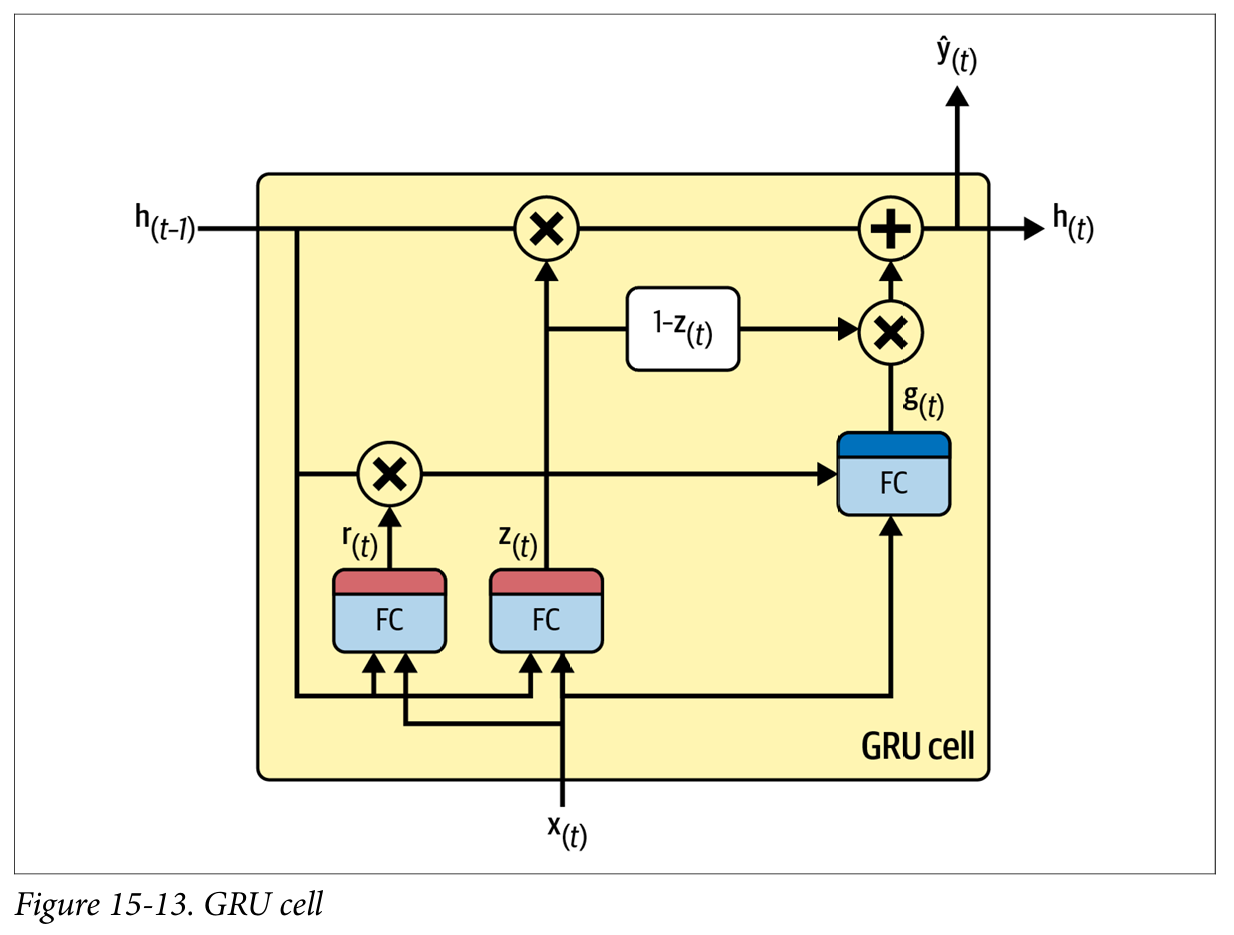

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

/home/ting/miniconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1305 - mae: 0.4107 - val_loss: 0.0191 - val_mae: 0.1610
Epoch 2/500


2025-05-29 03:00:07.421307: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:07.421344: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:07.421351: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:07.538694: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:07.538719: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:07.538725: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0169 - mae: 0.1495 - val_loss: 0.0156 - val_mae: 0.1339
Epoch 3/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0134 - mae: 0.1369 

2025-05-29 03:00:07.905352: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:07.905403: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:07.905413: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:07.905419: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:07.905424: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:07.946603: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:07.946651: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0133 - mae: 0.1338 - val_loss: 0.0138 - val_mae: 0.1245
Epoch 4/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0120 - mae: 0.1272 

2025-05-29 03:00:08.315539: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:08.315570: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:08.315577: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:08.315581: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:08.315584: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:08.354078: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:08.354105: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0118 - mae: 0.1248 - val_loss: 0.0126 - val_mae: 0.1185
Epoch 5/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0108 - mae: 0.1195 

2025-05-29 03:00:08.756629: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-29 03:00:08.756663: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:08.756669: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:08.756672: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0109 - mae: 0.1181 - val_loss: 0.0117 - val_mae: 0.1146
Epoch 6/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102 - mae: 0.1141 

2025-05-29 03:00:09.116318: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:09.155321: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:09.155344: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:09.155349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0102 - mae: 0.1131 - val_loss: 0.0112 - val_mae: 0.1121
Epoch 7/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097 - mae: 0.1104 

2025-05-29 03:00:09.567264: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:09.567294: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:09.567300: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0098 - mae: 0.1102 - val_loss: 0.0107 - val_mae: 0.1101
Epoch 8/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0093 - mae: 0.1080 

2025-05-29 03:00:09.932615: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:09.932646: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:09.932653: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:09.932657: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:09.932660: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:09.973977: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:09.974000: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0096 - mae: 0.1085 - val_loss: 0.0107 - val_mae: 0.1093
Epoch 9/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0088 - mae: 0.1041 

2025-05-29 03:00:10.356217: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:10.356251: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:10.356258: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:10.356262: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:10.356265: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:10.398227: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:10.398334: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0092 - mae: 0.1061 - val_loss: 0.0104 - val_mae: 0.1080
Epoch 10/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0089 - mae: 0.1043 

2025-05-29 03:00:10.779030: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:10.779067: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:10.779074: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:10.819484: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:10.819511: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:10.819518: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0091 - mae: 0.1050 - val_loss: 0.0101 - val_mae: 0.1066
Epoch 11/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0088 - mae: 0.1033 

2025-05-29 03:00:11.188938: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:11.188973: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:11.188979: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:11.230812: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:11.230842: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:11.230849: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0089 - mae: 0.1039 - val_loss: 0.0098 - val_mae: 0.1053
Epoch 12/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0084 - mae: 0.1015 

2025-05-29 03:00:11.603335: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:11.603372: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:11.603380: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:11.645624: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:11.645649: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:11.645654: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0088 - mae: 0.1028 - val_loss: 0.0097 - val_mae: 0.1044
Epoch 13/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - mae: 0.1015 

2025-05-29 03:00:12.026568: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:12.026607: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:12.026615: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:12.069807: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:12.069835: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:12.069843: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0088 - mae: 0.1024 - val_loss: 0.0097 - val_mae: 0.1044
Epoch 14/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0076 - mae: 0.0960

2025-05-29 03:00:12.444220: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:12.444283: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0085 - mae: 0.1006 - val_loss: 0.0094 - val_mae: 0.1026
Epoch 15/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0973 

2025-05-29 03:00:12.907855: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:12.907887: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:12.907894: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:12.907898: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:12.907901: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:12.949594: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:12.949623: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0084 - mae: 0.0998 - val_loss: 0.0094 - val_mae: 0.1025
Epoch 16/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0968 

2025-05-29 03:00:13.322327: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:13.322368: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:13.322375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:13.361608: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:13.361634: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:13.361641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083 - mae: 0.0991 - val_loss: 0.0093 - val_mae: 0.1016
Epoch 17/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - mae: 0.0968 

2025-05-29 03:00:13.710472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:13.710505: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:13.710512: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:13.749204: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:13.749230: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:13.749237: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0082 - mae: 0.0982 - val_loss: 0.0090 - val_mae: 0.1000
Epoch 18/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080 - mae: 0.0975 

2025-05-29 03:00:14.125226: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:14.125270: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:14.125279: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:14.125284: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:14.166155: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:14.166180: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:14.166186: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0082 - mae: 0.0982 - val_loss: 0.0091 - val_mae: 0.1000
Epoch 19/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - mae: 0.0960 

2025-05-29 03:00:14.537151: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:14.537190: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:14.537197: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:14.577153: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:14.577176: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:14.577182: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0081 - mae: 0.0971 - val_loss: 0.0089 - val_mae: 0.0989
Epoch 20/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0067 - mae: 0.0901

2025-05-29 03:00:14.950747: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:14.950779: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:14.950787: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:14.950791: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:14.950793: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:15.000194: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:15.000224: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0080 - mae: 0.0964 - val_loss: 0.0088 - val_mae: 0.0983
Epoch 21/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0933 

2025-05-29 03:00:15.358196: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:15.358234: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:15.358241: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:15.400134: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:15.400159: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:15.400164: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0078 - mae: 0.0951 - val_loss: 0.0087 - val_mae: 0.0973
Epoch 22/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - mae: 0.0926 

2025-05-29 03:00:15.770518: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:15.770557: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:15.770564: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:15.811477: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:15.811501: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:15.811507: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0078 - mae: 0.0945 - val_loss: 0.0086 - val_mae: 0.0967
Epoch 23/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - mae: 0.0915 

2025-05-29 03:00:16.184634: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:16.184669: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:16.184677: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:16.228585: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:16.228610: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:16.228616: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0077 - mae: 0.0937 - val_loss: 0.0085 - val_mae: 0.0957
Epoch 24/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0928 

2025-05-29 03:00:16.603919: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:16.603952: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:16.603960: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:16.642945: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:16.642969: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:16.642974: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0077 - mae: 0.0936 - val_loss: 0.0086 - val_mae: 0.0959
Epoch 25/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0062 - mae: 0.0854

2025-05-29 03:00:17.002433: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:17.002475: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:17.044586: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:17.044609: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:17.044615: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0075 - mae: 0.0921 - val_loss: 0.0084 - val_mae: 0.0945
Epoch 26/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0069 - mae: 0.0895

2025-05-29 03:00:17.420430: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:17.420469: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:17.420476: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:17.475897: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:17.475941: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:17.475968: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0076 - mae: 0.0923 - val_loss: 0.0081 - val_mae: 0.0930
Epoch 27/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - mae: 0.0906 

2025-05-29 03:00:17.844846: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:17.844878: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:17.844885: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:17.844889: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:17.844892: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:17.884854: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:17.884881: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0075 - mae: 0.0916 - val_loss: 0.0082 - val_mae: 0.0930
Epoch 28/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0884 

2025-05-29 03:00:18.270589: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:18.270621: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:18.270628: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:18.270632: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:18.270635: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:18.310870: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:18.310894: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0073 - mae: 0.0905 - val_loss: 0.0081 - val_mae: 0.0922
Epoch 29/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - mae: 0.0888 

2025-05-29 03:00:18.665949: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:18.665981: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:18.665988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:18.665992: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:18.665994: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:18.707864: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:18.707891: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0073 - mae: 0.0902 - val_loss: 0.0081 - val_mae: 0.0919
Epoch 30/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - mae: 0.0887 

2025-05-29 03:00:19.060253: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:19.060285: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:19.060293: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:19.060297: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:19.060300: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:19.099957: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:19.100141: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0073 - mae: 0.0897 - val_loss: 0.0080 - val_mae: 0.0912
Epoch 31/500
14/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mae: 0.0868

2025-05-29 03:00:19.495986: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:19.496018: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:19.496025: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - mae: 0.0884 - val_loss: 0.0078 - val_mae: 0.0900
Epoch 32/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0877 

2025-05-29 03:00:19.849714: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:19.849753: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:19.849760: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:19.892153: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:19.892178: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:19.892184: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - mae: 0.0885 - val_loss: 0.0078 - val_mae: 0.0897
Epoch 33/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0875 

2025-05-29 03:00:20.245861: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:20.245895: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:20.245903: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:20.286619: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:20.286794: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:20.286831: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - mae: 0.0879 - val_loss: 0.0078 - val_mae: 0.0897
Epoch 34/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mae: 0.0861 

2025-05-29 03:00:20.632441: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:20.632471: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:20.632479: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:20.632482: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:20.632485: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:20.673138: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:20.673167: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - mae: 0.0872 - val_loss: 0.0076 - val_mae: 0.0884
Epoch 35/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065 - mae: 0.0847 

2025-05-29 03:00:21.029261: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:21.029298: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:21.029305: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:21.067104: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:21.067130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:21.067136: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0866 - val_loss: 0.0076 - val_mae: 0.0879
Epoch 36/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mae: 0.0862 

2025-05-29 03:00:21.459042: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:21.459211: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:21.459236: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069 - mae: 0.0867 - val_loss: 0.0076 - val_mae: 0.0879
Epoch 37/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0863 

2025-05-29 03:00:21.861185: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:21.861222: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:21.861250: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069 - mae: 0.0864 - val_loss: 0.0076 - val_mae: 0.0874
Epoch 38/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065 - mae: 0.0840 

2025-05-29 03:00:22.247854: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:22.247893: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:22.247900: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:22.287309: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:22.287337: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:22.287344: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0067 - mae: 0.0849 - val_loss: 0.0074 - val_mae: 0.0864
Epoch 39/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - mae: 0.0846 

2025-05-29 03:00:22.651536: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:22.651570: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:22.651578: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:22.689868: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:22.689892: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:22.689898: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0068 - mae: 0.0852 - val_loss: 0.0073 - val_mae: 0.0857
Epoch 40/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063 - mae: 0.0827 

2025-05-29 03:00:23.059885: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:23.059924: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:23.059931: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:23.099957: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:23.099981: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:23.099986: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - mae: 0.0842 - val_loss: 0.0074 - val_mae: 0.0861
Epoch 41/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0063 - mae: 0.0821 

2025-05-29 03:00:23.458392: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:23.458423: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:23.458430: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:23.458434: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:23.458437: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:23.497566: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:23.497588: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0066 - mae: 0.0836 - val_loss: 0.0072 - val_mae: 0.0848
Epoch 42/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - mae: 0.0837 

2025-05-29 03:00:23.862884: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:23.902291: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:23.902313: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:23.902319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - mae: 0.0838 - val_loss: 0.0072 - val_mae: 0.0843
Epoch 43/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061 - mae: 0.0810 

2025-05-29 03:00:24.245323: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:24.245355: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:24.245362: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:24.245366: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:24.245369: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:24.295078: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:24.295117: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0064 - mae: 0.0826 - val_loss: 0.0070 - val_mae: 0.0834
Epoch 44/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0064 - mae: 0.0826 

2025-05-29 03:00:24.649649: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:24.649688: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:24.649695: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:24.691319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:24.691348: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:24.691355: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065 - mae: 0.0828 - val_loss: 0.0070 - val_mae: 0.0833
Epoch 45/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 - mae: 0.0803 

2025-05-29 03:00:25.043061: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:25.081455: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:25.081485: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:25.081502: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063 - mae: 0.0818 - val_loss: 0.0070 - val_mae: 0.0830
Epoch 46/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - mae: 0.0801 

2025-05-29 03:00:25.434450: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:25.473647: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:25.473676: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:25.473682: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063 - mae: 0.0817 - val_loss: 0.0070 - val_mae: 0.0828
Epoch 47/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 - mae: 0.0792 

2025-05-29 03:00:25.822623: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:25.822654: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:25.822661: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:25.822664: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:25.822667: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:25.862389: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:25.862550: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ -1s -21484us/step - loss: 0.0063 - mae: 0.0811 - val_loss: 0.0069 - val_mae: 0.0820
Epoch 48/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059 - mae: 0.0791 

2025-05-29 03:00:25.229616: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:25.229682: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:25.229703: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:25.229710: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:25.268940: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:25.268966: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:25.268973: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - mae: 0.0808 - val_loss: 0.0069 - val_mae: 0.0820
Epoch 49/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059 - mae: 0.0791 

2025-05-29 03:00:25.613202: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:25.613238: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:25.613246: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:25.660991: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:25.661016: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:25.661022: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - mae: 0.0803 - val_loss: 0.0067 - val_mae: 0.0811
Epoch 50/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061 - mae: 0.0800 

2025-05-29 03:00:26.015549: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:26.015581: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:26.015588: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:26.015592: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:26.015595: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:26.054868: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:26.054896: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062 - mae: 0.0804 - val_loss: 0.0067 - val_mae: 0.0807
Epoch 51/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061 - mae: 0.0799 

2025-05-29 03:00:26.420558: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:26.420596: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:26.420603: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:26.461480: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:26.461513: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:26.461519: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062 - mae: 0.0805 - val_loss: 0.0067 - val_mae: 0.0808
Epoch 52/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0059 - mae: 0.0785

2025-05-29 03:00:26.832795: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:26.871456: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:26.871488: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:26.871497: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061 - mae: 0.0795 - val_loss: 0.0066 - val_mae: 0.0800
Epoch 53/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062 - mae: 0.0804

2025-05-29 03:00:27.223148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:27.262511: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:27.262546: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:27.262553: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061 - mae: 0.0797 - val_loss: 0.0066 - val_mae: 0.0803
Epoch 54/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - mae: 0.0773 

2025-05-29 03:00:27.618993: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:27.619027: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:27.619033: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:27.619037: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:27.658066: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:27.658094: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:27.658102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060 - mae: 0.0787 - val_loss: 0.0065 - val_mae: 0.0795
Epoch 55/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0057 - mae: 0.0773 

2025-05-29 03:00:28.019765: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:28.019802: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:28.019810: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:28.019815: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:28.019819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:28.059940: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:28.059967: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060 - mae: 0.0788 - val_loss: 0.0066 - val_mae: 0.0797
Epoch 56/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0054 - mae: 0.0752

2025-05-29 03:00:28.421712: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:28.421750: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:28.421757: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:28.464382: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:28.464408: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:28.464416: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0059 - mae: 0.0778 - val_loss: 0.0065 - val_mae: 0.0796
Epoch 57/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056 - mae: 0.0762 

2025-05-29 03:00:28.829512: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:28.829544: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:28.829551: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:28.829555: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:28.829558: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:28.870458: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:28.870491: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059 - mae: 0.0776 - val_loss: 0.0064 - val_mae: 0.0787
Epoch 58/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mae: 0.0765 

2025-05-29 03:00:29.223593: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:29.223626: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:29.264804: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:29.264829: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:29.264836: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058 - mae: 0.0776 - val_loss: 0.0064 - val_mae: 0.0785
Epoch 59/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mae: 0.0764 

2025-05-29 03:00:29.636708: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:29.636746: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:29.636753: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:29.680187: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:29.680220: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:29.680226: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058 - mae: 0.0772 - val_loss: 0.0063 - val_mae: 0.0782
Epoch 60/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mae: 0.0763 

2025-05-29 03:00:30.090001: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:30.090031: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:30.090037: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058 - mae: 0.0770 - val_loss: 0.0063 - val_mae: 0.0780
Epoch 61/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - mae: 0.0756 

2025-05-29 03:00:30.460580: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:30.460623: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:30.460631: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:30.460635: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:30.501416: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:30.501441: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:30.501448: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058 - mae: 0.0771 - val_loss: 0.0064 - val_mae: 0.0785
Epoch 62/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - mae: 0.0760 

2025-05-29 03:00:30.867401: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:30.867434: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:30.867450: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:30.867456: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:30.867459: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:30.906948: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:30.906974: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058 - mae: 0.0767 - val_loss: 0.0063 - val_mae: 0.0779
Epoch 63/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0048 - mae: 0.0712

2025-05-29 03:00:31.279829: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:31.279884: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:31.279904: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:31.279910: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:31.319619: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:31.319644: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:31.319652: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0057 - mae: 0.0763 - val_loss: 0.0063 - val_mae: 0.0779
Epoch 64/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - mae: 0.0745 

2025-05-29 03:00:31.718342: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:31.718377: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:31.718383: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:31.758877: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:31.758902: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:31.758907: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056 - mae: 0.0754 - val_loss: 0.0061 - val_mae: 0.0768
Epoch 65/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - mae: 0.0746 

2025-05-29 03:00:32.135926: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:32.135957: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:32.135965: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:32.135968: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:32.135971: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:32.175275: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:32.175300: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056 - mae: 0.0754 - val_loss: 0.0061 - val_mae: 0.0769
Epoch 66/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0053 - mae: 0.0741 

2025-05-29 03:00:32.543004: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:32.543036: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:32.543043: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:32.543047: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:32.543050: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:32.593147: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:32.593179: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mae: 0.0753 - val_loss: 0.0061 - val_mae: 0.0769
Epoch 67/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - mae: 0.0760 

2025-05-29 03:00:32.949124: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:32.949169: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:32.949177: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:32.990382: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:32.990408: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:32.990414: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - mae: 0.0757 - val_loss: 0.0062 - val_mae: 0.0772
Epoch 68/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mae: 0.0719 

2025-05-29 03:00:33.346793: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:33.346823: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:33.346832: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:33.346835: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:33.346838: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:33.385898: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:33.385922: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - mae: 0.0742 - val_loss: 0.0061 - val_mae: 0.0764
Epoch 69/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0048 - mae: 0.0700

2025-05-29 03:00:33.745408: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:33.745442: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:33.787899: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:33.787927: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:33.787945: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055 - mae: 0.0745 - val_loss: 0.0060 - val_mae: 0.0757
Epoch 70/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - mae: 0.0727 

2025-05-29 03:00:34.149842: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:34.149882: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:34.149889: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:34.189705: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:34.189732: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:34.189739: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - mae: 0.0739 - val_loss: 0.0060 - val_mae: 0.0758
Epoch 71/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mae: 0.0725 

2025-05-29 03:00:34.559080: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:34.559117: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:34.559126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:34.559131: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:34.559134: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:34.599624: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:34.599649: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - mae: 0.0740 - val_loss: 0.0060 - val_mae: 0.0763
Epoch 72/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - mae: 0.0733 

2025-05-29 03:00:34.976399: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:34.976438: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:34.976445: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:35.025943: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:35.025972: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:35.025979: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - mae: 0.0738 - val_loss: 0.0060 - val_mae: 0.0759
Epoch 73/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mae: 0.0712 

2025-05-29 03:00:35.393393: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:35.393428: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:35.393434: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:35.393438: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:35.435293: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:35.435319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:35.435325: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - mae: 0.0734 - val_loss: 0.0059 - val_mae: 0.0752
Epoch 74/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mae: 0.0723 

2025-05-29 03:00:35.816803: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:35.816837: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:35.816844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:35.855668: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:35.855691: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:35.855697: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - mae: 0.0733 - val_loss: 0.0060 - val_mae: 0.0758
Epoch 75/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0053 - mae: 0.0728

2025-05-29 03:00:36.229227: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:36.229259: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:36.229266: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:36.229269: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:36.229272: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:36.270367: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:36.270400: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - mae: 0.0733 - val_loss: 0.0059 - val_mae: 0.0753
Epoch 76/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mae: 0.0711 

2025-05-29 03:00:36.640424: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:36.640463: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:36.640472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:36.640478: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:36.640482: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:36.680024: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:36.680051: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0053 - mae: 0.0727 - val_loss: 0.0058 - val_mae: 0.0750
Epoch 77/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0050 - mae: 0.0712 

2025-05-29 03:00:37.041990: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:37.042023: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:37.042030: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:37.080168: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:37.080197: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:37.080204: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0053 - mae: 0.0726 - val_loss: 0.0058 - val_mae: 0.0749
Epoch 78/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - mae: 0.0723 

2025-05-29 03:00:37.446812: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:37.446853: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:37.446860: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:37.488248: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:37.488277: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:37.488286: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0053 - mae: 0.0726 - val_loss: 0.0058 - val_mae: 0.0752
Epoch 79/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mae: 0.0707 

2025-05-29 03:00:37.847203: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:37.847236: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:37.847243: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:37.888122: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:37.888146: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:37.888152: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052 - mae: 0.0718 - val_loss: 0.0057 - val_mae: 0.0739
Epoch 80/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - mae: 0.0730 

2025-05-29 03:00:38.264959: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:38.265002: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:38.265011: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:38.308164: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:38.308196: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:38.308202: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0053 - mae: 0.0725 - val_loss: 0.0057 - val_mae: 0.0744
Epoch 81/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mae: 0.0711 

2025-05-29 03:00:38.679485: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:38.679519: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:38.679526: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:38.718574: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:38.718606: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:38.718615: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0051 - mae: 0.0716 - val_loss: 0.0058 - val_mae: 0.0748
Epoch 82/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0042 - mae: 0.0655

2025-05-29 03:00:39.096894: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:39.096945: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:39.096955: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:39.139168: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:39.139199: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:39.139206: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0051 - mae: 0.0714 - val_loss: 0.0057 - val_mae: 0.0744
Epoch 83/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - mae: 0.0688 

2025-05-29 03:00:39.555544: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:39.555575: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:39.555581: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mae: 0.0707 - val_loss: 0.0056 - val_mae: 0.0737
Epoch 84/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - mae: 0.0704 

2025-05-29 03:00:39.913992: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:39.914026: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:39.914033: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:39.954233: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:39.954265: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:39.954273: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mae: 0.0712 - val_loss: 0.0057 - val_mae: 0.0741
Epoch 85/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mae: 0.0680 

2025-05-29 03:00:40.298906: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:40.298939: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:40.337786: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:40.337811: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:40.337818: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050 - mae: 0.0704 - val_loss: 0.0056 - val_mae: 0.0735
Epoch 86/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - mae: 0.0699 

2025-05-29 03:00:40.700330: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:40.700369: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:40.700380: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:40.700385: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:40.700389: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:40.740170: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:40.740193: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - mae: 0.0708 - val_loss: 0.0055 - val_mae: 0.0732
Epoch 87/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050 - mae: 0.0703

2025-05-29 03:00:41.095184: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:41.095217: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:41.095225: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:41.095228: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:41.095231: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:41.134063: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:41.134088: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mae: 0.0706 - val_loss: 0.0055 - val_mae: 0.0732
Epoch 88/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0047 - mae: 0.0687 

2025-05-29 03:00:41.483592: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:41.483622: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:41.483630: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:41.483633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:41.483636: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:41.523335: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:41.523361: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050 - mae: 0.0700 - val_loss: 0.0055 - val_mae: 0.0730
Epoch 89/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0047 - mae: 0.0690 

2025-05-29 03:00:41.881448: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:41.881488: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:41.881498: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:41.881503: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:41.881507: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:41.925597: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:41.925628: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mae: 0.0701 - val_loss: 0.0056 - val_mae: 0.0735
Epoch 90/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mae: 0.0688 

2025-05-29 03:00:42.269392: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:42.269428: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:42.269437: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:42.269441: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:42.269445: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:42.310608: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:42.310633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mae: 0.0699 - val_loss: 0.0055 - val_mae: 0.0731
Epoch 91/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - mae: 0.0669

2025-05-29 03:00:42.664203: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:42.664242: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:42.664249: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:42.704697: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:42.704721: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:42.704726: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mae: 0.0692 - val_loss: 0.0054 - val_mae: 0.0723
Epoch 92/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - mae: 0.0696 

2025-05-29 03:00:43.056194: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:43.094542: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:43.094570: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:43.094731: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mae: 0.0700 - val_loss: 0.0055 - val_mae: 0.0729
Epoch 93/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mae: 0.0678 

2025-05-29 03:00:43.438542: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:43.438574: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:43.438581: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:43.438585: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:43.438587: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:43.478993: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:43.479017: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - mae: 0.0692 - val_loss: 0.0054 - val_mae: 0.0723
Epoch 94/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mae: 0.0677 

2025-05-29 03:00:43.821313: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:43.821345: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:43.821352: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:43.821356: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:43.821358: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:43.863175: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:43.863202: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - mae: 0.0691 - val_loss: 0.0054 - val_mae: 0.0719
Epoch 95/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mae: 0.0688 

2025-05-29 03:00:44.207905: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:44.207939: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:44.207946: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:44.258171: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:44.258200: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:44.258370: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - mae: 0.0694 - val_loss: 0.0054 - val_mae: 0.0719
Epoch 96/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - mae: 0.0680 

2025-05-29 03:00:44.623870: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:44.623911: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:44.623919: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:44.663463: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:44.663497: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:44.663505: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - mae: 0.0690 - val_loss: 0.0054 - val_mae: 0.0720
Epoch 97/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mae: 0.0668 

2025-05-29 03:00:45.019020: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:45.019052: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:45.019059: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:45.019063: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:45.019066: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:45.061002: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:45.061026: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - mae: 0.0684 - val_loss: 0.0053 - val_mae: 0.0717
Epoch 98/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mae: 0.0678 

2025-05-29 03:00:45.441021: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:45.441052: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:45.441059: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:45.441062: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:45.441065: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:45.481079: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:45.481102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - mae: 0.0687 - val_loss: 0.0053 - val_mae: 0.0715
Epoch 99/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mae: 0.0678 

2025-05-29 03:00:45.854493: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:45.854529: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:45.854537: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:45.896133: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:45.896157: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:45.896162: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - mae: 0.0687 - val_loss: 0.0053 - val_mae: 0.0718
Epoch 100/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mae: 0.0670 

2025-05-29 03:00:46.271511: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:46.271543: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:46.271551: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:46.271555: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:46.271558: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:46.311796: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:46.311991: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - mae: 0.0679 - val_loss: 0.0052 - val_mae: 0.0710
Epoch 101/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mae: 0.0675 

2025-05-29 03:00:46.678516: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:46.678563: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:46.678572: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:46.678578: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:46.718785: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:46.718813: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - mae: 0.0682 - val_loss: 0.0053 - val_mae: 0.0710
Epoch 102/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mae: 0.0668 

2025-05-29 03:00:47.087237: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:47.087273: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:47.087280: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:47.126846: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:47.126875: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:47.126882: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - mae: 0.0680 - val_loss: 0.0052 - val_mae: 0.0703
Epoch 103/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mae: 0.0664 

2025-05-29 03:00:47.490302: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:47.490333: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:47.490341: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:47.490344: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:47.490347: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:47.532206: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:47.532230: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - mae: 0.0679 - val_loss: 0.0053 - val_mae: 0.0717
Epoch 104/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mae: 0.0660 

2025-05-29 03:00:47.903320: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:47.903355: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:47.903364: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:47.903369: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:47.903372: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:47.942401: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:47.942424: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - mae: 0.0674 - val_loss: 0.0052 - val_mae: 0.0710
Epoch 105/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - mae: 0.0654 

2025-05-29 03:00:48.317884: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:48.317917: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:48.317925: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:48.317929: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:48.317932: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:48.355797: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:48.355822: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - mae: 0.0674 - val_loss: 0.0052 - val_mae: 0.0712
Epoch 106/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mae: 0.0656 

2025-05-29 03:00:48.722957: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:48.722991: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:48.723001: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:48.723006: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:48.723010: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:48.769317: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:48.769377: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - mae: 0.0672 - val_loss: 0.0052 - val_mae: 0.0705
Epoch 107/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mae: 0.0661 

2025-05-29 03:00:49.140532: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:49.140570: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:49.140577: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:49.181588: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:49.181612: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:49.181618: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - mae: 0.0672 - val_loss: 0.0051 - val_mae: 0.0702
Epoch 108/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - mae: 0.0659 

2025-05-29 03:00:49.557815: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:49.557850: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:49.557858: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:49.596470: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:49.596494: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:49.596500: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - mae: 0.0670 - val_loss: 0.0051 - val_mae: 0.0699
Epoch 109/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - mae: 0.0660 

2025-05-29 03:00:49.957136: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:49.957168: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:49.957175: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:49.957179: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:49.957182: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:49.996635: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:49.996659: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - mae: 0.0672 - val_loss: 0.0052 - val_mae: 0.0709
Epoch 110/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mae: 0.0646 

2025-05-29 03:00:50.366123: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:50.366159: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:50.366167: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:50.366171: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:50.366174: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:50.404532: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:50.404559: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - mae: 0.0665 - val_loss: 0.0050 - val_mae: 0.0691
Epoch 111/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - mae: 0.0676 

2025-05-29 03:00:50.776381: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:50.776412: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:50.776420: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:50.776425: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:50.776428: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:50.817223: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:50.817250: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - mae: 0.0674 - val_loss: 0.0051 - val_mae: 0.0700
Epoch 112/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0041 - mae: 0.0630

2025-05-29 03:00:51.187079: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:51.187123: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:51.187132: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:51.187136: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:51.236348: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:51.236378: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:51.236386: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - mae: 0.0668 - val_loss: 0.0051 - val_mae: 0.0696
Epoch 113/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0036 - mae: 0.0608

2025-05-29 03:00:51.605685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:51.605723: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:51.605730: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:51.646463: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:51.646490: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:51.646497: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - mae: 0.0664 - val_loss: 0.0051 - val_mae: 0.0701
Epoch 114/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mae: 0.0643 

2025-05-29 03:00:52.012952: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:52.012983: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:52.012991: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:52.012995: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:52.012998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:52.052415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:52.052439: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - mae: 0.0659 - val_loss: 0.0050 - val_mae: 0.0695
Epoch 115/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - mae: 0.0657 

2025-05-29 03:00:52.419305: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:52.419343: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:52.419349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:52.460820: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:52.460845: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:52.460852: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - mae: 0.0662 - val_loss: 0.0050 - val_mae: 0.0694
Epoch 116/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - mae: 0.0654 

2025-05-29 03:00:52.823294: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:52.823331: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:52.823339: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:52.823344: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:52.823349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:52.862496: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:52.862522: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - mae: 0.0661 - val_loss: 0.0050 - val_mae: 0.0693
Epoch 117/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mae: 0.0637 

2025-05-29 03:00:53.224799: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:53.224834: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:53.224843: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:53.224847: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:53.224850: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:53.264184: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:53.264207: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - mae: 0.0655 - val_loss: 0.0050 - val_mae: 0.0687
Epoch 118/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mae: 0.0637 

2025-05-29 03:00:53.624862: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:53.624896: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:53.624904: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:53.664732: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:53.664758: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:53.664764: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - mae: 0.0652 - val_loss: 0.0049 - val_mae: 0.0683
Epoch 119/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - mae: 0.0651

2025-05-29 03:00:54.036145: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:54.036181: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:54.036189: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:54.077393: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:54.077421: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:54.077428: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - mae: 0.0657 - val_loss: 0.0049 - val_mae: 0.0683
Epoch 120/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - mae: 0.0630 

2025-05-29 03:00:54.453691: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:54.453726: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:54.453732: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:54.494807: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:54.494831: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:54.494837: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - mae: 0.0650 - val_loss: 0.0049 - val_mae: 0.0685
Epoch 121/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0630 

2025-05-29 03:00:54.853328: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:54.853362: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:54.853370: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:54.853373: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:54.853376: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:54.892195: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:54.892218: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - mae: 0.0648 - val_loss: 0.0049 - val_mae: 0.0680
Epoch 122/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mae: 0.0646 

2025-05-29 03:00:55.259650: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:55.259681: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:55.259689: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:55.259692: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:55.259695: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:55.300198: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:55.300222: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - mae: 0.0653 - val_loss: 0.0049 - val_mae: 0.0681
Epoch 123/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mae: 0.0629 

2025-05-29 03:00:55.655147: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:55.655178: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:55.655186: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:55.655189: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:55.655192: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - mae: 0.0644 - val_loss: 0.0048 - val_mae: 0.0674
Epoch 124/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0038 - mae: 0.0610

2025-05-29 03:00:56.060346: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:56.060381: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:56.101730: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:56.101755: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:56.101762: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - mae: 0.0647 - val_loss: 0.0048 - val_mae: 0.0676
Epoch 125/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mae: 0.0631 

2025-05-29 03:00:56.481543: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:56.481582: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:56.481593: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:56.481598: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:56.481602: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:56.524349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:56.524375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - mae: 0.0643 - val_loss: 0.0048 - val_mae: 0.0673
Epoch 126/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0630 

2025-05-29 03:00:56.879375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:56.879410: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:56.879417: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:56.920605: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:56.920641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:56.920647: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - mae: 0.0643 - val_loss: 0.0048 - val_mae: 0.0672
Epoch 127/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0625        

2025-05-29 03:00:57.304848: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:57.304879: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:57.304886: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:57.304891: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:57.304894: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:57.345229: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:57.345260: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ -1s 10ms/step - loss: 0.0043 - mae: 0.0638 - val_loss: 0.0048 - val_mae: 0.0669
Epoch 128/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0620 

2025-05-29 03:00:56.707055: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:56.707086: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:56.707093: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:56.707099: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:56.707102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:56.750141: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:56.750171: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - mae: 0.0635 - val_loss: 0.0048 - val_mae: 0.0667
Epoch 129/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0625 

2025-05-29 03:00:57.120298: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:57.120333: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:57.120342: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:57.120346: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:57.120350: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:57.168982: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:57.169010: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - mae: 0.0638 - val_loss: 0.0047 - val_mae: 0.0666
Epoch 130/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0622 

2025-05-29 03:00:57.527783: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:57.527815: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:57.527822: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:57.527826: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:57.527829: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:57.567844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:57.567872: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - mae: 0.0636 - val_loss: 0.0047 - val_mae: 0.0662
Epoch 131/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mae: 0.0639 

2025-05-29 03:00:57.932662: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:57.932698: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:57.932705: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:57.972555: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:57.972583: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:57.972590: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - mae: 0.0640 - val_loss: 0.0047 - val_mae: 0.0660
Epoch 132/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mae: 0.0636 

2025-05-29 03:00:58.337068: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:58.337107: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:58.337114: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:58.337118: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:58.375998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:58.376031: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:58.376038: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - mae: 0.0636 - val_loss: 0.0047 - val_mae: 0.0658
Epoch 133/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0618 

2025-05-29 03:00:58.754356: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:58.754392: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:58.754400: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:58.793412: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:58.793434: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:58.793440: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - mae: 0.0630 - val_loss: 0.0047 - val_mae: 0.0657
Epoch 134/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mae: 0.0625

2025-05-29 03:00:59.169722: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:59.169765: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:59.169773: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:59.209357: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:59.209389: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:00:59.209398: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - mae: 0.0632 - val_loss: 0.0047 - val_mae: 0.0657
Epoch 135/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - mae: 0.0622 

2025-05-29 03:00:59.577875: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:00:59.577906: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:00:59.577915: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:59.577919: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:59.577921: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:00:59.621582: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:00:59.621619: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - mae: 0.0631 - val_loss: 0.0046 - val_mae: 0.0655
Epoch 136/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0036 - mae: 0.0591

2025-05-29 03:00:59.987711: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:00:59.987749: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:00:59.987756: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:00.034103: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:00.034132: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:00.034139: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - mae: 0.0628 - val_loss: 0.0046 - val_mae: 0.0652
Epoch 137/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mae: 0.0611 

2025-05-29 03:01:00.411367: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:00.411399: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:00.411407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:00.411410: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:00.411413: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:00.454426: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:00.454460: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - mae: 0.0626 - val_loss: 0.0046 - val_mae: 0.0652
Epoch 138/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0037 - mae: 0.0597

2025-05-29 03:01:00.838397: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:00.838431: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:00.838439: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:00.838443: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:00.838446: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:00.884892: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:00.884920: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - mae: 0.0628 - val_loss: 0.0046 - val_mae: 0.0652
Epoch 139/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mae: 0.0609 

2025-05-29 03:01:01.264909: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:01.264948: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:01.264955: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:01.304347: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:01.304375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:01.304382: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mae: 0.0621 - val_loss: 0.0045 - val_mae: 0.0643
Epoch 140/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0617 

2025-05-29 03:01:01.654505: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:01.654540: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:01.654549: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:01.654554: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:01.654558: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mae: 0.0624 - val_loss: 0.0046 - val_mae: 0.0650
Epoch 141/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mae: 0.0607 

2025-05-29 03:01:02.057334: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:02.057366: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:02.057373: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:02.057378: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:02.057381: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:02.098016: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:02.098040: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mae: 0.0619 - val_loss: 0.0046 - val_mae: 0.0648
Epoch 142/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037 - mae: 0.0596 

2025-05-29 03:01:02.457152: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:02.457185: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:02.457194: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:02.457199: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:02.457204: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:02.499174: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:02.499199: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mae: 0.0616 - val_loss: 0.0045 - val_mae: 0.0641
Epoch 143/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - mae: 0.0615 

2025-05-29 03:01:02.842444: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:02.842479: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:02.842487: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:02.881797: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:02.881833: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:02.881840: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mae: 0.0620 - val_loss: 0.0045 - val_mae: 0.0643
Epoch 144/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mae: 0.0604 

2025-05-29 03:01:03.227815: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:03.227848: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:03.227855: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:03.267683: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:03.267707: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:03.267712: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mae: 0.0616 - val_loss: 0.0045 - val_mae: 0.0641
Epoch 145/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mae: 0.0611 

2025-05-29 03:01:03.622500: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:03.622532: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:03.622539: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:03.622543: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:03.622546: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:03.662366: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:03.662392: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - mae: 0.0617 - val_loss: 0.0045 - val_mae: 0.0638
Epoch 146/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0597 

2025-05-29 03:01:04.016829: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:04.016873: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:04.016882: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:04.016887: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:04.067319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:04.067472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:04.067501: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0609 - val_loss: 0.0045 - val_mae: 0.0635
Epoch 147/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mae: 0.0601 

2025-05-29 03:01:04.421877: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:04.421915: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:04.421922: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:04.461449: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:04.461483: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:04.461656: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mae: 0.0612 - val_loss: 0.0045 - val_mae: 0.0634
Epoch 148/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0037 - mae: 0.0594 

2025-05-29 03:01:04.810967: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:04.810998: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:04.811006: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:04.811009: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:04.811012: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:04.850042: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:04.850065: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0040 - mae: 0.0607 - val_loss: 0.0044 - val_mae: 0.0633
Epoch 149/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0035 - mae: 0.0573

2025-05-29 03:01:05.242974: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:05.243043: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:05.243052: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:05.292327: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:05.292380: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:05.292389: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - mae: 0.0608 - val_loss: 0.0044 - val_mae: 0.0628
Epoch 150/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mae: 0.0605 

2025-05-29 03:01:05.687153: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:05.732243: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:05.732273: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:05.732279: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0608 - val_loss: 0.0044 - val_mae: 0.0630
Epoch 151/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - mae: 0.0596

2025-05-29 03:01:06.088701: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:06.088746: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:06.088755: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:06.127107: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:06.127131: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:06.127138: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - mae: 0.0606 - val_loss: 0.0044 - val_mae: 0.0628
Epoch 152/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - mae: 0.0597 

2025-05-29 03:01:06.504233: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:06.504269: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:06.504276: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:06.504280: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:06.545106: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:06.545130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:06.545136: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - mae: 0.0603 - val_loss: 0.0044 - val_mae: 0.0622
Epoch 153/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0032 - mae: 0.0557

2025-05-29 03:01:06.914756: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:06.914788: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:06.914796: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:06.914800: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:06.914803: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:06.954755: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:06.954782: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - mae: 0.0604 - val_loss: 0.0044 - val_mae: 0.0628
Epoch 154/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mae: 0.0595 

2025-05-29 03:01:07.329764: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:07.329802: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:07.329809: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:07.371289: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:07.371312: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:07.371318: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - mae: 0.0601 - val_loss: 0.0043 - val_mae: 0.0620
Epoch 155/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0592 

2025-05-29 03:01:07.745649: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:07.745684: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:07.745693: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:07.745697: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:07.745701: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:07.787870: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:07.787898: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - mae: 0.0599 - val_loss: 0.0044 - val_mae: 0.0623
Epoch 156/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0583 

2025-05-29 03:01:08.172730: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:08.172767: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:08.172774: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:08.213762: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:08.213786: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:08.213792: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - mae: 0.0596 - val_loss: 0.0043 - val_mae: 0.0618
Epoch 157/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0032 - mae: 0.0561

2025-05-29 03:01:08.587137: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:08.587173: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:08.587183: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:08.587188: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:08.587191: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - mae: 0.0595 - val_loss: 0.0043 - val_mae: 0.0617
Epoch 158/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0033 - mae: 0.0563

2025-05-29 03:01:09.001711: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:09.001755: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:09.001763: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:09.001769: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:09.051131: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:09.051164: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:09.051179: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mae: 0.0596 - val_loss: 0.0043 - val_mae: 0.0619
Epoch 159/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - mae: 0.0569 

2025-05-29 03:01:09.408996: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:09.409031: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:09.409038: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:09.449491: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:09.449515: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:09.449520: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mae: 0.0587 - val_loss: 0.0043 - val_mae: 0.0617
Epoch 160/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0582 

2025-05-29 03:01:09.796403: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:09.796437: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:09.796445: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:09.836376: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:09.836400: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:09.836406: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mae: 0.0590 - val_loss: 0.0043 - val_mae: 0.0613
Epoch 161/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0577 

2025-05-29 03:01:10.187992: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:10.188023: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:10.188030: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:10.188034: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:10.188037: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:10.227736: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:10.227761: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - mae: 0.0592 - val_loss: 0.0043 - val_mae: 0.0617
Epoch 162/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0583 

2025-05-29 03:01:10.599302: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:10.599336: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:10.599382: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:10.599394: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:10.599399: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:10.640310: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:10.640333: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mae: 0.0588 - val_loss: 0.0043 - val_mae: 0.0611
Epoch 163/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0574 

2025-05-29 03:01:10.988988: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:10.989019: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:10.989026: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:10.989030: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:10.989033: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:11.037494: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:11.037615: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - mae: 0.0589 - val_loss: 0.0042 - val_mae: 0.0609
Epoch 164/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0578 

2025-05-29 03:01:11.392592: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:11.392625: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:11.392633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:11.392636: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:11.392639: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:11.435658: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:11.435862: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mae: 0.0589 - val_loss: 0.0043 - val_mae: 0.0610
Epoch 165/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0585 

2025-05-29 03:01:11.787792: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:11.825435: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:11.825459: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:11.825465: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - mae: 0.0587 - val_loss: 0.0042 - val_mae: 0.0604
Epoch 166/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0585 

2025-05-29 03:01:12.181405: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:12.181437: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:12.181444: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:12.181448: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:12.181450: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:12.219991: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:12.220018: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - mae: 0.0591 - val_loss: 0.0042 - val_mae: 0.0608
Epoch 167/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0581 

2025-05-29 03:01:12.583836: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:12.583878: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:12.583886: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:12.627603: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:12.627631: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:12.627638: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mae: 0.0585 - val_loss: 0.0042 - val_mae: 0.0605
Epoch 168/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0567 

2025-05-29 03:01:13.022992: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:13.023023: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:13.023029: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - mae: 0.0581 - val_loss: 0.0042 - val_mae: 0.0603
Epoch 169/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0562 

2025-05-29 03:01:13.377886: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:13.377918: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:13.377925: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:13.377929: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:13.377932: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:13.421294: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:13.421325: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - mae: 0.0581 - val_loss: 0.0042 - val_mae: 0.0605
Epoch 170/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0571 

2025-05-29 03:01:13.779850: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:13.779881: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:13.779888: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:13.779892: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:13.779895: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:13.819749: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:13.819777: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - mae: 0.0580 - val_loss: 0.0042 - val_mae: 0.0603
Epoch 171/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - mae: 0.0559 

2025-05-29 03:01:14.192062: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:14.192119: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:14.192134: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:14.192138: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:14.233181: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:14.233204: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:14.233210: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0576 - val_loss: 0.0042 - val_mae: 0.0604
Epoch 172/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0570 

2025-05-29 03:01:14.605358: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:14.605397: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:14.605404: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:14.643694: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:14.643717: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:14.643733: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - mae: 0.0578 - val_loss: 0.0042 - val_mae: 0.0598
Epoch 173/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0568 

2025-05-29 03:01:15.008400: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:15.008438: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:15.008446: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:15.047705: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:15.047731: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:15.047738: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - mae: 0.0580 - val_loss: 0.0042 - val_mae: 0.0599
Epoch 174/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0564 

2025-05-29 03:01:15.413950: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:15.413988: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:15.413996: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:15.414000: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:15.414003: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:15.457641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:15.457665: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0575 - val_loss: 0.0041 - val_mae: 0.0595
Epoch 175/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0031 - mae: 0.0541

2025-05-29 03:01:15.820865: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:15.820903: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:15.820910: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:15.872009: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:15.872039: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:15.872045: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0575 - val_loss: 0.0041 - val_mae: 0.0594
Epoch 176/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0564

2025-05-29 03:01:16.254795: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:16.254833: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:16.254841: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:16.296226: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:16.296251: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:16.296258: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0574 - val_loss: 0.0041 - val_mae: 0.0597
Epoch 177/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0578 

2025-05-29 03:01:16.674025: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:16.674060: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:16.674068: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:16.715908: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:16.715940: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:16.715949: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - mae: 0.0578 - val_loss: 0.0042 - val_mae: 0.0596
Epoch 178/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - mae: 0.0568 

2025-05-29 03:01:17.074679: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:17.074721: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:17.074732: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:17.074738: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:17.074742: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:17.117338: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:17.117369: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - mae: 0.0576 - val_loss: 0.0041 - val_mae: 0.0593
Epoch 179/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0562 

2025-05-29 03:01:17.492507: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:17.492540: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:17.492547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:17.533590: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:17.533619: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:17.533627: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0573 - val_loss: 0.0042 - val_mae: 0.0596
Epoch 180/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0565

2025-05-29 03:01:17.900367: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:17.900406: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:17.900416: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:17.900421: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:17.900426: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:17.941161: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:17.941185: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0573 - val_loss: 0.0041 - val_mae: 0.0591
Epoch 181/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0567 

2025-05-29 03:01:18.323104: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:18.323150: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:18.323158: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:18.323164: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:18.365798: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:18.365823: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:18.365830: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - mae: 0.0574 - val_loss: 0.0041 - val_mae: 0.0593
Epoch 182/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0557 

2025-05-29 03:01:18.736557: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:18.736599: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:18.736607: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:18.778187: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:18.778211: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:18.778217: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0568 - val_loss: 0.0041 - val_mae: 0.0588
Epoch 183/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0554 

2025-05-29 03:01:19.148501: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:19.148535: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:19.148543: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:19.148547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:19.148549: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:19.190593: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:19.190618: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0568 - val_loss: 0.0041 - val_mae: 0.0592
Epoch 184/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0557 

2025-05-29 03:01:19.561789: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:19.561819: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:19.561827: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:19.561830: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:19.561833: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:19.602951: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:19.602975: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0566 - val_loss: 0.0041 - val_mae: 0.0587
Epoch 185/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0553

2025-05-29 03:01:19.983286: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:19.983325: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:19.983333: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:20.023489: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:20.023512: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:20.023518: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0563 - val_loss: 0.0042 - val_mae: 0.0594
Epoch 186/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0555 

2025-05-29 03:01:20.392639: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:20.392673: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:20.392680: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0564 - val_loss: 0.0041 - val_mae: 0.0587
Epoch 187/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0559 

2025-05-29 03:01:20.803260: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:20.803292: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:20.803299: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:20.803303: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:20.803306: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:20.843140: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:20.843164: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0566 - val_loss: 0.0041 - val_mae: 0.0590
Epoch 188/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0548

2025-05-29 03:01:21.208608: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:21.208643: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:21.208649: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:21.250834: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:21.250861: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:21.250868: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0564 - val_loss: 0.0041 - val_mae: 0.0584
Epoch 189/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0552 

2025-05-29 03:01:21.614383: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:21.614417: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:21.652978: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:21.653002: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:21.653014: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0562 - val_loss: 0.0041 - val_mae: 0.0582
Epoch 190/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0564 

2025-05-29 03:01:22.024008: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:22.024047: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:22.024055: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:22.064309: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:22.064337: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:22.064345: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0567 - val_loss: 0.0041 - val_mae: 0.0584
Epoch 191/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0559 

2025-05-29 03:01:22.435259: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:22.435304: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:22.435313: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:22.435319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:22.474940: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:22.474963: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:22.474969: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0566 - val_loss: 0.0041 - val_mae: 0.0583
Epoch 192/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0029 - mae: 0.0516

2025-05-29 03:01:22.836661: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:22.836700: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:22.836709: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:22.886357: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:22.886387: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:22.886394: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0559 - val_loss: 0.0041 - val_mae: 0.0584
Epoch 193/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0552 

2025-05-29 03:01:23.258455: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:23.258489: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:23.258495: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:23.298750: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:23.298780: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:23.298787: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0562 - val_loss: 0.0041 - val_mae: 0.0580
Epoch 194/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0559 

2025-05-29 03:01:23.680869: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:23.680902: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:23.680908: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:23.720511: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:23.720534: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:23.720541: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0565 - val_loss: 0.0041 - val_mae: 0.0581
Epoch 195/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0555 

2025-05-29 03:01:24.098963: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:24.099000: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:24.099009: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:24.140131: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:24.140156: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:24.140162: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0562 - val_loss: 0.0040 - val_mae: 0.0579
Epoch 196/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0542 

2025-05-29 03:01:24.505890: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:24.505926: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:24.505935: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:24.505939: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:24.505943: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:24.546243: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:24.546271: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0558 - val_loss: 0.0041 - val_mae: 0.0581
Epoch 197/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0553

2025-05-29 03:01:24.934823: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:24.934855: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:24.934863: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:24.934867: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:24.934870: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:24.972971: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:24.973005: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0558 - val_loss: 0.0041 - val_mae: 0.0579
Epoch 198/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0550 

2025-05-29 03:01:25.345098: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:25.345139: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:25.345149: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:25.345154: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:25.345158: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:25.384730: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:25.384756: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - mae: 0.0556 - val_loss: 0.0040 - val_mae: 0.0577
Epoch 199/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0552 

2025-05-29 03:01:25.777562: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:25.777599: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:25.777607: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:25.818535: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:25.818558: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:25.818564: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - mae: 0.0560 - val_loss: 0.0040 - val_mae: 0.0578
Epoch 200/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - mae: 0.0544 

2025-05-29 03:01:26.201539: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:26.201573: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:26.201580: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:26.241421: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:26.241449: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:26.241457: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0555 - val_loss: 0.0040 - val_mae: 0.0574
Epoch 201/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0556 

2025-05-29 03:01:26.611674: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:26.611713: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:26.611720: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:26.652688: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:26.652714: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:26.652993: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0559 - val_loss: 0.0041 - val_mae: 0.0580
Epoch 202/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0539 

2025-05-29 03:01:27.018349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:27.018392: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:27.018401: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:27.060658: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:27.060685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:27.060691: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0553 - val_loss: 0.0040 - val_mae: 0.0573
Epoch 203/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0029 - mae: 0.0519

2025-05-29 03:01:27.426147: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:27.426181: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0556 - val_loss: 0.0040 - val_mae: 0.0576
Epoch 204/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - mae: 0.0545 

2025-05-29 03:01:27.823838: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:27.823875: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:27.823882: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:27.870737: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:27.870773: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:27.870780: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0554 - val_loss: 0.0040 - val_mae: 0.0572
Epoch 205/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0538

2025-05-29 03:01:28.214818: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:28.214852: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:28.214859: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:28.253486: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:28.253510: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:28.253516: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0551 - val_loss: 0.0040 - val_mae: 0.0572
Epoch 206/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - mae: 0.0553        

2025-05-29 03:01:28.607209: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:28.647498: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:28.647524: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:28.647531: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ -1s 9ms/step - loss: 0.0036 - mae: 0.0557 - val_loss: 0.0040 - val_mae: 0.0574
Epoch 207/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0563 

2025-05-29 03:01:27.925711: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:27.925743: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:27.925750: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:27.925754: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:27.925757: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:27.964036: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:27.964064: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0560 - val_loss: 0.0040 - val_mae: 0.0570
Epoch 208/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0556 

2025-05-29 03:01:28.332927: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:28.333157: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:28.333166: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:28.333170: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:28.333193: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:28.373323: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:28.373487: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0556 - val_loss: 0.0040 - val_mae: 0.0571
Epoch 209/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0029 - mae: 0.0525

2025-05-29 03:01:28.720090: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:28.720122: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:28.720129: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:28.720133: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:28.720136: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:28.769252: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:28.769280: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0556 - val_loss: 0.0040 - val_mae: 0.0570
Epoch 210/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0546 

2025-05-29 03:01:29.127016: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:29.127049: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:29.167233: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:29.167256: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:29.167262: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0552 - val_loss: 0.0040 - val_mae: 0.0568
Epoch 211/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0542 

2025-05-29 03:01:29.523583: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:29.523623: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:29.523633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:29.523638: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:29.523642: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:29.563002: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:29.563025: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0550 - val_loss: 0.0040 - val_mae: 0.0570
Epoch 212/500
12/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0547

2025-05-29 03:01:29.953374: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:29.953404: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:29.953410: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0554 - val_loss: 0.0040 - val_mae: 0.0570
Epoch 213/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0544 

2025-05-29 03:01:30.307251: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:30.307288: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:30.307333: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:30.351162: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:30.351195: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:30.351201: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0551 - val_loss: 0.0040 - val_mae: 0.0570
Epoch 214/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0525 

2025-05-29 03:01:30.711337: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:30.711368: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:30.711375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:30.711378: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:30.711382: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:30.749508: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:30.749532: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0541 - val_loss: 0.0039 - val_mae: 0.0566
Epoch 215/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0539

2025-05-29 03:01:31.110209: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:31.110243: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:31.110249: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:31.110252: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:31.152384: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:31.152571: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:31.152607: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0551 - val_loss: 0.0040 - val_mae: 0.0567
Epoch 216/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0555 

2025-05-29 03:01:31.514621: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:31.514653: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:31.514662: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:31.514665: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:31.514668: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:31.555120: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:31.555148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0550 - val_loss: 0.0039 - val_mae: 0.0565
Epoch 217/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0537

2025-05-29 03:01:31.964074: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:31.964133: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:31.964141: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0549 - val_loss: 0.0040 - val_mae: 0.0565
Epoch 218/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0541 

2025-05-29 03:01:32.331102: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:32.331145: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:32.331154: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:32.331158: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:32.374693: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:32.374720: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:32.374727: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0546 - val_loss: 0.0039 - val_mae: 0.0563
Epoch 219/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0542 

2025-05-29 03:01:32.750937: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:32.750974: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:32.750981: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:32.792307: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:32.792331: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:32.792337: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0546 - val_loss: 0.0039 - val_mae: 0.0563
Epoch 220/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0543 

2025-05-29 03:01:33.172992: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:33.173023: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:33.173031: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:33.173035: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:33.173038: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0548 - val_loss: 0.0039 - val_mae: 0.0563
Epoch 221/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0563 

2025-05-29 03:01:33.566726: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:33.566757: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:33.566764: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:33.566767: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:33.566771: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:33.606150: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:33.606176: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0554 - val_loss: 0.0039 - val_mae: 0.0563
Epoch 222/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0029 - mae: 0.0520

2025-05-29 03:01:33.981874: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:33.981917: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:33.981926: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:34.022995: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:34.023027: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:34.023034: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0549 - val_loss: 0.0039 - val_mae: 0.0563
Epoch 223/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0538 

2025-05-29 03:01:34.392344: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:34.392380: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:34.392387: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:34.431511: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:34.431534: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:34.431539: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0546 - val_loss: 0.0039 - val_mae: 0.0562
Epoch 224/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0527

2025-05-29 03:01:34.789830: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:34.789874: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:34.789882: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:34.789888: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:34.830970: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:34.830998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:34.831004: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0541 - val_loss: 0.0039 - val_mae: 0.0560
Epoch 225/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0029 - mae: 0.0516

2025-05-29 03:01:35.185594: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:35.185626: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:35.185633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:35.185636: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:35.185639: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:35.224347: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:35.224372: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - mae: 0.0550 - val_loss: 0.0039 - val_mae: 0.0562
Epoch 226/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0031 - mae: 0.0532

2025-05-29 03:01:35.633514: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:35.633553: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:35.633560: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:35.683769: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:35.683797: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:35.683803: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0553 - val_loss: 0.0039 - val_mae: 0.0561
Epoch 227/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mae: 0.0525 

2025-05-29 03:01:36.059910: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:36.059951: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:36.059958: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:36.099023: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:36.099057: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:36.099063: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0543 - val_loss: 0.0039 - val_mae: 0.0560
Epoch 228/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0551 

2025-05-29 03:01:36.453611: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:36.453647: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:36.453653: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:36.493188: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:36.493211: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:36.493217: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0548 - val_loss: 0.0039 - val_mae: 0.0560
Epoch 229/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0536 

2025-05-29 03:01:36.846890: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:36.846923: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:36.846930: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:36.886758: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:36.886782: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:36.886788: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0542 - val_loss: 0.0039 - val_mae: 0.0560
Epoch 230/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - mae: 0.0557 

2025-05-29 03:01:37.247325: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:37.247476: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:37.247620: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:37.247628: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:37.247655: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:37.289668: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:37.289697: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - mae: 0.0548 - val_loss: 0.0039 - val_mae: 0.0560
Epoch 231/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0535

2025-05-29 03:01:37.650109: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:37.650144: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:37.650152: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:37.650156: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:37.650159: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:37.688555: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:37.688579: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0542 - val_loss: 0.0039 - val_mae: 0.0558
Epoch 232/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0555 

2025-05-29 03:01:38.053839: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:38.053874: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:38.094817: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:38.094844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:38.094852: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0547 - val_loss: 0.0039 - val_mae: 0.0558
Epoch 233/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0026 - mae: 0.0495

2025-05-29 03:01:38.466726: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:38.466767: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:38.466774: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:38.509082: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:38.509116: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:38.509125: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0541 - val_loss: 0.0039 - val_mae: 0.0559
Epoch 234/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0521

2025-05-29 03:01:38.883750: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:38.883786: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:38.925407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:38.925435: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:38.925441: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0535 - val_loss: 0.0039 - val_mae: 0.0555
Epoch 235/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0024 - mae: 0.0480

2025-05-29 03:01:39.304622: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:39.304654: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:39.304662: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:39.304666: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:39.304669: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:39.347383: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:39.347407: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034 - mae: 0.0532 - val_loss: 0.0039 - val_mae: 0.0555
Epoch 236/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0526 

2025-05-29 03:01:39.763395: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:39.763428: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:39.763437: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:39.763441: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:39.763444: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:39.804501: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:39.804525: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0538 - val_loss: 0.0039 - val_mae: 0.0555
Epoch 237/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mae: 0.0531 

2025-05-29 03:01:40.183349: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:40.183382: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:40.183390: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:40.183394: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:40.183397: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0536 - val_loss: 0.0039 - val_mae: 0.0554
Epoch 238/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0027 - mae: 0.0500

2025-05-29 03:01:40.609259: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:40.609298: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:40.609306: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:40.650698: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:40.650724: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:40.650748: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0536 - val_loss: 0.0039 - val_mae: 0.0553
Epoch 239/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0537 

2025-05-29 03:01:41.041880: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:41.041915: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:41.041921: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:41.082656: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:41.082684: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:41.082692: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - mae: 0.0540 - val_loss: 0.0039 - val_mae: 0.0554
Epoch 240/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0518 

2025-05-29 03:01:41.484489: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:41.525024: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:41.525051: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:41.525058: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0535 - val_loss: 0.0039 - val_mae: 0.0553
Epoch 241/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0530 

2025-05-29 03:01:41.907135: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:41.907173: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:41.947620: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:41.947647: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:41.947654: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0535 - val_loss: 0.0039 - val_mae: 0.0552
Epoch 242/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0538 

2025-05-29 03:01:42.321120: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:42.321157: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:42.321165: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:42.363346: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:42.363375: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:42.363382: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0535 - val_loss: 0.0039 - val_mae: 0.0551
Epoch 243/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0529 

2025-05-29 03:01:42.745685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:42.745723: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:42.745730: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0534 - val_loss: 0.0039 - val_mae: 0.0553
Epoch 244/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0555 

2025-05-29 03:01:43.169984: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:43.170016: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:43.170023: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:43.170027: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:43.170030: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:43.212549: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:43.212578: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0543 - val_loss: 0.0039 - val_mae: 0.0553
Epoch 245/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0027 - mae: 0.0508

2025-05-29 03:01:43.589596: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:43.589628: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:43.589635: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:43.589639: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:43.589642: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:43.631048: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:43.631072: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - mae: 0.0538 - val_loss: 0.0038 - val_mae: 0.0550
Epoch 246/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0529 

2025-05-29 03:01:44.020057: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:44.020095: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:44.020102: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:44.059756: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:44.059778: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:44.059785: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0535 - val_loss: 0.0039 - val_mae: 0.0550
Epoch 247/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0518 

2025-05-29 03:01:44.435958: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:44.435999: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:44.436006: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:44.477187: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:44.477214: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:44.477221: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0534 - val_loss: 0.0039 - val_mae: 0.0550
Epoch 248/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0510

2025-05-29 03:01:44.867003: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:44.867034: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:44.867043: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:44.867046: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:44.867049: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:44.907789: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:44.907816: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0529 - val_loss: 0.0039 - val_mae: 0.0551
Epoch 249/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0025 - mae: 0.0484

2025-05-29 03:01:45.290577: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:45.290620: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:45.290629: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0528 - val_loss: 0.0038 - val_mae: 0.0551
Epoch 250/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mae: 0.0544 

2025-05-29 03:01:45.714195: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:45.714228: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:45.714235: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:45.754317: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:45.754343: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:45.754352: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0536 - val_loss: 0.0038 - val_mae: 0.0550
Epoch 251/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - mae: 0.0535 

2025-05-29 03:01:46.115335: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:46.115370: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:46.115378: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:46.157551: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:46.157584: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:46.157590: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - mae: 0.0536 - val_loss: 0.0038 - val_mae: 0.0547
Epoch 252/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0525 

2025-05-29 03:01:46.513212: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:46.513410: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:46.513437: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:46.554467: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:46.554493: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:46.554499: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0534 - val_loss: 0.0038 - val_mae: 0.0548
Epoch 253/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0026 - mae: 0.0498

2025-05-29 03:01:46.926088: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:46.926123: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:46.926129: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:46.926132: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:46.969384: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:46.969409: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:46.969415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0530 - val_loss: 0.0038 - val_mae: 0.0547
Epoch 254/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0536 

2025-05-29 03:01:47.353533: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:47.353573: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:47.353583: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:47.353588: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:47.353591: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:47.394409: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:47.394439: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - mae: 0.0539 - val_loss: 0.0038 - val_mae: 0.0548
Epoch 255/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0027 - mae: 0.0496

2025-05-29 03:01:47.800373: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:47.800417: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:47.800430: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:47.800438: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:47.800442: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:47.852791: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:47.852825: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0527 - val_loss: 0.0038 - val_mae: 0.0546
Epoch 256/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0025 - mae: 0.0482

2025-05-29 03:01:48.215632: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:48.215666: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:48.215672: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:48.259252: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:48.259280: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:48.259287: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0526 - val_loss: 0.0038 - val_mae: 0.0547
Epoch 257/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mae: 0.0523 

2025-05-29 03:01:48.643775: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:48.643811: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:48.643819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:48.684875: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:48.685036: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:48.685060: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0532 - val_loss: 0.0038 - val_mae: 0.0545
Epoch 258/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0513 

2025-05-29 03:01:49.042718: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:49.042759: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:49.042766: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:49.081806: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:49.081951: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:49.082036: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0524 - val_loss: 0.0038 - val_mae: 0.0545
Epoch 259/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0516 

2025-05-29 03:01:49.464485: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:49.464524: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:49.464531: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:49.503822: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:49.503988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:49.504027: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0525 - val_loss: 0.0038 - val_mae: 0.0545
Epoch 260/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0520 

2025-05-29 03:01:49.867483: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:49.907394: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:49.907418: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:49.907429: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0527 - val_loss: 0.0038 - val_mae: 0.0547
Epoch 261/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0530 

2025-05-29 03:01:50.262805: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:50.262838: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:50.262845: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:50.262849: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:50.262852: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:50.311639: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:50.311667: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0531 - val_loss: 0.0038 - val_mae: 0.0545
Epoch 262/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0512 

2025-05-29 03:01:50.659643: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:50.659683: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:50.659690: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:50.698364: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:50.698388: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:50.698394: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0525 - val_loss: 0.0038 - val_mae: 0.0543
Epoch 263/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mae: 0.0525 

2025-05-29 03:01:51.056473: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:51.056514: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:51.056521: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:51.098126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:51.098160: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:51.098166: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0528 - val_loss: 0.0038 - val_mae: 0.0544
Epoch 264/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mae: 0.0535 

2025-05-29 03:01:51.465502: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:51.465540: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:51.465547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:51.506472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:51.506500: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:51.506507: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0531 - val_loss: 0.0038 - val_mae: 0.0544
Epoch 265/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0530

2025-05-29 03:01:51.861242: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:51.861272: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:51.861280: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:51.861283: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:51.861286: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:51.901358: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:51.901381: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0529 - val_loss: 0.0038 - val_mae: 0.0541
Epoch 266/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0530 

2025-05-29 03:01:52.255342: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:52.255374: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:52.255381: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:52.255385: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:52.255388: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:52.294479: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:52.294501: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0528 - val_loss: 0.0038 - val_mae: 0.0541
Epoch 267/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mae: 0.0521 

2025-05-29 03:01:52.652201: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:52.652235: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:52.652242: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:52.692286: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:52.692338: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:52.692346: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0527 - val_loss: 0.0038 - val_mae: 0.0540
Epoch 268/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0511 

2025-05-29 03:01:53.047316: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:53.047351: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:53.047359: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:53.086483: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:53.086514: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:53.086520: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0521 - val_loss: 0.0038 - val_mae: 0.0539
Epoch 269/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0524 

2025-05-29 03:01:53.444013: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:53.444057: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:53.444066: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:53.484366: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:53.484388: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:53.484394: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0523 - val_loss: 0.0038 - val_mae: 0.0541
Epoch 270/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0521 

2025-05-29 03:01:53.856879: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:53.856911: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:53.856919: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:53.856923: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:53.856925: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:53.899794: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:53.899822: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0523 - val_loss: 0.0038 - val_mae: 0.0545
Epoch 271/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0529 

2025-05-29 03:01:54.264117: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:54.264160: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:54.264166: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:54.303042: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:54.303065: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:54.303072: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0529 - val_loss: 0.0038 - val_mae: 0.0541
Epoch 272/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0532 

2025-05-29 03:01:54.679024: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:54.679058: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:54.679066: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:54.679070: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:54.679073: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0527 - val_loss: 0.0038 - val_mae: 0.0538
Epoch 273/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0510 

2025-05-29 03:01:55.095785: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:55.095821: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:55.095832: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:55.095836: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:55.095840: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:55.136755: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:55.136789: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0519 - val_loss: 0.0038 - val_mae: 0.0538
Epoch 274/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0515 

2025-05-29 03:01:55.517106: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:55.517145: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:55.517153: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:55.557348: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:55.557382: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:55.557390: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0522 - val_loss: 0.0038 - val_mae: 0.0539
Epoch 275/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0520 

2025-05-29 03:01:55.934278: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:55.934311: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:55.934318: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:55.934322: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:55.934325: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:55.976767: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:55.976793: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0526 - val_loss: 0.0038 - val_mae: 0.0537
Epoch 276/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0513 

2025-05-29 03:01:56.353669: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:56.353701: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:56.353708: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:56.353712: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:56.353715: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:56.397379: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:56.397404: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0519 - val_loss: 0.0038 - val_mae: 0.0535
Epoch 277/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0508 

2025-05-29 03:01:56.782531: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:56.782571: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:56.782578: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:56.824088: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:56.824126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:56.824134: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0521 - val_loss: 0.0038 - val_mae: 0.0537
Epoch 278/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0525 

2025-05-29 03:01:57.200852: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:01:57.200884: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:01:57.200891: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:57.200895: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:57.200898: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:57.245891: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:57.245927: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034 - mae: 0.0524 - val_loss: 0.0038 - val_mae: 0.0537
Epoch 279/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0525

2025-05-29 03:01:57.625795: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:57.625829: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:57.625836: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:57.668096: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:57.668126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:57.668133: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0520 - val_loss: 0.0038 - val_mae: 0.0535
Epoch 280/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0514 

2025-05-29 03:01:58.048412: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:58.048456: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:58.048464: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:58.091067: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:58.091095: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:58.091101: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0518 - val_loss: 0.0038 - val_mae: 0.0534
Epoch 281/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0024 - mae: 0.0469

2025-05-29 03:01:58.452892: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:58.452931: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:58.452938: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:58.495839: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:58.495868: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:58.495875: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0514 - val_loss: 0.0038 - val_mae: 0.0533
Epoch 282/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0512 

2025-05-29 03:01:58.905659: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:58.905697: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:58.905705: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:58.946241: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:58.946267: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:58.946274: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0518 - val_loss: 0.0037 - val_mae: 0.0535
Epoch 283/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - mae: 0.0521

2025-05-29 03:01:59.319513: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:59.319550: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:59.319557: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:59.360195: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:59.360225: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:59.360232: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ -1s -19747us/step - loss: 0.0033 - mae: 0.0521 - val_loss: 0.0038 - val_mae: 0.0537
Epoch 284/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0028 - mae: 0.0511

2025-05-29 03:01:59.801260: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:59.801310: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:59.801320: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:58.823535: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:58.823569: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:58.823575: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0519 - val_loss: 0.0037 - val_mae: 0.0533
Epoch 285/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0028 - mae: 0.0500

2025-05-29 03:01:59.208530: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:59.208569: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:59.250476: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:59.250508: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:59.250515: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0521 - val_loss: 0.0037 - val_mae: 0.0532
Epoch 286/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0518 

2025-05-29 03:01:59.632496: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:01:59.632534: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:01:59.632541: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:01:59.676819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:01:59.676844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:01:59.676851: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0515 - val_loss: 0.0037 - val_mae: 0.0532
Epoch 287/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0513

2025-05-29 03:02:00.040440: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:00.040479: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:00.040489: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:00.040493: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:00.040497: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:00.081353: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:00.081385: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0515 - val_loss: 0.0037 - val_mae: 0.0534
Epoch 288/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0519

2025-05-29 03:02:00.455217: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:00.455256: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:00.455263: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:00.497316: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:00.497342: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:00.497349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0523 - val_loss: 0.0037 - val_mae: 0.0531
Epoch 289/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0519

2025-05-29 03:02:00.874384: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:00.874416: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:00.874424: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:00.874428: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:00.874431: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:00.916032: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:00.916061: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0518 - val_loss: 0.0037 - val_mae: 0.0532
Epoch 290/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0032 - mae: 0.0517 

2025-05-29 03:02:01.297882: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:01.339941: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:01.339971: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:01.339978: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0518 - val_loss: 0.0037 - val_mae: 0.0531
Epoch 291/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0026 - mae: 0.0478

2025-05-29 03:02:01.715039: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:01.715082: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:01.715090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:01.715095: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:01.756444: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:01.756472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:01.756480: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0514 - val_loss: 0.0037 - val_mae: 0.0530
Epoch 292/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0522 

2025-05-29 03:02:02.143550: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:02.143587: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:02.143596: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:02.143600: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:02.143604: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:02.184087: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:02.184112: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0517 - val_loss: 0.0037 - val_mae: 0.0529
Epoch 293/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0499 

2025-05-29 03:02:02.543268: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:02.543307: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:02.543314: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:02.582689: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:02.582714: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:02.582720: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0510 - val_loss: 0.0037 - val_mae: 0.0528
Epoch 294/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0508 

2025-05-29 03:02:02.928869: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:02.928901: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:02.928908: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:02.928911: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:02.928914: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:02.967310: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:02.967333: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0513 - val_loss: 0.0037 - val_mae: 0.0527
Epoch 295/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0025 - mae: 0.0469

2025-05-29 03:02:03.323602: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:03.323641: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:03.323650: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:03.323655: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:03.323658: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0512 - val_loss: 0.0037 - val_mae: 0.0527
Epoch 296/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mae: 0.0490 

2025-05-29 03:02:03.722079: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:03.722117: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:03.722124: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:03.722128: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:03.761614: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:03.761646: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:03.761653: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0505 - val_loss: 0.0037 - val_mae: 0.0527
Epoch 297/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0505 

2025-05-29 03:02:04.123504: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:04.123539: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:04.123546: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:04.162907: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:04.162939: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:04.162947: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0511 - val_loss: 0.0037 - val_mae: 0.0526
Epoch 298/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0511 

2025-05-29 03:02:04.518831: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:04.518872: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:04.557674: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:04.557697: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:04.557703: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0512 - val_loss: 0.0037 - val_mae: 0.0527
Epoch 299/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - mae: 0.0505 

2025-05-29 03:02:04.908645: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:04.908676: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:04.908683: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:04.908686: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:04.908689: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:04.949027: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:04.949188: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0510 - val_loss: 0.0037 - val_mae: 0.0532
Epoch 300/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0520 

2025-05-29 03:02:05.302254: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:05.302286: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:05.302293: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:05.302296: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:05.302299: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:05.340931: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:05.340954: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0514 - val_loss: 0.0037 - val_mae: 0.0531
Epoch 301/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0511 

2025-05-29 03:02:05.691293: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:05.691340: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:05.691545: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:05.741294: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:05.741319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:05.741326: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0513 - val_loss: 0.0037 - val_mae: 0.0530
Epoch 302/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0505 

2025-05-29 03:02:06.092327: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:06.092357: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:06.092365: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:06.092368: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:06.092371: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:06.132351: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:06.132528: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0509 - val_loss: 0.0037 - val_mae: 0.0524
Epoch 303/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0511

2025-05-29 03:02:06.482178: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:06.482217: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:06.482224: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:06.522197: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:06.522342: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:06.522378: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0508 - val_loss: 0.0037 - val_mae: 0.0529
Epoch 304/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0509 

2025-05-29 03:02:06.874745: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:06.874779: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:06.874794: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:06.912805: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:06.912830: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:06.912836: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0510 - val_loss: 0.0037 - val_mae: 0.0524
Epoch 305/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0510 

2025-05-29 03:02:07.273417: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:07.273455: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:07.273462: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:07.314934: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:07.314958: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:07.314964: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0507 - val_loss: 0.0037 - val_mae: 0.0522
Epoch 306/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0508

2025-05-29 03:02:07.672564: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:07.672608: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:07.672620: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:07.672626: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:07.672630: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:07.710712: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:07.710737: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - mae: 0.0507 - val_loss: 0.0037 - val_mae: 0.0528
Epoch 307/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0504 

2025-05-29 03:02:08.078577: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:08.078613: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:08.078619: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:08.118654: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:08.118680: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:08.118687: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032 - mae: 0.0506 - val_loss: 0.0037 - val_mae: 0.0524
Epoch 308/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0488 

2025-05-29 03:02:08.476247: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:08.476283: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:08.476294: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:08.476298: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:08.476302: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:08.516609: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:08.516637: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0506 - val_loss: 0.0037 - val_mae: 0.0521
Epoch 309/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0025 - mae: 0.0472

2025-05-29 03:02:08.878547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:08.917405: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:08.917427: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:08.917434: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - mae: 0.0507 - val_loss: 0.0037 - val_mae: 0.0530
Epoch 310/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0025 - mae: 0.0491

2025-05-29 03:02:09.319669: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:09.319709: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:09.319717: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:09.363061: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:09.363104: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:09.363110: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0508 - val_loss: 0.0037 - val_mae: 0.0521
Epoch 311/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0025 - mae: 0.0472

2025-05-29 03:02:09.764279: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:09.764312: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:09.764319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:09.764323: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:09.764326: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:09.810593: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:09.810620: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0506 - val_loss: 0.0037 - val_mae: 0.0520
Epoch 312/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0023 - mae: 0.0446

2025-05-29 03:02:10.199123: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:10.199160: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:10.199166: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0504 - val_loss: 0.0037 - val_mae: 0.0523
Epoch 313/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0513

2025-05-29 03:02:10.635157: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:10.635193: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:10.635199: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:10.679522: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:10.679550: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:10.679557: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0505 - val_loss: 0.0037 - val_mae: 0.0520
Epoch 314/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0026 - mae: 0.0474

2025-05-29 03:02:11.068996: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:11.069035: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:11.069043: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:11.113223: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:11.113256: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:11.113266: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0502 - val_loss: 0.0037 - val_mae: 0.0520
Epoch 315/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0026 - mae: 0.0474

2025-05-29 03:02:11.506109: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:11.506145: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:11.548603: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:11.548632: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:11.548640: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0507 - val_loss: 0.0037 - val_mae: 0.0519
Epoch 316/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0023 - mae: 0.0460

2025-05-29 03:02:11.940251: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:11.940291: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:11.940298: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:11.981640: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:11.981679: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:11.981687: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0503 - val_loss: 0.0037 - val_mae: 0.0518
Epoch 317/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0024 - mae: 0.0466

2025-05-29 03:02:12.412051: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:12.412085: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:12.412093: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:12.412096: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:12.412100: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:12.454109: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:12.454144: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0501 - val_loss: 0.0037 - val_mae: 0.0517
Epoch 318/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0021 - mae: 0.0440

2025-05-29 03:02:12.835540: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:12.835574: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:12.891528: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:12.891564: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:12.891571: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0498 - val_loss: 0.0037 - val_mae: 0.0527
Epoch 319/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0027 - mae: 0.0499

2025-05-29 03:02:13.290257: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:13.290296: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:13.290304: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:13.333020: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:13.333053: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:13.333062: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0507 - val_loss: 0.0037 - val_mae: 0.0518
Epoch 320/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0025 - mae: 0.0468

2025-05-29 03:02:13.725402: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:13.725439: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:13.725446: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:13.767487: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:13.767515: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:13.767522: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0497 - val_loss: 0.0037 - val_mae: 0.0517
Epoch 321/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0502 

2025-05-29 03:02:14.188664: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:14.188700: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:14.188707: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:14.231515: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:14.231544: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:14.231550: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0501 - val_loss: 0.0037 - val_mae: 0.0515
Epoch 322/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0025 - mae: 0.0463

2025-05-29 03:02:14.609877: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:14.609914: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:14.609921: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:14.652714: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:14.652754: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:14.652762: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0499 - val_loss: 0.0037 - val_mae: 0.0516
Epoch 323/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0023 - mae: 0.0456

2025-05-29 03:02:15.045859: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:15.045896: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:15.045906: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:15.045911: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:15.045915: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:15.089454: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:15.089487: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - mae: 0.0502 - val_loss: 0.0037 - val_mae: 0.0517
Epoch 324/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0026 - mae: 0.0473

2025-05-29 03:02:15.480220: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:15.480262: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:15.480270: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:15.526805: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:15.526836: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:15.526859: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0501 - val_loss: 0.0036 - val_mae: 0.0515
Epoch 325/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0024 - mae: 0.0456

2025-05-29 03:02:15.904778: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:15.904816: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:15.904823: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:15.951670: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:15.951700: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:15.951706: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0499 - val_loss: 0.0037 - val_mae: 0.0525
Epoch 326/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0522

2025-05-29 03:02:16.340668: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:16.340705: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:16.340713: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:16.382380: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:16.382415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:16.382422: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0509 - val_loss: 0.0037 - val_mae: 0.0519
Epoch 327/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0502

2025-05-29 03:02:16.755416: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:16.755447: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:16.755455: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:16.755459: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:16.755462: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:16.797045: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:16.797079: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0502 - val_loss: 0.0036 - val_mae: 0.0516
Epoch 328/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0027 - mae: 0.0488

2025-05-29 03:02:17.172824: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:17.172861: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:17.172868: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:17.213613: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:17.213641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:17.213648: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0504 - val_loss: 0.0037 - val_mae: 0.0520
Epoch 329/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0025 - mae: 0.0475

2025-05-29 03:02:17.585346: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:17.585380: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:17.585388: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:17.637475: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:17.637503: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:17.637510: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0499 - val_loss: 0.0036 - val_mae: 0.0515
Epoch 330/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0025 - mae: 0.0476

2025-05-29 03:02:18.001970: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:18.002246: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:18.002285: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:18.045855: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:18.045896: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:18.045904: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0498 - val_loss: 0.0036 - val_mae: 0.0513
Epoch 331/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0488 

2025-05-29 03:02:18.417354: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:18.417392: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:18.417409: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:18.457324: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:18.457370: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:18.457377: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0494 - val_loss: 0.0036 - val_mae: 0.0517
Epoch 332/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mae: 0.0502 

2025-05-29 03:02:18.829738: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:18.829770: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:18.829777: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:18.829781: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:18.829784: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:18.871463: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:18.871494: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0504 - val_loss: 0.0036 - val_mae: 0.0512
Epoch 333/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - mae: 0.0476

2025-05-29 03:02:19.245139: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:19.245177: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:19.245185: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:19.289124: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:19.289152: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:19.289160: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0487 - val_loss: 0.0036 - val_mae: 0.0514
Epoch 334/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0486 

2025-05-29 03:02:19.672335: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:19.672368: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:19.672390: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:19.672394: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:19.672397: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:19.713178: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:19.713206: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0495 - val_loss: 0.0036 - val_mae: 0.0511
Epoch 335/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0024 - mae: 0.0461

2025-05-29 03:02:20.088012: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:20.088057: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:20.088065: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:20.139451: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:20.139481: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:20.139488: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0490 - val_loss: 0.0036 - val_mae: 0.0512
Epoch 336/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0025 - mae: 0.0465

2025-05-29 03:02:20.525329: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:20.525365: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:20.525371: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:20.565943: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:20.565966: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:20.565980: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0491 - val_loss: 0.0036 - val_mae: 0.0516
Epoch 337/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0488 

2025-05-29 03:02:20.963315: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:20.963349: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:20.963357: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:20.963361: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:20.963364: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:21.004573: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:21.004598: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0494 - val_loss: 0.0036 - val_mae: 0.0513
Epoch 338/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0496

2025-05-29 03:02:21.385488: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:21.385531: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:21.385538: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:21.428952: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:21.428981: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:21.428989: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0495 - val_loss: 0.0037 - val_mae: 0.0521
Epoch 339/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0508 

2025-05-29 03:02:21.821139: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:21.821175: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:21.821184: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:21.821189: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:21.821192: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:21.861529: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:21.861561: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0502 - val_loss: 0.0036 - val_mae: 0.0514
Epoch 340/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028 - mae: 0.0486

2025-05-29 03:02:22.249334: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:22.249366: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:22.249374: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:22.249377: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:22.249380: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:22.290068: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:22.290097: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0495 - val_loss: 0.0036 - val_mae: 0.0509
Epoch 341/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0479 

2025-05-29 03:02:22.724961: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:22.724998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:22.725005: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0490 - val_loss: 0.0036 - val_mae: 0.0512
Epoch 342/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0025 - mae: 0.0472

2025-05-29 03:02:23.110485: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:23.110519: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:23.110526: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:23.150798: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:23.150832: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:23.150840: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0498 - val_loss: 0.0036 - val_mae: 0.0508
Epoch 343/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0478 

2025-05-29 03:02:23.531362: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:23.572755: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:23.572786: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:23.572793: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0489 - val_loss: 0.0036 - val_mae: 0.0509
Epoch 344/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mae: 0.0497 

2025-05-29 03:02:23.940420: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:23.940458: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:23.940466: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:23.983260: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:23.983286: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:23.983292: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0494 - val_loss: 0.0036 - val_mae: 0.0515
Epoch 345/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mae: 0.0504 

2025-05-29 03:02:24.354017: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:24.354053: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:24.354060: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:24.394071: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:24.394098: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:24.394105: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0498 - val_loss: 0.0036 - val_mae: 0.0513
Epoch 346/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0496 

2025-05-29 03:02:24.745818: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:24.745982: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:24.795611: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:24.795640: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:24.795648: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0495 - val_loss: 0.0036 - val_mae: 0.0506
Epoch 347/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0025 - mae: 0.0457

2025-05-29 03:02:25.168801: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:25.168835: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:25.168841: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:25.210595: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:25.210619: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:25.210625: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0491 - val_loss: 0.0036 - val_mae: 0.0508
Epoch 348/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0487 

2025-05-29 03:02:25.575562: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:25.575595: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:25.575602: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:25.575606: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:25.575609: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:25.616055: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:25.616082: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0493 - val_loss: 0.0036 - val_mae: 0.0510
Epoch 349/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0024 - mae: 0.0459

2025-05-29 03:02:25.995014: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:25.995051: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:25.995059: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:26.037164: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:26.037187: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:26.037194: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0492 - val_loss: 0.0036 - val_mae: 0.0513
Epoch 350/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029 - mae: 0.0488 

2025-05-29 03:02:26.423554: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:26.464968: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:26.464996: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:26.465004: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0493 - val_loss: 0.0036 - val_mae: 0.0511
Epoch 351/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0495

2025-05-29 03:02:26.832463: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:26.832508: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:26.832517: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:26.832522: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:26.873835: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:26.873859: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:26.873866: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0493 - val_loss: 0.0036 - val_mae: 0.0504
Epoch 352/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0022 - mae: 0.0437

2025-05-29 03:02:27.245427: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:27.245468: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:27.245475: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:27.300280: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:27.300314: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:27.300321: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0487 - val_loss: 0.0036 - val_mae: 0.0520
Epoch 353/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0507 

2025-05-29 03:02:27.676606: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:27.676643: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:27.676650: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:27.716495: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:27.716520: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:27.716535: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0496 - val_loss: 0.0036 - val_mae: 0.0509
Epoch 354/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0494 

2025-05-29 03:02:28.083348: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:28.083382: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:28.083388: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:28.123458: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:28.123483: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:28.123489: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0493 - val_loss: 0.0036 - val_mae: 0.0510
Epoch 355/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0494 

2025-05-29 03:02:28.484079: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:28.484116: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:28.484124: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:28.523993: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:28.524026: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:28.524033: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0493 - val_loss: 0.0036 - val_mae: 0.0505
Epoch 356/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0023 - mae: 0.0447

2025-05-29 03:02:28.906262: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:28.906302: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:28.906310: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:28.947617: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:28.947649: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:28.947656: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0484 - val_loss: 0.0036 - val_mae: 0.0514
Epoch 357/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0507

2025-05-29 03:02:29.322911: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:29.322942: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:29.322950: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:29.322954: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:29.322957: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:29.363844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:29.363876: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0498 - val_loss: 0.0036 - val_mae: 0.0512
Epoch 358/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0484

2025-05-29 03:02:29.734119: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:29.734166: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:29.734177: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:29.734183: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:29.734187: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:29.777008: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:29.777044: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0488 - val_loss: 0.0036 - val_mae: 0.0503
Epoch 359/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0473 

2025-05-29 03:02:30.161554: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:30.161593: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:30.161601: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:30.203865: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:30.203890: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:30.203950: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0486 - val_loss: 0.0036 - val_mae: 0.0506
Epoch 360/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0024 - mae: 0.0461

2025-05-29 03:02:30.581282: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:30.581318: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:30.581327: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:30.581332: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:30.581336: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:30.624696: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:30.624721: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0490 - val_loss: 0.0036 - val_mae: 0.0507
Epoch 361/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0492        

2025-05-29 03:02:31.011546: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:31.011585: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:31.011592: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:31.052194: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:31.052223: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:31.052230: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ -1s 10ms/step - loss: 0.0031 - mae: 0.0489 - val_loss: 0.0036 - val_mae: 0.0508
Epoch 362/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0486

2025-05-29 03:02:30.383577: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:30.383615: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:30.383622: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:30.383626: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:30.425851: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:30.425886: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:30.425894: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0488 - val_loss: 0.0036 - val_mae: 0.0502
Epoch 363/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0026 - mae: 0.0465

2025-05-29 03:02:30.808351: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:30.808390: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:30.808397: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:30.855594: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:30.855624: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:30.855631: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0482 - val_loss: 0.0036 - val_mae: 0.0500
Epoch 364/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0028 - mae: 0.0472

2025-05-29 03:02:31.229716: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:31.229768: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:31.229776: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:31.286745: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:31.286785: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:31.286791: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0486 - val_loss: 0.0036 - val_mae: 0.0507
Epoch 365/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0492 

2025-05-29 03:02:31.684628: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:31.684665: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:31.684672: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:31.728186: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:31.728220: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:31.728228: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0491 - val_loss: 0.0036 - val_mae: 0.0504
Epoch 366/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0475 

2025-05-29 03:02:32.116109: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:32.116149: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:32.116157: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:32.158456: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:32.158483: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:32.158497: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0484 - val_loss: 0.0036 - val_mae: 0.0502
Epoch 367/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - mae: 0.0474

2025-05-29 03:02:32.535769: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:32.535807: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:32.535816: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:32.535821: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:32.535825: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:32.579234: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:32.579264: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0486 - val_loss: 0.0036 - val_mae: 0.0501
Epoch 368/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - mae: 0.0472

2025-05-29 03:02:32.957184: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:32.957229: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:32.957238: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:32.997474: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:32.997501: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:32.997507: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0481 - val_loss: 0.0036 - val_mae: 0.0509
Epoch 369/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0025 - mae: 0.0474

2025-05-29 03:02:33.362965: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:33.419968: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:33.420001: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:33.420008: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0487 - val_loss: 0.0036 - val_mae: 0.0500
Epoch 370/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0023 - mae: 0.0444

2025-05-29 03:02:33.807015: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:33.807047: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:33.807054: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:33.807058: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:33.807061: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:33.847572: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:33.847602: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0482 - val_loss: 0.0036 - val_mae: 0.0518
Epoch 371/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0515

2025-05-29 03:02:34.222867: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:34.222906: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:34.222914: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:34.262004: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:34.262041: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:34.262048: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0495 - val_loss: 0.0036 - val_mae: 0.0501
Epoch 372/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - mae: 0.0478

2025-05-29 03:02:34.642229: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:34.642343: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:34.642356: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:34.642360: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:34.684701: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:34.684736: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:34.684743: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0484 - val_loss: 0.0036 - val_mae: 0.0511
Epoch 373/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0508

2025-05-29 03:02:35.075245: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:35.075283: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:35.075290: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:35.115071: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:35.115097: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:35.115103: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0492 - val_loss: 0.0036 - val_mae: 0.0501
Epoch 374/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - mae: 0.0485

2025-05-29 03:02:35.481844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:35.481881: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:35.481887: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:35.522717: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:35.522745: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:35.522751: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0485 - val_loss: 0.0036 - val_mae: 0.0508
Epoch 375/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0493 

2025-05-29 03:02:35.922693: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:35.922732: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:35.922740: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:35.964337: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:35.964361: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:35.964367: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0487 - val_loss: 0.0036 - val_mae: 0.0500
Epoch 376/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0479 

2025-05-29 03:02:36.335070: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:36.335106: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:36.335113: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:36.374424: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:36.374449: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:36.374457: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0481 - val_loss: 0.0036 - val_mae: 0.0496
Epoch 377/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0482 

2025-05-29 03:02:36.735239: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:36.735277: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:36.735284: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:36.776425: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:36.776452: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:36.776460: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0486 - val_loss: 0.0037 - val_mae: 0.0529
Epoch 378/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - mae: 0.0534 

2025-05-29 03:02:37.152219: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:37.152255: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:37.152265: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:37.152270: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:37.152273: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:37.195703: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:37.195751: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0504 - val_loss: 0.0036 - val_mae: 0.0497
Epoch 379/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0023 - mae: 0.0438

2025-05-29 03:02:37.571175: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:37.571207: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:37.571215: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:37.571218: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:37.571221: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:37.613108: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:37.613135: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0477 - val_loss: 0.0036 - val_mae: 0.0501
Epoch 380/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0028 - mae: 0.0476

2025-05-29 03:02:37.998135: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:37.998172: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:37.998179: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:38.046978: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:38.047012: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:38.047019: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0485 - val_loss: 0.0036 - val_mae: 0.0500
Epoch 381/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0482

2025-05-29 03:02:38.425288: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:38.425325: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:38.425332: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:38.468447: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:38.468472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:38.468489: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0485 - val_loss: 0.0036 - val_mae: 0.0507
Epoch 382/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0485 

2025-05-29 03:02:38.839773: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:38.839806: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:38.839814: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:38.839818: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:38.839821: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:38.880603: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:38.880772: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0484 - val_loss: 0.0036 - val_mae: 0.0501
Epoch 383/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0491 

2025-05-29 03:02:39.260714: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:39.260752: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:39.260759: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:39.303452: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:39.303480: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:39.303486: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0481 - val_loss: 0.0036 - val_mae: 0.0502
Epoch 384/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0488 

2025-05-29 03:02:39.674218: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:39.674251: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:39.674258: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:39.715991: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:39.716049: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:39.716058: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0486 - val_loss: 0.0036 - val_mae: 0.0497
Epoch 385/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0474 

2025-05-29 03:02:40.096352: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:40.096387: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:40.096394: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:40.136474: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:40.136503: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:40.136510: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0480 - val_loss: 0.0036 - val_mae: 0.0503
Epoch 386/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0025 - mae: 0.0460

2025-05-29 03:02:40.510264: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:40.510300: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:40.510306: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:40.561680: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:40.561713: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:40.561720: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0484 - val_loss: 0.0035 - val_mae: 0.0497
Epoch 387/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mae: 0.0467 

2025-05-29 03:02:40.933511: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:40.933547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:40.933553: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:40.974880: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:40.974906: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:40.974913: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0477 - val_loss: 0.0036 - val_mae: 0.0503
Epoch 388/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0484

2025-05-29 03:02:41.355362: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:41.355401: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:41.355408: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:41.399542: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:41.399572: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:41.399580: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0482 - val_loss: 0.0036 - val_mae: 0.0501
Epoch 389/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0474 

2025-05-29 03:02:41.782346: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:41.782388: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:41.782395: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:41.823979: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:41.824003: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:41.824020: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0480 - val_loss: 0.0035 - val_mae: 0.0493
Epoch 390/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0022 - mae: 0.0426

2025-05-29 03:02:42.196015: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:42.196059: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:42.196067: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:42.236770: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:42.236797: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:42.236803: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0481 - val_loss: 0.0035 - val_mae: 0.0498
Epoch 391/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - mae: 0.0470

2025-05-29 03:02:42.622080: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:42.622112: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:42.622119: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:42.622123: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:42.622126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:42.663566: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:42.663591: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0474 - val_loss: 0.0035 - val_mae: 0.0495
Epoch 392/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - mae: 0.0467

2025-05-29 03:02:43.055763: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:43.055801: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:43.055808: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:43.097408: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:43.097434: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:43.097442: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0474 - val_loss: 0.0036 - val_mae: 0.0506
Epoch 393/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - mae: 0.0484

2025-05-29 03:02:43.480099: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:43.480138: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:43.480145: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:43.523914: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:43.523941: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:43.523947: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0483 - val_loss: 0.0035 - val_mae: 0.0492
Epoch 394/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0469 

2025-05-29 03:02:43.909804: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:43.909843: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:43.909850: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:43.950666: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:43.950694: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:43.950701: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0480 - val_loss: 0.0036 - val_mae: 0.0517
Epoch 395/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mae: 0.0498 

2025-05-29 03:02:44.337196: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:44.337235: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:44.337242: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:44.377863: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:44.377888: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:44.377896: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0490 - val_loss: 0.0035 - val_mae: 0.0497
Epoch 396/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0023 - mae: 0.0445

2025-05-29 03:02:44.755992: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:44.756027: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:44.756036: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:44.796694: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:44.796719: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:44.796726: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0477 - val_loss: 0.0036 - val_mae: 0.0500
Epoch 397/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0025 - mae: 0.0458

2025-05-29 03:02:45.193151: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:45.193182: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:45.193190: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:45.193193: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:45.193197: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:45.244878: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:45.244911: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0480 - val_loss: 0.0035 - val_mae: 0.0497
Epoch 398/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mae: 0.0467 

2025-05-29 03:02:45.619186: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:45.619224: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:45.619231: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:45.660369: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:45.660393: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:45.660399: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0475 - val_loss: 0.0035 - val_mae: 0.0493
Epoch 399/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mae: 0.0462 

2025-05-29 03:02:46.029758: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:46.029795: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:46.029803: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:46.029808: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:46.029812: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:46.073471: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:46.073502: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0473 - val_loss: 0.0035 - val_mae: 0.0492
Epoch 400/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - mae: 0.0467

2025-05-29 03:02:46.444798: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:46.444836: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:46.444844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:46.487957: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:46.487984: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:46.487989: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0478 - val_loss: 0.0036 - val_mae: 0.0510
Epoch 401/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0024 - mae: 0.0464

2025-05-29 03:02:46.867348: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:46.867392: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:46.867401: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:46.909242: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:46.909272: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:46.909279: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0482 - val_loss: 0.0036 - val_mae: 0.0501
Epoch 402/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0490

2025-05-29 03:02:47.275192: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:47.275230: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:47.275237: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:47.315802: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:47.315826: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:47.315832: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - mae: 0.0480 - val_loss: 0.0035 - val_mae: 0.0493
Epoch 403/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0024 - mae: 0.0441

2025-05-29 03:02:47.780772: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:47.780811: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:47.780819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:47.834420: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:47.834463: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:47.834472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0476 - val_loss: 0.0035 - val_mae: 0.0498
Epoch 404/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0022 - mae: 0.0450

2025-05-29 03:02:48.218982: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:48.263431: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:48.263462: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:48.263480: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0481 - val_loss: 0.0035 - val_mae: 0.0495
Epoch 405/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0474 

2025-05-29 03:02:48.642200: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:48.642236: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:48.642243: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:48.685668: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:48.685701: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:48.685719: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0477 - val_loss: 0.0035 - val_mae: 0.0494
Epoch 406/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0477 

2025-05-29 03:02:49.079109: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:49.079145: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:49.123425: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:49.123450: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:49.123456: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0480 - val_loss: 0.0035 - val_mae: 0.0500
Epoch 407/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0477 

2025-05-29 03:02:49.501183: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:49.501230: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:49.501239: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:49.501244: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:49.541126: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:49.541152: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:49.541158: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0479 - val_loss: 0.0036 - val_mae: 0.0505
Epoch 408/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0485 

2025-05-29 03:02:49.918873: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:49.918909: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:49.918915: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:49.961208: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:49.961239: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:49.961246: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0481 - val_loss: 0.0035 - val_mae: 0.0495
Epoch 409/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0474 

2025-05-29 03:02:50.340995: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:50.341034: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:50.341041: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:50.385357: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:50.385386: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:50.385393: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0478 - val_loss: 0.0036 - val_mae: 0.0513
Epoch 410/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0025 - mae: 0.0480

2025-05-29 03:02:50.744916: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:50.744954: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:50.744961: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:50.787812: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:50.787840: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:50.787846: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0484 - val_loss: 0.0035 - val_mae: 0.0491
Epoch 411/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0467 

2025-05-29 03:02:51.155851: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:51.155890: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:51.155898: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:51.198873: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:51.198902: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:51.198909: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0471 - val_loss: 0.0036 - val_mae: 0.0504
Epoch 412/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - mae: 0.0475

2025-05-29 03:02:51.577044: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:51.577085: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:51.577092: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:51.618005: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:51.618031: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:51.618036: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0477 - val_loss: 0.0035 - val_mae: 0.0489
Epoch 413/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0026 - mae: 0.0450 

2025-05-29 03:02:51.993027: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:51.993071: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:51.993079: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:52.035248: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:52.035275: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:52.035281: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0468 - val_loss: 0.0035 - val_mae: 0.0494
Epoch 414/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0024 - mae: 0.0452

2025-05-29 03:02:52.399805: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:52.399858: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:52.399867: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:52.449001: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:52.449032: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:52.449039: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0475 - val_loss: 0.0035 - val_mae: 0.0491
Epoch 415/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0472 

2025-05-29 03:02:52.842367: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:52.842405: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:52.842412: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:52.885982: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:52.886007: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:52.886013: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0473 - val_loss: 0.0036 - val_mae: 0.0505
Epoch 416/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0024 - mae: 0.0463

2025-05-29 03:02:53.263435: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:53.263473: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:53.263480: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:53.307998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:53.308024: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:53.308030: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0478 - val_loss: 0.0035 - val_mae: 0.0490
Epoch 417/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0024 - mae: 0.0448

2025-05-29 03:02:53.678213: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:53.678250: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:53.678257: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:53.722947: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:53.722974: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:53.722982: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0474 - val_loss: 0.0035 - val_mae: 0.0495
Epoch 418/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0474

2025-05-29 03:02:54.101282: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:54.101320: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:54.101327: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:54.144413: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:54.144443: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:54.144450: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - mae: 0.0478 - val_loss: 0.0035 - val_mae: 0.0498
Epoch 419/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0025 - mae: 0.0464

2025-05-29 03:02:54.537591: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:54.537629: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:54.537636: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:54.581159: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:54.581184: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:54.581190: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0479 - val_loss: 0.0035 - val_mae: 0.0499
Epoch 420/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0023 - mae: 0.0456

2025-05-29 03:02:54.976777: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:54.976808: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:54.976815: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:54.976819: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:54.976822: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:55.035206: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:55.035236: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0477 - val_loss: 0.0035 - val_mae: 0.0496
Epoch 421/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0477 

2025-05-29 03:02:55.410803: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:55.410838: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:55.410846: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:55.410849: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:55.410852: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:55.455097: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:55.455128: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0474 - val_loss: 0.0035 - val_mae: 0.0487
Epoch 422/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0023 - mae: 0.0432

2025-05-29 03:02:55.820238: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:55.820272: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:55.820279: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:55.863589: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:55.863619: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:55.863626: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0471 - val_loss: 0.0035 - val_mae: 0.0496
Epoch 423/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0028 - mae: 0.0476

2025-05-29 03:02:56.248724: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:56.248758: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:56.248765: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:56.248769: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:56.248772: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:56.294005: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:56.294034: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0475 - val_loss: 0.0035 - val_mae: 0.0492
Epoch 424/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0478 

2025-05-29 03:02:56.678634: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:56.678674: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:56.678684: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:56.678688: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:56.678691: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:56.723703: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:56.723734: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0474 - val_loss: 0.0035 - val_mae: 0.0500
Epoch 425/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028 - mae: 0.0482

2025-05-29 03:02:57.099743: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:57.099775: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:57.099784: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:57.099788: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:57.099791: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:57.142848: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:57.142874: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0477 - val_loss: 0.0035 - val_mae: 0.0492
Epoch 426/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0472 

2025-05-29 03:02:57.528316: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:57.528354: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:57.528362: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:57.570537: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:57.570567: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:57.570574: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0477 - val_loss: 0.0036 - val_mae: 0.0503
Epoch 427/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0481 

2025-05-29 03:02:57.946265: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:57.946307: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:57.946315: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:57.987667: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:57.987692: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:57.987698: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0477 - val_loss: 0.0035 - val_mae: 0.0490
Epoch 428/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0024 - mae: 0.0433

2025-05-29 03:02:58.369571: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:58.369608: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:58.369616: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:58.416509: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:58.416538: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:58.416545: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0469 - val_loss: 0.0035 - val_mae: 0.0492
Epoch 429/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mae: 0.0461 

2025-05-29 03:02:58.796768: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:58.796807: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:58.796817: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:58.796824: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:58.796833: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:58.839005: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:58.839032: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0469 - val_loss: 0.0035 - val_mae: 0.0491
Epoch 430/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028 - mae: 0.0467

2025-05-29 03:02:59.216565: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:02:59.216601: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:02:59.216610: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:02:59.216615: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:59.216618: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:59.258091: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:59.258124: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0476 - val_loss: 0.0035 - val_mae: 0.0486
Epoch 431/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0022 - mae: 0.0427

2025-05-29 03:02:59.631281: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:02:59.631321: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:02:59.681447: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:02:59.681475: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:02:59.681482: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0476 - val_loss: 0.0035 - val_mae: 0.0490
Epoch 432/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0469 

2025-05-29 03:03:00.063363: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:03:00.063399: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:03:00.063408: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:00.063413: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:00.063417: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:00.107577: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:00.107603: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0474 - val_loss: 0.0035 - val_mae: 0.0495
Epoch 433/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0477 

2025-05-29 03:03:00.493490: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:00.493530: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:00.493537: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:00.535681: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:00.535715: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:00.535721: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0475 - val_loss: 0.0035 - val_mae: 0.0490
Epoch 434/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0025 - mae: 0.0452

2025-05-29 03:03:00.915161: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:03:00.915201: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:03:00.915211: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:00.915215: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:00.915219: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:00.959011: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:00.959041: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0475 - val_loss: 0.0036 - val_mae: 0.0509
Epoch 435/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0495 

2025-05-29 03:03:01.347685: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:01.347725: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:01.347732: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:01.391740: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:01.391771: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:01.391778: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0482 - val_loss: 0.0035 - val_mae: 0.0496
Epoch 436/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - mae: 0.0467

2025-05-29 03:03:01.763592: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:01.763633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:01.763641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:01.805294: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:01.805321: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:01.805415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0473 - val_loss: 0.0035 - val_mae: 0.0490
Epoch 437/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ -27s -867361us/step - loss: 0.0022 - mae: 0.0433

2025-05-29 03:03:02.194970: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:03:02.195008: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:03:02.195019: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:02.195024: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:02.195028: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:02.248108: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:02.248136: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ -1s 11ms/step - loss: 0.0030 - mae: 0.0471 - val_loss: 0.0035 - val_mae: 0.0485
Epoch 438/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0021 - mae: 0.0424

2025-05-29 03:03:01.696238: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:01.740353: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:01.740384: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:01.740391: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - mae: 0.0478 - val_loss: 0.0035 - val_mae: 0.0488
Epoch 439/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mae: 0.0459 

2025-05-29 03:03:02.124106: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:03:02.124148: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:03:02.124158: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:02.124162: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:02.124167: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:02.166280: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:02.166306: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0464 - val_loss: 0.0035 - val_mae: 0.0491
Epoch 440/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0021 - mae: 0.0431

2025-05-29 03:03:02.552892: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:02.552931: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:02.552940: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:02.595684: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:02.595715: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:02.595722: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0464 - val_loss: 0.0035 - val_mae: 0.0485
Epoch 441/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0023 - mae: 0.0435

2025-05-29 03:03:02.963673: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:02.963716: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:02.963724: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:03.003170: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:03.003197: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:03.003205: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0469 - val_loss: 0.0035 - val_mae: 0.0489
Epoch 442/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0023 - mae: 0.0444

2025-05-29 03:03:03.382346: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:03:03.382415: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:03.382435: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:03.382441: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:03.432369: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:03.432420: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:03.432426: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0471 - val_loss: 0.0035 - val_mae: 0.0485
Epoch 443/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0024 - mae: 0.0434

2025-05-29 03:03:03.826548: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:03.826592: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:03.826601: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:03.873301: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:03.873333: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:03.873340: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0466 - val_loss: 0.0035 - val_mae: 0.0493
Epoch 444/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0023 - mae: 0.0451

2025-05-29 03:03:04.243552: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:04.243591: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:04.243600: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:04.285715: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:04.285746: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:04.285753: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0469 - val_loss: 0.0035 - val_mae: 0.0497
Epoch 445/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0470 

2025-05-29 03:03:04.669936: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:04.669974: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:04.669981: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:04.712936: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:04.712969: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:04.712977: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0472 - val_loss: 0.0036 - val_mae: 0.0509
Epoch 446/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0490 

2025-05-29 03:03:05.095732: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:03:05.095774: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:03:05.095784: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:05.095790: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:05.095794: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:05.135734: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:05.135759: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0476 - val_loss: 0.0035 - val_mae: 0.0489
Epoch 447/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - mae: 0.0472

2025-05-29 03:03:05.506063: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:03:05.506096: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:03:05.506103: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:05.506107: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:05.506109: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:05.548329: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:05.548358: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0473 - val_loss: 0.0035 - val_mae: 0.0486
Epoch 448/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0022 - mae: 0.0432

2025-05-29 03:03:05.927084: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:05.927122: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:05.927129: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:05.976420: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:05.976454: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:05.976461: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0465 - val_loss: 0.0035 - val_mae: 0.0494
Epoch 449/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0026 - mae: 0.0462

2025-05-29 03:03:06.344578: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:06.344617: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:06.344637: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:06.390593: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:06.390629: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:06.390638: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0472 - val_loss: 0.0035 - val_mae: 0.0492
Epoch 450/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0024 - mae: 0.0450

2025-05-29 03:03:06.771145: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:06.771185: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:06.771193: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:06.814287: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:06.814319: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:06.814326: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0474 - val_loss: 0.0036 - val_mae: 0.0509
Epoch 451/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0486 

2025-05-29 03:03:07.238914: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:07.238950: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:07.238957: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0475 - val_loss: 0.0035 - val_mae: 0.0494
Epoch 452/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - mae: 0.0472

2025-05-29 03:03:07.626567: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:07.626605: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:07.670612: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:07.670642: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:07.670651: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0473 - val_loss: 0.0035 - val_mae: 0.0489
Epoch 453/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - mae: 0.0468

2025-05-29 03:03:08.057110: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:08.057149: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:08.057156: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:08.097611: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:08.097641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:08.097650: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0470 - val_loss: 0.0035 - val_mae: 0.0492
Epoch 454/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0022 - mae: 0.0431

2025-05-29 03:03:08.475979: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:08.476018: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:08.476025: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:08.529683: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:08.529710: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:08.529716: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0466 - val_loss: 0.0035 - val_mae: 0.0486
Epoch 455/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - mae: 0.0462

2025-05-29 03:03:08.909419: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:08.909457: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:08.909464: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:08.952499: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:08.952529: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:08.952536: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0470 - val_loss: 0.0035 - val_mae: 0.0493
Epoch 456/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0476 

2025-05-29 03:03:09.326797: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:09.326836: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:09.326843: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:09.368270: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:09.368297: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:09.368303: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0471 - val_loss: 0.0035 - val_mae: 0.0495
Epoch 457/500
 8/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mae: 0.0472 

2025-05-29 03:03:09.735116: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:09.735154: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:09.735161: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:09.775952: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:09.775980: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:09.775986: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0469 - val_loss: 0.0035 - val_mae: 0.0485
Epoch 458/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mae: 0.0461 

2025-05-29 03:03:10.157048: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:03:10.157082: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:03:10.157090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:10.157094: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:10.157097: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:10.198971: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:10.198998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0465 - val_loss: 0.0035 - val_mae: 0.0485
Epoch 459/500
 5/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0027 - mae: 0.0453

2025-05-29 03:03:10.580581: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:03:10.580613: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:03:10.580621: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:10.580625: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:10.580628: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:10.621174: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:10.621205: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0468 - val_loss: 0.0035 - val_mae: 0.0485
Epoch 460/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0021 - mae: 0.0428

2025-05-29 03:03:11.023480: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:11.023518: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:11.023526: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:11.067231: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:11.067256: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:11.067262: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0464 - val_loss: 0.0035 - val_mae: 0.0498
Epoch 461/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0022 - mae: 0.0455

2025-05-29 03:03:11.449022: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:11.449066: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:11.449075: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:11.492883: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:11.492909: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:11.492915: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0472 - val_loss: 0.0035 - val_mae: 0.0495
Epoch 462/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mae: 0.0469 

2025-05-29 03:03:11.897346: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:11.897434: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:11.897442: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:11.937985: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:11.938013: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:11.938019: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - mae: 0.0470 - val_loss: 0.0035 - val_mae: 0.0487
Epoch 463/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mae: 0.0457 

2025-05-29 03:03:12.337103: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:03:12.337136: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:03:12.337144: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:12.337148: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:12.337151: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:12.379806: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:12.379829: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - mae: 0.0462 - val_loss: 0.0035 - val_mae: 0.0493
Epoch 464/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0477 

2025-05-29 03:03:12.771269: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:03:12.771303: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:03:12.771310: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:12.771315: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:12.771318: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:12.815668: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:12.815695: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0468 - val_loss: 0.0035 - val_mae: 0.0494
Epoch 465/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0479

2025-05-29 03:03:13.201827: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:13.201870: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:13.201879: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:13.252338: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:13.252369: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:13.252376: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0468 - val_loss: 0.0035 - val_mae: 0.0504
Epoch 466/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mae: 0.0474 

2025-05-29 03:03:13.639544: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:13.639581: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:13.639589: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:13.682244: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:13.682271: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:13.682277: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - mae: 0.0471 - val_loss: 0.0035 - val_mae: 0.0484
Epoch 467/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0022 - mae: 0.0427

2025-05-29 03:03:14.080269: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:14.080311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:14.080320: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:14.124222: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:14.124251: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:14.124258: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0463 - val_loss: 0.0035 - val_mae: 0.0497
Epoch 468/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0020 - mae: 0.0429

2025-05-29 03:03:14.501258: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:14.501296: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:14.501303: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:14.544594: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:14.544624: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:14.544632: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0466 - val_loss: 0.0035 - val_mae: 0.0491
Epoch 469/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mae: 0.0461 

2025-05-29 03:03:14.924265: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:14.965881: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:14.965912: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:14.965919: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0464 - val_loss: 0.0035 - val_mae: 0.0489
Epoch 470/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0027 - mae: 0.0469

2025-05-29 03:03:15.338309: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:03:15.338343: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:03:15.338351: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:15.338354: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:15.338369: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:15.380020: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:15.380046: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0466 - val_loss: 0.0035 - val_mae: 0.0498
Epoch 471/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0023 - mae: 0.0450

2025-05-29 03:03:15.756084: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:15.756122: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:15.756129: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:15.807729: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:15.807762: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:15.807769: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0469 - val_loss: 0.0035 - val_mae: 0.0484
Epoch 472/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0022 - mae: 0.0427

2025-05-29 03:03:16.224601: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:16.224639: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:16.224651: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:16.266595: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:16.266626: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:16.266633: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0464 - val_loss: 0.0035 - val_mae: 0.0481
Epoch 473/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0022 - mae: 0.0415

2025-05-29 03:03:16.655139: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:16.655177: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:16.655185: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:16.698324: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:16.698354: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:16.698362: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0035 - val_mae: 0.0492
Epoch 474/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0022 - mae: 0.0443

2025-05-29 03:03:17.073861: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:17.073905: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:17.073913: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:17.116100: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:17.116131: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:17.116138: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0470 - val_loss: 0.0035 - val_mae: 0.0487
Epoch 475/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - mae: 0.0457

2025-05-29 03:03:17.501022: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:17.501062: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:17.501073: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:17.542167: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:17.542197: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:17.542204: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - mae: 0.0465 - val_loss: 0.0035 - val_mae: 0.0503
Epoch 476/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0025 - mae: 0.0478

2025-05-29 03:03:17.939501: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:17.939542: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:17.939549: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:17.985090: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:17.985115: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:17.985122: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mae: 0.0472 - val_loss: 0.0035 - val_mae: 0.0488
Epoch 477/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - mae: 0.0463

2025-05-29 03:03:18.378668: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:18.378707: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:18.378714: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:18.420254: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:18.420287: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:18.420294: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - mae: 0.0466 - val_loss: 0.0035 - val_mae: 0.0489
Epoch 478/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0021 - mae: 0.0428

2025-05-29 03:03:18.820746: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:18.820781: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:18.820787: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:18.868043: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:18.868075: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:18.868082: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0465 - val_loss: 0.0035 - val_mae: 0.0486
Epoch 479/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0467 

2025-05-29 03:03:19.248995: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:19.249033: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:19.249041: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:19.289792: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:19.289823: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:19.289830: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - mae: 0.0465 - val_loss: 0.0035 - val_mae: 0.0485
Epoch 480/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mae: 0.0455 

2025-05-29 03:03:19.687078: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:19.687116: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:19.687124: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:19.728117: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:19.728144: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:19.728151: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0469 - val_loss: 0.0035 - val_mae: 0.0492
Epoch 481/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0025 - mae: 0.0455

2025-05-29 03:03:20.105612: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:20.105647: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:20.105654: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:20.148200: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:20.148229: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:20.148236: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0469 - val_loss: 0.0035 - val_mae: 0.0484
Epoch 482/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0022 - mae: 0.0425

2025-05-29 03:03:20.522706: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:20.522744: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:20.522751: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:20.572698: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:20.572729: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:20.572736: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0463 - val_loss: 0.0035 - val_mae: 0.0502
Epoch 483/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0483 

2025-05-29 03:03:20.946338: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:03:20.946371: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:03:20.946379: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:20.946383: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:20.946386: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:20.990545: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:20.990575: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0473 - val_loss: 0.0035 - val_mae: 0.0484
Epoch 484/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0457 

2025-05-29 03:03:21.375592: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:21.375635: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:21.375645: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:21.417829: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:21.417869: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:21.417878: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0461 - val_loss: 0.0035 - val_mae: 0.0490
Epoch 485/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0023 - mae: 0.0441

2025-05-29 03:03:21.804112: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:21.804152: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:21.804159: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:21.848238: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:21.848269: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:21.848276: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - mae: 0.0462 - val_loss: 0.0035 - val_mae: 0.0488
Epoch 486/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0464 

2025-05-29 03:03:22.243969: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:03:22.244003: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:03:22.244015: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:22.244019: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:22.244022: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:22.286006: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:22.286036: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0466 - val_loss: 0.0035 - val_mae: 0.0485
Epoch 487/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mae: 0.0449 

2025-05-29 03:03:22.665963: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:22.666002: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:22.666009: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:22.705425: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:22.705463: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:22.705470: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0461 - val_loss: 0.0035 - val_mae: 0.0484
Epoch 488/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0023 - mae: 0.0438

2025-05-29 03:03:23.078112: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:23.078150: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:23.078158: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:23.131767: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:23.131796: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:23.131802: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0465 - val_loss: 0.0035 - val_mae: 0.0492
Epoch 489/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028 - mae: 0.0464

2025-05-29 03:03:23.512049: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:23.512089: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:23.512096: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:23.557988: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:23.558015: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:23.558021: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - mae: 0.0462 - val_loss: 0.0035 - val_mae: 0.0480
Epoch 490/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0021 - mae: 0.0415

2025-05-29 03:03:23.950003: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:23.950041: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:23.950048: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:23.995091: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:23.995122: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:23.995130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0460 - val_loss: 0.0035 - val_mae: 0.0484
Epoch 491/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - mae: 0.0459 

2025-05-29 03:03:24.375290: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:24.375328: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:24.375335: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:24.416915: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:24.416941: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:24.416948: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0464 - val_loss: 0.0035 - val_mae: 0.0483
Epoch 492/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - mae: 0.0455

2025-05-29 03:03:24.795356: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:03:24.795393: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:03:24.795401: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:24.795405: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:24.795409: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:24.836187: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:24.836212: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0465 - val_loss: 0.0035 - val_mae: 0.0487
Epoch 493/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0021 - mae: 0.0428

2025-05-29 03:03:25.216552: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:25.216586: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:25.216593: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:25.257911: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:25.257938: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:25.257952: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0463 - val_loss: 0.0035 - val_mae: 0.0488
Epoch 494/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0020 - mae: 0.0429

2025-05-29 03:03:25.645274: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:25.645320: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:25.645329: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:25.688452: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:25.688479: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:25.688487: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0467 - val_loss: 0.0035 - val_mae: 0.0490
Epoch 495/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - mae: 0.0467 

2025-05-29 03:03:26.066304: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:26.066348: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:26.066357: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:26.110014: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:26.110042: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:26.110048: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0461 - val_loss: 0.0035 - val_mae: 0.0481
Epoch 496/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - mae: 0.0459 

2025-05-29 03:03:26.486618: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:03:26.486650: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:03:26.486658: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:26.486662: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:26.486665: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:26.530680: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:26.530706: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0463 - val_loss: 0.0035 - val_mae: 0.0481
Epoch 497/500
 7/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0464 

2025-05-29 03:03:26.907806: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:26.907827: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:26.949047: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:26.949073: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:26.949079: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0466 - val_loss: 0.0035 - val_mae: 0.0484
Epoch 498/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0021 - mae: 0.0431

2025-05-29 03:03:27.319125: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:03:27.319161: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:03:27.319171: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:27.319175: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:27.319179: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:27.362631: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:27.362658: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0466 - val_loss: 0.0035 - val_mae: 0.0486
Epoch 499/500
 1/33 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0022 - mae: 0.0432

2025-05-29 03:03:27.737844: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:27.737883: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:27.737890: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:27.789436: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:27.789466: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 13686804771527567988
2025-05-29 03:03:27.789472: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 10531155557135468464


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0461 - val_loss: 0.0035 - val_mae: 0.0483
Epoch 500/500
 6/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - mae: 0.0458

2025-05-29 03:03:28.162125: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:03:28.162170: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:03:28.162178: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:28.162182: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:28.162186: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:28.204765: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:28.204792: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0466 - val_loss: 0.0035 - val_mae: 0.0481
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mae: 0.0525


2025-05-29 03:03:28.585280: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 13177303380541974979
2025-05-29 03:03:28.585313: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 11869851189051629509
2025-05-29 03:03:28.585321: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3750036538818152904
2025-05-29 03:03:28.585325: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3995242977048661490
2025-05-29 03:03:28.585328: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6238043147782786740
2025-05-29 03:03:28.625683: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 8129043848032715406
2025-05-29 03:03:28.625712: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv i

48048.42546582222